In [34]:
import pandas as pd
import numpy as np

import plotly.express as px
import plotly.graph_objs as go
from plotly.subplots import make_subplots
from plotly import tools
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

from tabulate import tabulate

import warnings
warnings.filterwarnings("ignore")

import re

pd.set_option('display.max_colwidth',300)

from sklearn.preprocessing import MinMaxScaler
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense
import pickle
from neuralprophet import NeuralProphet
import matplotlib.pyplot as plt
from statsmodels.tsa.holtwinters import ExponentialSmoothing
from statsmodels.tsa.statespace.sarimax import SARIMAX
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score

# **DATA PREPROCESSING (LOADING, TRANSFORMING & RE-COMPILING)**

In [35]:
marketSales=pd.read_excel('milkcase_raw_dataset.xlsx',sheet_name='1. Manufacturer Values Sales')
marketSales

,Market,MANUFACTURER,BRAND,FLAVOUR,PACKAGE,BASESIZE,Time,Sales (Billion VNĐ),COGS,Total Units Sold
0,MT Urban,Elite,Unami,Sweetened,Carton,110,Q1'22,21.630870,NaN,NaN
1,MT Urban,Elite,Unami,Sweetened,Carton,110,Q2'22,20.190850,NaN,NaN
2,MT Urban,Elite,Unami,Sweetened,Carton,110,Q3'22,22.296097,NaN,NaN
3,MT Urban,Elite,Unami,Sweetened,Carton,110,Q4'22,16.951508,NaN,NaN
4,MT Urban,Elite,Unami,Sweetened,Carton,110,Q1'23,18.149619,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...
950,TT Off South,Wonderland,Happy Kids,Vanilla,PLBT,237,Q4'22,143.630606,NaN,NaN
951,TT Off South,Wonderland,Happy Kids,Vanilla,PLBT,237,Q1'23,129.084887,NaN,NaN
952,TT Off South,Wonderland,Happy Kids,Vanilla,PLBT,237,Q2'23,163.785294,NaN,NaN
953,TT Off South,Wonderland,Happy Kids,Vanilla,PLBT,237,Q3'23,162.089822,NaN,NaN


In [36]:
marketShare = pd.read_excel('milkcase_raw_dataset.xlsx',sheet_name='2. Manufacturer Market Share')
marketShare

,Market,MANUFACTURER,BRAND,FLAVOUR,PACKAGE,BASESIZE,Time,MarketShare %
0,MT Urban,Elite,Unami Organic,Plain,Carton,1000,Q1'22,4.383926
1,MT Urban,Elite,Unami Organic,Plain,Carton,1000,Q2'22,4.345231
2,MT Urban,Elite,Unami Organic,Plain,Carton,1000,Q3'22,4.182515
3,MT Urban,Elite,Unami Organic,Plain,Carton,1000,Q4'22,3.862523
4,MT Urban,Elite,Unami Organic,Plain,Carton,1000,Q1'23,3.971753
...,...,...,...,...,...,...,...,...
950,TT Off South,Wonderland,Happy Kids,Vanilla,PLBT,237,Q4'22,6.727981
951,TT Off South,Wonderland,Happy Kids,Vanilla,PLBT,237,Q1'23,5.986871
952,TT Off South,Wonderland,Happy Kids,Vanilla,PLBT,237,Q2'23,7.350309
953,TT Off South,Wonderland,Happy Kids,Vanilla,PLBT,237,Q3'23,7.437769


In [37]:
marketSales=pd.merge(marketSales,marketShare[["Market","MANUFACTURER","BRAND","FLAVOUR","PACKAGE","BASESIZE","Time","MarketShare %"]],on=["Market","MANUFACTURER","BRAND","FLAVOUR","PACKAGE","BASESIZE","Time"],how="left")

marketSales.head()

,Market,MANUFACTURER,BRAND,FLAVOUR,PACKAGE,BASESIZE,Time,Sales (Billion VNĐ),COGS,Total Units Sold,MarketShare %
0,MT Urban,Elite,Unami,Sweetened,Carton,110,Q1'22,21.630870,NaN,NaN,1.895687
1,MT Urban,Elite,Unami,Sweetened,Carton,110,Q2'22,20.190850,NaN,NaN,1.762176
2,MT Urban,Elite,Unami,Sweetened,Carton,110,Q3'22,22.296097,NaN,NaN,1.948933
3,MT Urban,Elite,Unami,Sweetened,Carton,110,Q4'22,16.951508,NaN,NaN,1.535103
4,MT Urban,Elite,Unami,Sweetened,Carton,110,Q1'23,18.149619,NaN,NaN,1.538949


---
**Missing data:**
- `Market sales`: Dữ liệu của TT Off North thiếu dữ liệu của Unami trong quý 1 và 2 năm 2022 với dòng Plain, Strawberry và Sweetened 220 → Không ảnh hưởng vì coi như các sản phẩm này sales = 0


**Transform & Clean data**
- Transform cột Time → cột Year + Quarter riêng
- Market sales: TT Off VN = North + South + Central nên bỏ toàn bộ record của Market TT Off Vietnam

---


In [38]:
def col_order(data,col,des):
    col_index=data.columns.get_loc(des)
    data.insert(col_index,col,data.pop(col))

In [39]:
marketSales["Year"] = marketSales["Time"].str[-2:].astype(int)+2000

marketSales["Quarter"] = marketSales["Time"].str[:2]

col_order(marketSales,"Year","Time")
col_order(marketSales,"Quarter","Year")

marketSales.drop("Time",axis=1,inplace=True)

marketSales.head()

,Market,MANUFACTURER,BRAND,FLAVOUR,PACKAGE,BASESIZE,Quarter,Year,Sales (Billion VNĐ),COGS,Total Units Sold,MarketShare %
0,MT Urban,Elite,Unami,Sweetened,Carton,110,Q1,2022,21.630870,NaN,NaN,1.895687
1,MT Urban,Elite,Unami,Sweetened,Carton,110,Q2,2022,20.190850,NaN,NaN,1.762176
2,MT Urban,Elite,Unami,Sweetened,Carton,110,Q3,2022,22.296097,NaN,NaN,1.948933
3,MT Urban,Elite,Unami,Sweetened,Carton,110,Q4,2022,16.951508,NaN,NaN,1.535103
4,MT Urban,Elite,Unami,Sweetened,Carton,110,Q1,2023,18.149619,NaN,NaN,1.538949


In [40]:
marketSales=marketSales[marketSales["Market"].str.contains("Off Vietnam")==False]

---
- Encode các dòng sản phẩm của Joyi về Product ID: theo Brand, Flavor, Package và Basesize
- Mapping lại các giá trị Product ID vào bảng
---

In [41]:
joyi_mapping = {
    "StarStrawberryCarton180": "StStrC180",
    "SmartmilkSweetenedCarton110": "SmSwC110",
    "SmartmilkSweetenedCarton170": "SmSwC170",
    "StarSweetenedCarton110": "StSwC110",
    "StarSweetenedCarton180": "StSwC180",
    "StarSweetenedTFA220": "StSwTFA220"
}

In [42]:
marketSales["name_joined"] = marketSales["BRAND"] + marketSales["FLAVOUR"] + marketSales["PACKAGE"] + marketSales["BASESIZE"].astype(str)

marketSales["Product ID"]=marketSales["name_joined"].map(joyi_mapping)
marketSales.drop("name_joined",axis=1,inplace=True)

col_order(marketSales,"Product ID","Year")

marketSales[marketSales["Product ID"].isnull()==False]

,Market,MANUFACTURER,BRAND,FLAVOUR,PACKAGE,BASESIZE,Quarter,Product ID,Year,Sales (Billion VNĐ),COGS,Total Units Sold,MarketShare %
635,MT Urban,Joyi,Smartmilk,Sweetened,Carton,110,Q1,SmSwC110,2022,6.237637,4.288234,3.573528,0.546654
636,MT Urban,Joyi,Smartmilk,Sweetened,Carton,110,Q2,SmSwC110,2022,4.590016,3.321179,2.767649,0.400598
637,MT Urban,Joyi,Smartmilk,Sweetened,Carton,110,Q3,SmSwC110,2022,5.703660,4.038774,3.365645,0.498565
638,MT Urban,Joyi,Smartmilk,Sweetened,Carton,110,Q4,SmSwC110,2022,7.086341,4.953185,4.127654,0.641728
639,MT Urban,Joyi,Smartmilk,Sweetened,Carton,110,Q1,SmSwC110,2023,6.697350,4.654575,3.878813,0.567884
...,...,...,...,...,...,...,...,...,...,...,...,...,...
870,TT Off South,Joyi,Star,Sweetened,TFA,220,Q4,StSwTFA220,2022,62.775952,59.971546,23.441036,2.940567
871,TT Off South,Joyi,Star,Sweetened,TFA,220,Q1,StSwTFA220,2023,75.957112,59.971546,23.441036,3.522840
872,TT Off South,Joyi,Star,Sweetened,TFA,220,Q2,StSwTFA220,2023,78.636917,59.971546,23.441036,3.529045
873,TT Off South,Joyi,Star,Sweetened,TFA,220,Q3,StSwTFA220,2023,78.000866,59.971546,23.441036,3.579203


In [43]:
marketSales[marketSales["Product ID"].str.contains("StSwTFA220")==True]

,Market,MANUFACTURER,BRAND,FLAVOUR,PACKAGE,BASESIZE,Quarter,Product ID,Year,Sales (Billion VNĐ),COGS,Total Units Sold,MarketShare %
835,MT Urban,Joyi,Star,Sweetened,TFA,220,Q1,StSwTFA220,2022,12.987083,9.479513,3.705251,1.138162
836,MT Urban,Joyi,Star,Sweetened,TFA,220,Q2,StSwTFA220,2022,19.910984,13.502091,5.277553,1.737751
837,MT Urban,Joyi,Star,Sweetened,TFA,220,Q3,StSwTFA220,2022,18.177548,12.921452,5.050599,1.588925
838,MT Urban,Joyi,Star,Sweetened,TFA,220,Q4,StSwTFA220,2022,19.288072,12.402056,4.847583,1.746699
839,MT Urban,Joyi,Star,Sweetened,TFA,220,Q1,StSwTFA220,2023,24.751855,17.744707,6.935861,2.098768
840,MT Urban,Joyi,Star,Sweetened,TFA,220,Q2,StSwTFA220,2023,30.541711,18.677347,7.300402,2.413650
841,MT Urban,Joyi,Star,Sweetened,TFA,220,Q3,StSwTFA220,2023,28.559470,18.928249,7.398471,2.313433
842,MT Urban,Joyi,Star,Sweetened,TFA,220,Q4,StSwTFA220,2023,26.041887,19.423012,7.591859,2.240792
851,TT Off North,Joyi,Star,Sweetened,TFA,220,Q1,StSwTFA220,2022,0.488640,59.971546,23.441036,0.054573
852,TT Off North,Joyi,Star,Sweetened,TFA,220,Q2,StSwTFA220,2022,1.644970,59.971546,23.441036,0.175615


In [44]:
marketSales[marketSales["Product ID"].str.contains("StSwTFA220")==True].iloc[:,-3:-1].apply(lambda col: col[0]/col[1],axis=1)

835    2.5584
836    2.5584
837    2.5584
838    2.5584
839    2.5584
840    2.5584
841    2.5584
842    2.5584
851    2.5584
852    2.5584
853    2.5584
854    2.5584
855    2.5584
856    2.5584
857    2.5584
858    2.5584
859    2.5584
860    2.5584
861    2.5584
862    2.5584
863    2.5584
864    2.5584
865    2.5584
866    2.5584
867    2.5584
868    2.5584
869    2.5584
870    2.5584
871    2.5584
872    2.5584
873    2.5584
874    2.5584
dtype: float64

In [45]:
df_test = marketSales[marketSales["MANUFACTURER"]=="Joyi"].copy()

df_test["Profit_Margin"] = 1 - df_test["COGS"] / df_test["Sales (Billion VNĐ)"]

df_test.groupby("Product ID").agg(pm_mean=("Profit_Margin","median")).reset_index()

,Product ID,pm_mean
0,SmSwC110,0.305276
1,SmSwC170,0.326187
2,StStrC180,0.359894
3,StSwC110,0.319076
4,StSwC180,0.355298
5,StSwTFA220,-2.428255


Trung bình profit margin các dòng của Joyi xấp xỉ 33%

---
- Với dòng sản phẩm Star Sweetened (TFA 220), giá trị Unit Sold không tương quan với Sales, nhiều giá trị fixed tại 23.44 <br>
-> Team đã tính lại giá trị Unit sold dựa trên giá trị sales, và unit price giả định = ~ 150% unit cost của sản phẩm = 3.8376 (dựa theo trung bình profit margin của các sản phẩm cùng dòng khác)
---

In [46]:
marketSales.loc[marketSales["Product ID"].str.contains("StSwTFA220")==True,"Total Units Sold"] = marketSales[marketSales["Product ID"].str.contains("StSwTFA220")==True].iloc[:,-4:-1].apply(lambda col: col[0]/(col[1]/col[2]*150/100),axis=1)

marketSales[marketSales["Product ID"].str.contains("StSwTFA220")==True]

,Market,MANUFACTURER,BRAND,FLAVOUR,PACKAGE,BASESIZE,Quarter,Product ID,Year,Sales (Billion VNĐ),COGS,Total Units Sold,MarketShare %
835,MT Urban,Joyi,Star,Sweetened,TFA,220,Q1,StSwTFA220,2022,12.987083,9.479513,3.384168,1.138162
836,MT Urban,Joyi,Star,Sweetened,TFA,220,Q2,StSwTFA220,2022,19.910984,13.502091,5.188395,1.737751
837,MT Urban,Joyi,Star,Sweetened,TFA,220,Q3,StSwTFA220,2022,18.177548,12.921452,4.736697,1.588925
838,MT Urban,Joyi,Star,Sweetened,TFA,220,Q4,StSwTFA220,2022,19.288072,12.402056,5.026077,1.746699
839,MT Urban,Joyi,Star,Sweetened,TFA,220,Q1,StSwTFA220,2023,24.751855,17.744707,6.449827,2.098768
840,MT Urban,Joyi,Star,Sweetened,TFA,220,Q2,StSwTFA220,2023,30.541711,18.677347,7.958545,2.413650
841,MT Urban,Joyi,Star,Sweetened,TFA,220,Q3,StSwTFA220,2023,28.559470,18.928249,7.442013,2.313433
842,MT Urban,Joyi,Star,Sweetened,TFA,220,Q4,StSwTFA220,2023,26.041887,19.423012,6.785983,2.240792
851,TT Off North,Joyi,Star,Sweetened,TFA,220,Q1,StSwTFA220,2022,0.488640,59.971546,0.127330,0.054573
852,TT Off North,Joyi,Star,Sweetened,TFA,220,Q2,StSwTFA220,2022,1.644970,59.971546,0.428646,0.175615


In [47]:
marketSales.head()

,Market,MANUFACTURER,BRAND,FLAVOUR,PACKAGE,BASESIZE,Quarter,Product ID,Year,Sales (Billion VNĐ),COGS,Total Units Sold,MarketShare %
0,MT Urban,Elite,Unami,Sweetened,Carton,110,Q1,NaN,2022,21.630870,NaN,NaN,1.895687
1,MT Urban,Elite,Unami,Sweetened,Carton,110,Q2,NaN,2022,20.190850,NaN,NaN,1.762176
2,MT Urban,Elite,Unami,Sweetened,Carton,110,Q3,NaN,2022,22.296097,NaN,NaN,1.948933
3,MT Urban,Elite,Unami,Sweetened,Carton,110,Q4,NaN,2022,16.951508,NaN,NaN,1.535103
4,MT Urban,Elite,Unami,Sweetened,Carton,110,Q1,NaN,2023,18.149619,NaN,NaN,1.538949


In [48]:
sales = marketSales[marketSales["MANUFACTURER"]=="Joyi"].copy()
sales.drop("MarketShare %",axis=1,inplace=True)
sales

,Market,MANUFACTURER,BRAND,FLAVOUR,PACKAGE,BASESIZE,Quarter,Product ID,Year,Sales (Billion VNĐ),COGS,Total Units Sold
635,MT Urban,Joyi,Smartmilk,Sweetened,Carton,110,Q1,SmSwC110,2022,6.237637,4.288234,3.573528
636,MT Urban,Joyi,Smartmilk,Sweetened,Carton,110,Q2,SmSwC110,2022,4.590016,3.321179,2.767649
637,MT Urban,Joyi,Smartmilk,Sweetened,Carton,110,Q3,SmSwC110,2022,5.703660,4.038774,3.365645
638,MT Urban,Joyi,Smartmilk,Sweetened,Carton,110,Q4,SmSwC110,2022,7.086341,4.953185,4.127654
639,MT Urban,Joyi,Smartmilk,Sweetened,Carton,110,Q1,SmSwC110,2023,6.697350,4.654575,3.878813
...,...,...,...,...,...,...,...,...,...,...,...,...
870,TT Off South,Joyi,Star,Sweetened,TFA,220,Q4,StSwTFA220,2022,62.775952,59.971546,16.358128
871,TT Off South,Joyi,Star,Sweetened,TFA,220,Q1,StSwTFA220,2023,75.957112,59.971546,19.792869
872,TT Off South,Joyi,Star,Sweetened,TFA,220,Q2,StSwTFA220,2023,78.636917,59.971546,20.491171
873,TT Off South,Joyi,Star,Sweetened,TFA,220,Q3,StSwTFA220,2023,78.000866,59.971546,20.325429


In [49]:
with pd.ExcelWriter("Milk case - Data Final (DM).xlsx") as writer:
    marketSales.to_excel(writer, sheet_name="marketSales", index=False)
    sales.to_excel(writer, sheet_name="sales", index=False)
    pd.read_excel("milkcase_raw_dataset.xlsx", sheet_name="6.1 Joyi BOM").to_excel(writer, sheet_name="BOM", index=False)
    pd.read_excel("milkcase_raw_dataset.xlsx", sheet_name="6.2 Joyi Inventory Volume").to_excel(writer, sheet_name="inventory", index=False)
    pd.read_excel("milkcase_raw_dataset.xlsx", sheet_name="6.3 Leadtime & Price Quotation ").to_excel(writer, sheet_name="suppliers", index=False)
    pd.read_excel("milkcase_raw_dataset.xlsx", sheet_name="3. Total Market Sales").to_excel(writer, sheet_name="totalMarketSales", index=False)
    pd.read_excel("milkcase_raw_dataset.xlsx", sheet_name="4. Total Market Share").to_excel(writer, sheet_name="totalMarketShare", index=False)
    pd.read_excel("milkcase_raw_dataset.xlsx", sheet_name="5. Consumer Quantitive Data").to_excel(writer, sheet_name="survey", index=False)

# **PART 1: SALES & DEMAND FORECASTING**

## 3. Market Overview

## 4. Business Performance

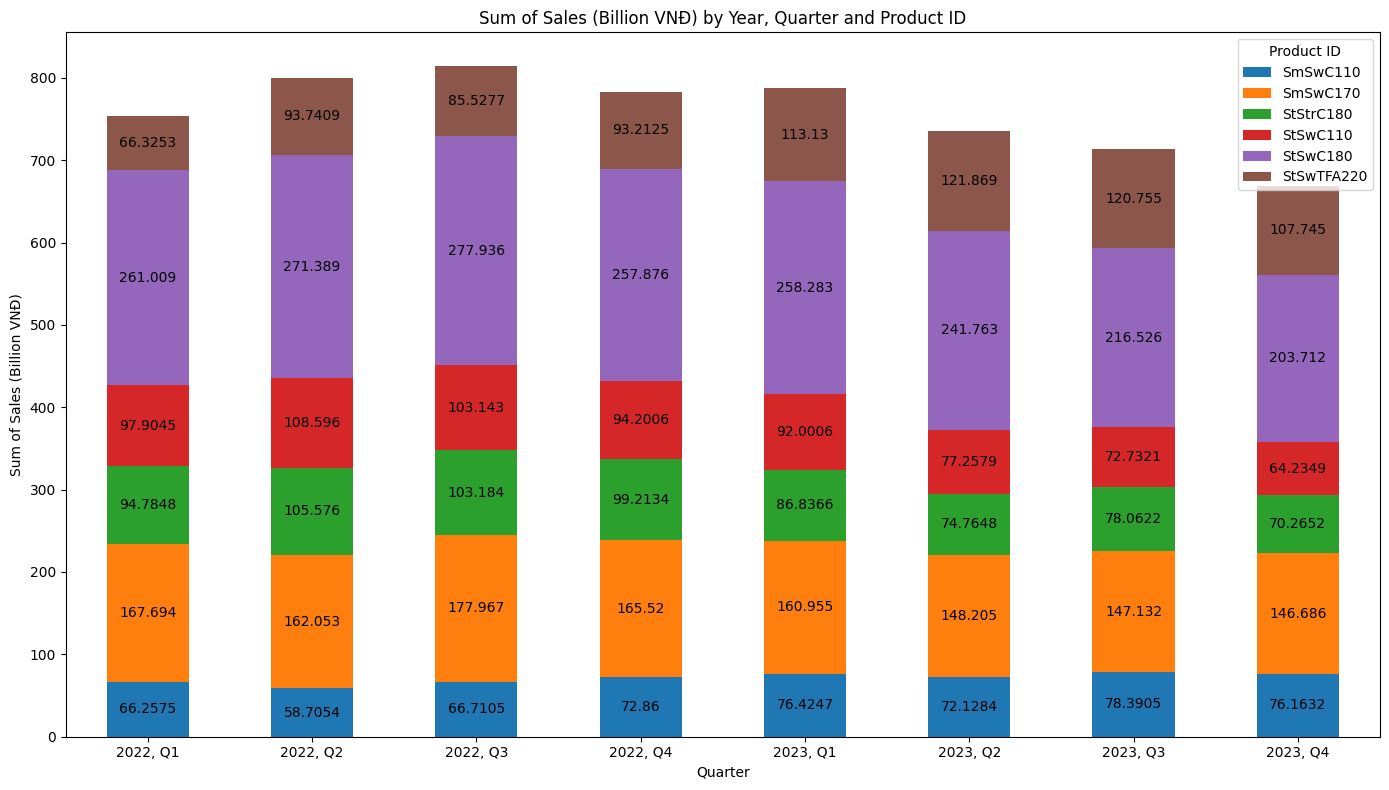

In [50]:
grouped_data = sales.groupby(['Year', 'Quarter', 'Product ID'])['Sales (Billion VNĐ)'].sum().unstack()
grouped_data = grouped_data.reset_index()
grouped_data['Year_Quarter'] = grouped_data['Year'].astype(str) + ', Q' + grouped_data['Quarter'].str[-1]
grouped_data = grouped_data.set_index('Year_Quarter')
grouped_data = grouped_data.drop(columns=['Year', 'Quarter'])

ax = grouped_data.plot(kind='bar', stacked=True, figsize=(14, 8))
plt.title('Sum of Sales (Billion VNĐ) by Year, Quarter and Product ID')
plt.xlabel('Quarter')
plt.ylabel('Sum of Sales (Billion VNĐ)')
plt.legend(title='Product ID')

for container in ax.containers:
    ax.bar_label(container, label_type='center')

plt.xticks(rotation=0)
plt.tight_layout()
plt.show()

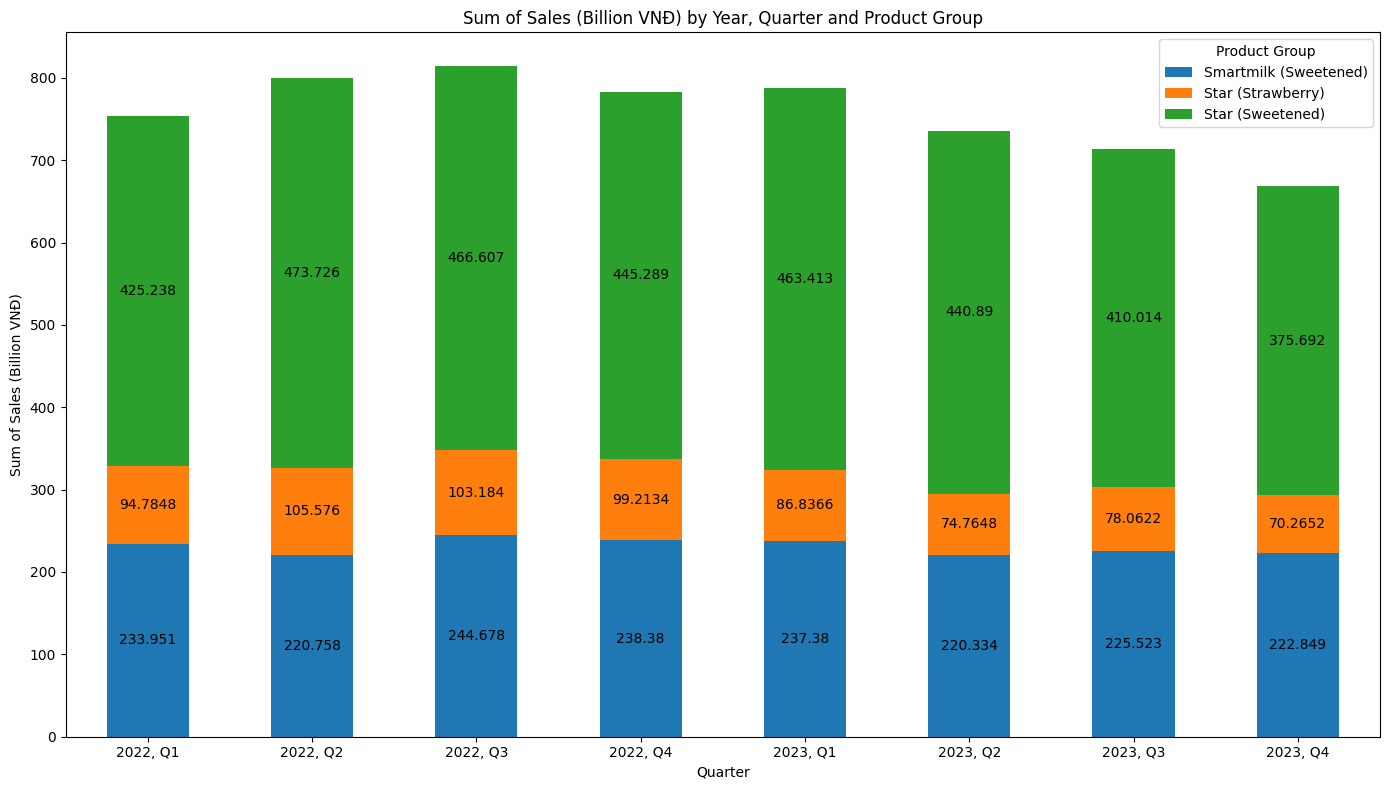

In [51]:
product_groups = {
    'SmSwC110': 'Smartmilk (Sweetened)',
    'SmSwC170': 'Smartmilk (Sweetened)',
    'StStrC180': 'Star (Strawberry)',
    'StSwC110': 'Star (Sweetened)',
    'StSwC180': 'Star (Sweetened)',
    'StSwTFA220': 'Star (Sweetened)'
}

sales['Product Group'] = sales['Product ID'].map(product_groups)

grouped_data = sales.groupby(['Year', 'Quarter', 'Product Group'])['Sales (Billion VNĐ)'].sum().unstack()
grouped_data = grouped_data.reset_index()
grouped_data['Year_Quarter'] = grouped_data['Year'].astype(str) + ', Q' + grouped_data['Quarter'].str[-1]
grouped_data = grouped_data.set_index('Year_Quarter')
grouped_data = grouped_data.drop(columns=['Year', 'Quarter'])


ax = grouped_data.plot(kind='bar', stacked=True, figsize=(14, 8))
plt.title('Sum of Sales (Billion VNĐ) by Year, Quarter and Product Group')
plt.xlabel('Quarter')
plt.ylabel('Sum of Sales (Billion VNĐ)')
plt.legend(title='Product Group')

for container in ax.containers:
    ax.bar_label(container, label_type='center')

plt.xticks(rotation=0)
plt.tight_layout()
plt.show()

sales.drop('Product Group',axis=1,inplace=True)

---
- **Tổng doanh thu Yoji 2023 giảm 8% so với 2022**
    - Doanh thu tăng 8% từ Q1 - Q3 2022, nhưng giảm mạnh từ đầu 2023 tới hết năm (-15% so với cùng kì)
    - Các dòng sản phẩm không có sự tăng trưởng, đặc biệt thấy rõ ở dòng Sữa có đường của Star (chiếm tới 50% tỉ trọng doanh thu) giảm mạnh.
---


In [52]:
market_sales_data = marketSales.copy()
grouped_flavour_data = market_sales_data.groupby(['Year', 'FLAVOUR'])['Sales (Billion VNĐ)'].sum().reset_index()

fig = px.bar(grouped_flavour_data, 
             x='Sales (Billion VNĐ)', 
             y='Year', 
             color='FLAVOUR', 
             orientation='h', 
             title='Sum of Sales (Billion VNĐ) by Year and FLAVOUR',
             text='Sales (Billion VNĐ)',
             color_discrete_map={
                 'Chocolate': 'blue',
                 'Less Sugar': 'navy',
                 'Plain': 'orange',
                 'Strawberry': 'pink',
                 'Sweetened': 'lightblue',
                 'Vanilla': 'purple'
             })

fig.update_layout(barmode='stack', xaxis={'categoryorder':'total descending'}, yaxis_title='Year', xaxis_title='Sum of Sales (Billion VNĐ)')
fig.update_traces(texttemplate='%{text:.2s}', textposition='inside')

fig.show()


---
- Tuy nhiên quy mô thị trường vẫn tăng ở với tất cả dòng sản phẩm
→ Khách hàng đang chuyển sang sử dụng sản phẩm khác của các đối thủ
---


## 5. Product Line (Phân tích BCG)

## 6. Forecast - Chọn model

## Model 1: LSTM (Long Short-Term Memory)

In [ ]:
data = pd.read_csv('C:/Users/Admin/Desktop/Milk case - Data Final - sales.csv')

def quarter_to_date(quarter):
    year = int(quarter.split("'")[1])
    q = int(quarter.split("'")[0].replace("Q", ""))
    month = (q - 1) * 3 + 1
    return pd.Timestamp(year=2000 + year, month=month, day=1)

data['Time'] = data['Time'].apply(quarter_to_date)
data = data.sort_values('Time')

groups = data.groupby(['Market', 'BRAND', 'FLAVOUR', 'BASESIZE'])

results = []
predictions_list = []

aggregated_test_actual_sales = []
aggregated_test_actual_units = []
aggregated_test_predictions_sales = []
aggregated_test_predictions_units = []

for group_name, group_data in groups:
    print(f"Processing group: {group_name}")
    
    group_data = group_data[['Time', 'Sales', 'Units Sold']]
    group_data.set_index('Time', inplace=True)

    scaler = MinMaxScaler(feature_range=(0, 1))
    scaled_data = scaler.fit_transform(group_data)

    def create_dataset(dataset, time_step=1):
        X, Y = [], []
        for i in range(len(dataset) - time_step - 1):
            a = dataset[i:(i + time_step), :]
            X.append(a)
            Y.append(dataset[i + time_step, :])
        return np.array(X), np.array(Y)

    time_step = 4
    X, Y = create_dataset(scaled_data, time_step)

    if len(X) == 0 or len(Y) == 0:
        print(f"Not enough data for group {group_name}. Skipping.")
        continue

    train_size = int(len(X) * 0.8)
    test_size = len(X) - train_size
    X_train, X_test = X[0:train_size], X[train_size:len(X)]
    Y_train, Y_test = Y[0:train_size], Y[train_size:len(Y)]

    if len(X_train) == 0 or len(X_test) == 0:
        print(f"Not enough data to split for group {group_name}. Skipping.")
        continue

    model = Sequential()
    model.add(LSTM(50, return_sequences=True, input_shape=(time_step, X_train.shape[2])))
    model.add(LSTM(50, return_sequences=False))
    model.add(Dense(25))
    model.add(Dense(2)) 

    model.compile(optimizer='adam', loss='mean_squared_error')

    model.fit(X_train, Y_train, batch_size=1, epochs=200, verbose=2)

    test_predictions = model.predict(X_test)
    test_predictions_actual = scaler.inverse_transform(test_predictions)
    Y_test_actual = scaler.inverse_transform(Y_test)

    aggregated_test_actual_sales.extend(Y_test_actual[:, 0])
    aggregated_test_actual_units.extend(Y_test_actual[:, 1])
    aggregated_test_predictions_sales.extend(test_predictions_actual[:, 0])
    aggregated_test_predictions_units.extend(test_predictions_actual[:, 1])

    def predict_future(model, data, time_step, n_quarters):
        temp_input = data[-time_step:].reshape(1, time_step, -1)
        future_predictions = []
        for _ in range(n_quarters):
            predicted = model.predict(temp_input)
            future_predictions.append(predicted)
            temp_input = np.append(temp_input[:, 1:, :], predicted.reshape(1, 1, -1), axis=1)
        return np.array(future_predictions).reshape(n_quarters, -1)

    n_quarters = 4
    future_predictions = predict_future(model, scaled_data, time_step, n_quarters)
    future_predictions_actual = scaler.inverse_transform(future_predictions)

    future_dates = pd.date_range(start=group_data.index[-1], periods=n_quarters + 1, freq='QS')[1:]
    predictions_df = pd.DataFrame(future_predictions_actual, columns=['Sales', 'Units Sold'], index=future_dates)
    
    for date in predictions_df.index:
        predictions_list.append([group_name[0], group_name[1], group_name[2], group_name[3], date, 
                                 predictions_df.loc[date, 'Sales'], predictions_df.loc[date, 'Units Sold']])
    
    results.append({
        'group': group_name,
        'predictions': predictions_df
    })

aggregated_test_actual_sales = np.array(aggregated_test_actual_sales)
aggregated_test_predictions_sales = np.array(aggregated_test_predictions_sales)

overall_mse_sales = mean_squared_error(aggregated_test_actual_sales, aggregated_test_predictions_sales)
overall_mae_sales = mean_absolute_error(aggregated_test_actual_sales, aggregated_test_predictions_sales)
overall_r2_sales = r2_score(aggregated_test_actual_sales, aggregated_test_predictions_sales)

print(f"Overall Sales - Mean Squared Error: {overall_mse_sales}")
print(f"Overall Sales - Mean Absolute Error: {overall_mae_sales}")
print(f"Overall Sales - R-squared: {overall_r2_sales}")

aggregated_test_actual_units = np.array(aggregated_test_actual_units)
aggregated_test_predictions_units = np.array(aggregated_test_predictions_units)

overall_mse_units = mean_squared_error(aggregated_test_actual_units, aggregated_test_predictions_units)
overall_mae_units = mean_absolute_error(aggregated_test_actual_units, aggregated_test_predictions_units)
overall_r2_units = r2_score(aggregated_test_actual_units, aggregated_test_predictions_units)

print(f"Overall Units Sold - Mean Squared Error: {overall_mse_units}")
print(f"Overall Units Sold - Mean Absolute Error: {overall_mae_units}")
print(f"Overall Units Sold - R-squared: {overall_r2_units}")

predictions_merged_df = pd.DataFrame(predictions_list, columns=['Market', 'BRAND', 'FLAVOUR', 'BASESIZE', 'Time', 'Sales', 'Units Sold'])

print(predictions_merged_df.head())

Processing group: ('MT Urban', 'Smartmilk', 'Sweetened', 110)
Epoch 1/200
2/2 - 2s - 1s/step - loss: 0.3133
Epoch 2/200
2/2 - 0s - 11ms/step - loss: 0.2549
Epoch 3/200
2/2 - 0s - 12ms/step - loss: 0.2112
Epoch 4/200
2/2 - 0s - 11ms/step - loss: 0.1832
Epoch 5/200
2/2 - 0s - 11ms/step - loss: 0.1307
Epoch 6/200
2/2 - 0s - 10ms/step - loss: 0.0998
Epoch 7/200
2/2 - 0s - 11ms/step - loss: 0.0940
Epoch 8/200
2/2 - 0s - 11ms/step - loss: 0.0634
Epoch 9/200
2/2 - 0s - 11ms/step - loss: 0.0752
Epoch 10/200
2/2 - 0s - 10ms/step - loss: 0.0752
Epoch 11/200
2/2 - 0s - 11ms/step - loss: 0.0758
Epoch 12/200
2/2 - 0s - 11ms/step - loss: 0.0735
Epoch 13/200
2/2 - 0s - 10ms/step - loss: 0.0665
Epoch 14/200
2/2 - 0s - 11ms/step - loss: 0.0676
Epoch 15/200
2/2 - 0s - 10ms/step - loss: 0.0637
Epoch 16/200
2/2 - 0s - 12ms/step - loss: 0.0569
Epoch 17/200
2/2 - 0s - 10ms/step - loss: 0.0613
Epoch 18/200
2/2 - 0s - 12ms/step - loss: 0.0579
Epoch 19/200
2/2 - 0s - 10ms/step - loss: 0.0605
Epoch 20/200
2/2 -

## Model 2: Neural Prophet

In [ ]:
df = pd.read_csv('C:/Users/Admin/Desktop/Milk case - Data Final - sales.csv')

df['Year'] = df['Time'].apply(lambda x: int(x.split("'")[1]) + 2000)
df['Quarter'] = df['Time'].apply(lambda x: int(x[1]))

df['ds'] = df.apply(lambda row: f"{row['Year']}-Q{row['Quarter']}", axis=1)
df['ds'] = pd.PeriodIndex(df['ds'], freq='Q').to_timestamp()

df.drop(['Time', 'Year', 'Quarter'], axis=1, inplace=True)

df = df.drop_duplicates(subset=['ds', 'Market', 'BRAND', 'FLAVOUR', 'BASESIZE'])
df = df.sort_values(by='ds')

In [ ]:
def train_and_predict(df, market, brand, flavor, basesize):
    group_df = df[(df['Market'] == market) & (df['BRAND'] == brand) & (df['FLAVOUR'] == flavor) & (df['BASESIZE'] == basesize)]
    
    if group_df.empty:
        return None
    
    if group_df['Sales'].nunique() < 2 or group_df['Units Sold'].nunique() < 2 or len(group_df) < 5:
        print(f"Skipping group {market}, {brand}, {flavor}, {basesize} due to insufficient variability or data points.")
        return None
    
    df_sales = group_df[['ds', 'Sales']].rename(columns={'Sales': 'y'})
    df_units_sold = group_df[['ds', 'Units Sold']].rename(columns={'Units Sold': 'y'})
    
    model_sales = NeuralProphet()
    model_units_sold = NeuralProphet()
    
    model_sales.fit(df_sales, freq='Q')
    model_units_sold.fit(df_units_sold, freq='Q')
    
    future_sales = model_sales.make_future_dataframe(df_sales, periods=4, n_historic_predictions=len(df_sales))
    future_units_sold = model_units_sold.make_future_dataframe(df_units_sold, periods=4, n_historic_predictions=len(df_units_sold))
    
    forecast_sales = model_sales.predict(future_sales)
    forecast_units_sold = model_units_sold.predict(future_units_sold)
    
    future_sales_predictions = forecast_sales[['ds', 'yhat1']].tail(4).rename(columns={'yhat1': 'Predicted Sales'})
    future_units_sold_predictions = forecast_units_sold[['ds', 'yhat1']].tail(4).rename(columns={'yhat1': 'Predicted Units Sold'})
    
    future_predictions = pd.merge(future_sales_predictions, future_units_sold_predictions, on='ds')
    future_predictions['Market'] = market
    future_predictions['BRAND'] = brand
    future_predictions['FLAVOUR'] = flavor
    future_predictions['BASESIZE'] = basesize
    future_predictions['Year'] = future_predictions['ds'].dt.year
    future_predictions['Quarter'] = future_predictions['ds'].dt.quarter
    future_predictions = future_predictions.drop(columns=['ds'])
    
    mse_sales = mean_squared_error(df_sales['y'], forecast_sales['yhat1'][:-4])
    r2_sales = r2_score(df_sales['y'], forecast_sales['yhat1'][:-4])
    
    mse_units_sold = mean_squared_error(df_units_sold['y'], forecast_units_sold['yhat1'][:-4])
    r2_units_sold = r2_score(df_units_sold['y'], forecast_units_sold['yhat1'][:-4])
    
    return future_predictions, mse_sales, r2_sales, mse_units_sold, r2_units_sold

all_predictions = []
mse_sales_list = []
r2_sales_list = []
mse_units_sold_list = []
r2_units_sold_list = []

for (market, brand, flavor, basesize), group_df in df.groupby(['Market', 'BRAND', 'FLAVOUR', 'BASESIZE']):
    result = train_and_predict(df, market, brand, flavor, basesize)
    if result is not None:
        future_predictions, mse_sales, r2_sales, mse_units_sold, r2_units_sold = result
        all_predictions.append(future_predictions)
        mse_sales_list.append(mse_sales)
        r2_sales_list.append(r2_sales)
        mse_units_sold_list.append(mse_units_sold)
        r2_units_sold_list.append(r2_units_sold)

all_predictions_df = pd.concat(all_predictions, ignore_index=True)
print(all_predictions_df)


WARNING - (NP.forecaster.fit) - When Global modeling with local normalization, metrics are displayed in normalized scale.
INFO - (NP.df_utils._infer_frequency) - Major frequency QS corresponds to 62.5% of the data.
WARNING - (NP.df_utils._infer_frequency) - Dataframe has multiple frequencies. It will be resampled according to given freq Q. Ignore                     message if actual frequency is any of the following:  SM, BM, CBM, SMS, BMS, CBMS, BQ, BQS, BA,                         or, BAS.
INFO - (NP.config.init_data_params) - Setting normalization to global as only one dataframe provided for training.
INFO - (NP.utils.set_auto_seasonalities) - Disabling yearly seasonality. Run NeuralProphet with yearly_seasonality=True to override this.
INFO - (NP.utils.set_auto_seasonalities) - Disabling weekly seasonality. Run NeuralProphet with weekly_seasonality=True to override this.
INFO - (NP.utils.set_auto_seasonalities) - Disabling daily seasonality. Run NeuralProphet with daily_seasonalit

Training: |          | 0/? [00:00<?, ?it/s]

WARNING - (NP.config.set_lr_finder_args) - Learning rate finder: The number of batches (1) is too small than the required number                     for the learning rate finder (200). The results might not be optimal.
Missing logger folder: c:\Users\Admin\Desktop\lightning_logs
Finding best initial lr: 100%|██████████| 200/200 [00:00<00:00, 268.76it/s]


Training: |          | 0/? [00:04<?, ?it/s, v_num=0, train_loss=0.0374, reg_loss=0.000, MAE=0.223, RMSE=0.379, Loss=0.0374, RegLoss=0.000]

WARNING - (NP.forecaster.fit) - When Global modeling with local normalization, metrics are displayed in normalized scale.
INFO - (NP.df_utils._infer_frequency) - Major frequency QS corresponds to 62.5% of the data.
WARNING - (NP.df_utils._infer_frequency) - Dataframe has multiple frequencies. It will be resampled according to given freq Q. Ignore                     message if actual frequency is any of the following:  SM, BM, CBM, SMS, BMS, CBMS, BQ, BQS, BA,                         or, BAS.


INFO - (NP.config.init_data_params) - Setting normalization to global as only one dataframe provided for training.
INFO - (NP.utils.set_auto_seasonalities) - Disabling yearly seasonality. Run NeuralProphet with yearly_seasonality=True to override this.
INFO - (NP.utils.set_auto_seasonalities) - Disabling weekly seasonality. Run NeuralProphet with weekly_seasonality=True to override this.
INFO - (NP.utils.set_auto_seasonalities) - Disabling daily seasonality. Run NeuralProphet with daily_seasonality=True to override this.
INFO - (NP.config.set_auto_batch_epoch) - Auto-set batch_size to 8
INFO - (NP.config.set_auto_batch_epoch) - Auto-set epochs to 500


Training: |          | 0/? [00:00<?, ?it/s]

WARNING - (NP.config.set_lr_finder_args) - Learning rate finder: The number of batches (1) is too small than the required number                     for the learning rate finder (200). The results might not be optimal.
Finding best initial lr: 100%|██████████| 200/200 [00:00<00:00, 284.20it/s]


Training: |          | 0/? [00:04<?, ?it/s, v_num=1, train_loss=0.0391, reg_loss=0.000, MAE=0.138, RMSE=0.231, Loss=0.0391, RegLoss=0.000]

INFO - (NP.df_utils._infer_frequency) - Major frequency QS corresponds to 62.5% of the data.
WARNING - (NP.df_utils._infer_frequency) - Dataframe has multiple frequencies. It will be resampled according to given freq Q. Ignore                     message if actual frequency is any of the following:  SM, BM, CBM, SMS, BMS, CBMS, BQ, BQS, BA,                         or, BAS.


INFO - (NP.df_utils.return_df_in_original_format) - Returning df with no ID column
INFO - (NP.df_utils._infer_frequency) - Major frequency QS corresponds to 62.5% of the data.
WARNING - (NP.df_utils._infer_frequency) - Dataframe has multiple frequencies. It will be resampled according to given freq Q. Ignore                     message if actual frequency is any of the following:  SM, BM, CBM, SMS, BMS, CBMS, BQ, BQS, BA,                         or, BAS.
INFO - (NP.df_utils.return_df_in_original_format) - Returning df with no ID column
INFO - (NP.df_utils._infer_frequency) - Major frequency 13W-SAT corresponds to 41.667% of the data.
WARNING - (NP.df_utils._infer_frequency) - Dataframe has multiple frequencies. It will be resampled according to given freq Q. Ignore                     message if actual frequency is any of the following:  SM, BM, CBM, SMS, BMS, CBMS, BQ, BQS, BA,                         or, BAS.
INFO - (NP.df_utils._infer_frequency) - Major frequency 13W-SAT corresponds

Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 333.57it/s]

INFO - (NP.df_utils.return_df_in_original_format) - Returning df with no ID column


INFO - (NP.df_utils._infer_frequency) - Major frequency 13W-SAT corresponds to 41.667% of the data.
WARNING - (NP.df_utils._infer_frequency) - Dataframe has multiple frequencies. It will be resampled according to given freq Q. Ignore                     message if actual frequency is any of the following:  SM, BM, CBM, SMS, BMS, CBMS, BQ, BQS, BA,                         or, BAS.
INFO - (NP.df_utils._infer_frequency) - Major frequency 13W-SAT corresponds to 41.667% of the data.
WARNING - (NP.df_utils._infer_frequency) - Dataframe has multiple frequencies. It will be resampled according to given freq Q. Ignore                     message if actual frequency is any of the following:  SM, BM, CBM, SMS, BMS, CBMS, BQ, BQS, BA,                         or, BAS.
INFO - (NP.data.processing._handle_missing_data) - Dropped 4 rows at the end with NaNs in 'y' column.


Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 165.58it/s]

INFO - (NP.df_utils.return_df_in_original_format) - Returning df with no ID column


WARNING - (NP.forecaster.fit) - When Global modeling with local normalization, metrics are displayed in normalized scale.
INFO - (NP.df_utils._infer_frequency) - Major frequency QS corresponds to 62.5% of the data.
WARNING - (NP.df_utils._infer_frequency) - Dataframe has multiple frequencies. It will be resampled according to given freq Q. Ignore                     message if actual frequency is any of the following:  SM, BM, CBM, SMS, BMS, CBMS, BQ, BQS, BA,                         or, BAS.
INFO - (NP.config.init_data_params) - Setting normalization to global as only one dataframe provided for training.
INFO - (NP.utils.set_auto_seasonalities) - Disabling yearly seasonality. Run NeuralProphet with yearly_seasonality=True to override this.
INFO - (NP.utils.set_auto_seasonalities) - Disabling weekly seasonality. Run NeuralProphet with weekly_seasonality=True to override this.
INFO - (NP.utils.set_auto_seasonalities) - Disabling daily seasonality. Run NeuralProphet with daily_seasonalit

Training: |          | 0/? [00:00<?, ?it/s]

WARNING - (NP.config.set_lr_finder_args) - Learning rate finder: The number of batches (1) is too small than the required number                     for the learning rate finder (200). The results might not be optimal.
Finding best initial lr: 100%|██████████| 200/200 [00:00<00:00, 285.81it/s]


Training: |          | 0/? [00:04<?, ?it/s, v_num=2, train_loss=0.0705, reg_loss=0.000, MAE=0.911, RMSE=1.120, Loss=0.0705, RegLoss=0.000]

WARNING - (NP.forecaster.fit) - When Global modeling with local normalization, metrics are displayed in normalized scale.


INFO - (NP.df_utils._infer_frequency) - Major frequency QS corresponds to 62.5% of the data.
WARNING - (NP.df_utils._infer_frequency) - Dataframe has multiple frequencies. It will be resampled according to given freq Q. Ignore                     message if actual frequency is any of the following:  SM, BM, CBM, SMS, BMS, CBMS, BQ, BQS, BA,                         or, BAS.
INFO - (NP.config.init_data_params) - Setting normalization to global as only one dataframe provided for training.
INFO - (NP.utils.set_auto_seasonalities) - Disabling yearly seasonality. Run NeuralProphet with yearly_seasonality=True to override this.
INFO - (NP.utils.set_auto_seasonalities) - Disabling weekly seasonality. Run NeuralProphet with weekly_seasonality=True to override this.
INFO - (NP.utils.set_auto_seasonalities) - Disabling daily seasonality. Run NeuralProphet with daily_seasonality=True to override this.
INFO - (NP.config.set_auto_batch_epoch) - Auto-set batch_size to 8
INFO - (NP.config.set_auto_bat

Training: |          | 0/? [00:00<?, ?it/s]

WARNING - (NP.config.set_lr_finder_args) - Learning rate finder: The number of batches (1) is too small than the required number                     for the learning rate finder (200). The results might not be optimal.
Finding best initial lr: 100%|██████████| 200/200 [00:00<00:00, 254.15it/s]


Training: |          | 0/? [00:04<?, ?it/s, v_num=3, train_loss=0.0151, reg_loss=0.000, MAE=0.149, RMSE=0.242, Loss=0.0151, RegLoss=0.000]

INFO - (NP.df_utils._infer_frequency) - Major frequency QS corresponds to 62.5% of the data.
WARNING - (NP.df_utils._infer_frequency) - Dataframe has multiple frequencies. It will be resampled according to given freq Q. Ignore                     message if actual frequency is any of the following:  SM, BM, CBM, SMS, BMS, CBMS, BQ, BQS, BA,                         or, BAS.
INFO - (NP.df_utils.return_df_in_original_format) - Returning df with no ID column


INFO - (NP.df_utils._infer_frequency) - Major frequency QS corresponds to 62.5% of the data.
WARNING - (NP.df_utils._infer_frequency) - Dataframe has multiple frequencies. It will be resampled according to given freq Q. Ignore                     message if actual frequency is any of the following:  SM, BM, CBM, SMS, BMS, CBMS, BQ, BQS, BA,                         or, BAS.
INFO - (NP.df_utils.return_df_in_original_format) - Returning df with no ID column
INFO - (NP.df_utils._infer_frequency) - Major frequency 13W-SAT corresponds to 41.667% of the data.
WARNING - (NP.df_utils._infer_frequency) - Dataframe has multiple frequencies. It will be resampled according to given freq Q. Ignore                     message if actual frequency is any of the following:  SM, BM, CBM, SMS, BMS, CBMS, BQ, BQS, BA,                         or, BAS.
INFO - (NP.df_utils._infer_frequency) - Major frequency 13W-SAT corresponds to 41.667% of the data.
WARNING - (NP.df_utils._infer_frequency) - Dataframe has m

Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 333.25it/s]

INFO - (NP.df_utils.return_df_in_original_format) - Returning df with no ID column
INFO - (NP.df_utils._infer_frequency) - Major frequency 13W-SAT corresponds to 41.667% of the data.
WARNING - (NP.df_utils._infer_frequency) - Dataframe has multiple frequencies. It will be resampled according to given freq Q. Ignore                     message if actual frequency is any of the following:  SM, BM, CBM, SMS, BMS, CBMS, BQ, BQS, BA,                         or, BAS.
INFO - (NP.df_utils._infer_frequency) - Major frequency 13W-SAT corresponds to 41.667% of the data.


WARNING - (NP.df_utils._infer_frequency) - Dataframe has multiple frequencies. It will be resampled according to given freq Q. Ignore                     message if actual frequency is any of the following:  SM, BM, CBM, SMS, BMS, CBMS, BQ, BQS, BA,                         or, BAS.
INFO - (NP.data.processing._handle_missing_data) - Dropped 4 rows at the end with NaNs in 'y' column.


Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 298.40it/s]

INFO - (NP.df_utils.return_df_in_original_format) - Returning df with no ID column
WARNING - (NP.forecaster.fit) - When Global modeling with local normalization, metrics are displayed in normalized scale.


INFO - (NP.df_utils._infer_frequency) - Major frequency QS corresponds to 62.5% of the data.
WARNING - (NP.df_utils._infer_frequency) - Dataframe has multiple frequencies. It will be resampled according to given freq Q. Ignore                     message if actual frequency is any of the following:  SM, BM, CBM, SMS, BMS, CBMS, BQ, BQS, BA,                         or, BAS.
INFO - (NP.config.init_data_params) - Setting normalization to global as only one dataframe provided for training.
INFO - (NP.utils.set_auto_seasonalities) - Disabling yearly seasonality. Run NeuralProphet with yearly_seasonality=True to override this.
INFO - (NP.utils.set_auto_seasonalities) - Disabling weekly seasonality. Run NeuralProphet with weekly_seasonality=True to override this.
INFO - (NP.utils.set_auto_seasonalities) - Disabling daily seasonality. Run NeuralProphet with daily_seasonality=True to override this.
INFO - (NP.config.set_auto_batch_epoch) - Auto-set batch_size to 8
INFO - (NP.config.set_auto_bat

Training: |          | 0/? [00:00<?, ?it/s]

WARNING - (NP.config.set_lr_finder_args) - Learning rate finder: The number of batches (1) is too small than the required number                     for the learning rate finder (200). The results might not be optimal.
Finding best initial lr: 100%|██████████| 200/200 [00:00<00:00, 283.34it/s]


Training: |          | 0/? [00:04<?, ?it/s, v_num=4, train_loss=0.0103, reg_loss=0.000, MAE=0.565, RMSE=0.677, Loss=0.0103, RegLoss=0.000]

WARNING - (NP.forecaster.fit) - When Global modeling with local normalization, metrics are displayed in normalized scale.


INFO - (NP.df_utils._infer_frequency) - Major frequency QS corresponds to 62.5% of the data.
WARNING - (NP.df_utils._infer_frequency) - Dataframe has multiple frequencies. It will be resampled according to given freq Q. Ignore                     message if actual frequency is any of the following:  SM, BM, CBM, SMS, BMS, CBMS, BQ, BQS, BA,                         or, BAS.
INFO - (NP.config.init_data_params) - Setting normalization to global as only one dataframe provided for training.
INFO - (NP.utils.set_auto_seasonalities) - Disabling yearly seasonality. Run NeuralProphet with yearly_seasonality=True to override this.
INFO - (NP.utils.set_auto_seasonalities) - Disabling weekly seasonality. Run NeuralProphet with weekly_seasonality=True to override this.
INFO - (NP.utils.set_auto_seasonalities) - Disabling daily seasonality. Run NeuralProphet with daily_seasonality=True to override this.
INFO - (NP.config.set_auto_batch_epoch) - Auto-set batch_size to 8
INFO - (NP.config.set_auto_bat

Training: |          | 0/? [00:00<?, ?it/s]

WARNING - (NP.config.set_lr_finder_args) - Learning rate finder: The number of batches (1) is too small than the required number                     for the learning rate finder (200). The results might not be optimal.
Finding best initial lr: 100%|██████████| 200/200 [00:00<00:00, 257.08it/s]


Training: |          | 0/? [00:04<?, ?it/s, v_num=5, train_loss=0.00129, reg_loss=0.000, MAE=0.031, RMSE=0.0512, Loss=0.00129, RegLoss=0.000] 

INFO - (NP.df_utils._infer_frequency) - Major frequency QS corresponds to 62.5% of the data.


WARNING - (NP.df_utils._infer_frequency) - Dataframe has multiple frequencies. It will be resampled according to given freq Q. Ignore                     message if actual frequency is any of the following:  SM, BM, CBM, SMS, BMS, CBMS, BQ, BQS, BA,                         or, BAS.
INFO - (NP.df_utils.return_df_in_original_format) - Returning df with no ID column
INFO - (NP.df_utils._infer_frequency) - Major frequency QS corresponds to 62.5% of the data.
WARNING - (NP.df_utils._infer_frequency) - Dataframe has multiple frequencies. It will be resampled according to given freq Q. Ignore                     message if actual frequency is any of the following:  SM, BM, CBM, SMS, BMS, CBMS, BQ, BQS, BA,                         or, BAS.
INFO - (NP.df_utils.return_df_in_original_format) - Returning df with no ID column
INFO - (NP.df_utils._infer_frequency) - Major frequency 13W-SAT corresponds to 41.667% of the data.
WARNING - (NP.df_utils._infer_frequency) - Dataframe has multiple frequenci

Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 333.28it/s]

INFO - (NP.df_utils.return_df_in_original_format) - Returning df with no ID column
INFO - (NP.df_utils._infer_frequency) - Major frequency 13W-SAT corresponds to 41.667% of the data.


WARNING - (NP.df_utils._infer_frequency) - Dataframe has multiple frequencies. It will be resampled according to given freq Q. Ignore                     message if actual frequency is any of the following:  SM, BM, CBM, SMS, BMS, CBMS, BQ, BQS, BA,                         or, BAS.
INFO - (NP.df_utils._infer_frequency) - Major frequency 13W-SAT corresponds to 41.667% of the data.
WARNING - (NP.df_utils._infer_frequency) - Dataframe has multiple frequencies. It will be resampled according to given freq Q. Ignore                     message if actual frequency is any of the following:  SM, BM, CBM, SMS, BMS, CBMS, BQ, BQS, BA,                         or, BAS.
INFO - (NP.data.processing._handle_missing_data) - Dropped 4 rows at the end with NaNs in 'y' column.


Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 333.46it/s]

INFO - (NP.df_utils.return_df_in_original_format) - Returning df with no ID column
WARNING - (NP.forecaster.fit) - When Global modeling with local normalization, metrics are displayed in normalized scale.


INFO - (NP.df_utils._infer_frequency) - Major frequency QS corresponds to 62.5% of the data.
WARNING - (NP.df_utils._infer_frequency) - Dataframe has multiple frequencies. It will be resampled according to given freq Q. Ignore                     message if actual frequency is any of the following:  SM, BM, CBM, SMS, BMS, CBMS, BQ, BQS, BA,                         or, BAS.
INFO - (NP.config.init_data_params) - Setting normalization to global as only one dataframe provided for training.
INFO - (NP.utils.set_auto_seasonalities) - Disabling yearly seasonality. Run NeuralProphet with yearly_seasonality=True to override this.
INFO - (NP.utils.set_auto_seasonalities) - Disabling weekly seasonality. Run NeuralProphet with weekly_seasonality=True to override this.
INFO - (NP.utils.set_auto_seasonalities) - Disabling daily seasonality. Run NeuralProphet with daily_seasonality=True to override this.
INFO - (NP.config.set_auto_batch_epoch) - Auto-set batch_size to 8
INFO - (NP.config.set_auto_bat

Epoch 500: 100%|██████████| 500/500 [00:00<00:00, 3302.75it/s]  

WARNING - (NP.config.set_lr_finder_args) - Learning rate finder: The number of batches (1) is too small than the required number                     for the learning rate finder (200). The results might not be optimal.


Finding best initial lr: 100%|██████████| 200/200 [00:00<00:00, 259.09it/s]


Training: |          | 0/? [00:04<?, ?it/s, v_num=6, train_loss=0.000189, reg_loss=0.000, MAE=0.0263, RMSE=0.0349, Loss=0.000189, RegLoss=0.000]

WARNING - (NP.forecaster.fit) - When Global modeling with local normalization, metrics are displayed in normalized scale.


INFO - (NP.df_utils._infer_frequency) - Major frequency QS corresponds to 62.5% of the data.
WARNING - (NP.df_utils._infer_frequency) - Dataframe has multiple frequencies. It will be resampled according to given freq Q. Ignore                     message if actual frequency is any of the following:  SM, BM, CBM, SMS, BMS, CBMS, BQ, BQS, BA,                         or, BAS.
INFO - (NP.config.init_data_params) - Setting normalization to global as only one dataframe provided for training.
INFO - (NP.utils.set_auto_seasonalities) - Disabling yearly seasonality. Run NeuralProphet with yearly_seasonality=True to override this.
INFO - (NP.utils.set_auto_seasonalities) - Disabling weekly seasonality. Run NeuralProphet with weekly_seasonality=True to override this.
INFO - (NP.utils.set_auto_seasonalities) - Disabling daily seasonality. Run NeuralProphet with daily_seasonality=True to override this.
INFO - (NP.config.set_auto_batch_epoch) - Auto-set batch_size to 8
INFO - (NP.config.set_auto_bat

Training: |          | 0/? [00:00<?, ?it/s]

WARNING - (NP.config.set_lr_finder_args) - Learning rate finder: The number of batches (1) is too small than the required number                     for the learning rate finder (200). The results might not be optimal.
Finding best initial lr: 100%|██████████| 200/200 [00:00<00:00, 264.40it/s]


Training: |          | 0/? [00:04<?, ?it/s, v_num=7, train_loss=0.0282, reg_loss=0.000, MAE=0.301, RMSE=0.400, Loss=0.0282, RegLoss=0.000]

INFO - (NP.df_utils._infer_frequency) - Major frequency QS corresponds to 62.5% of the data.


WARNING - (NP.df_utils._infer_frequency) - Dataframe has multiple frequencies. It will be resampled according to given freq Q. Ignore                     message if actual frequency is any of the following:  SM, BM, CBM, SMS, BMS, CBMS, BQ, BQS, BA,                         or, BAS.
INFO - (NP.df_utils.return_df_in_original_format) - Returning df with no ID column
INFO - (NP.df_utils._infer_frequency) - Major frequency QS corresponds to 62.5% of the data.
WARNING - (NP.df_utils._infer_frequency) - Dataframe has multiple frequencies. It will be resampled according to given freq Q. Ignore                     message if actual frequency is any of the following:  SM, BM, CBM, SMS, BMS, CBMS, BQ, BQS, BA,                         or, BAS.
INFO - (NP.df_utils.return_df_in_original_format) - Returning df with no ID column
INFO - (NP.df_utils._infer_frequency) - Major frequency 13W-SAT corresponds to 41.667% of the data.
WARNING - (NP.df_utils._infer_frequency) - Dataframe has multiple frequenci

Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 332.99it/s]


INFO - (NP.df_utils.return_df_in_original_format) - Returning df with no ID column
INFO - (NP.df_utils._infer_frequency) - Major frequency 13W-SAT corresponds to 41.667% of the data.
WARNING - (NP.df_utils._infer_frequency) - Dataframe has multiple frequencies. It will be resampled according to given freq Q. Ignore                     message if actual frequency is any of the following:  SM, BM, CBM, SMS, BMS, CBMS, BQ, BQS, BA,                         or, BAS.
INFO - (NP.df_utils._infer_frequency) - Major frequency 13W-SAT corresponds to 41.667% of the data.
WARNING - (NP.df_utils._infer_frequency) - Dataframe has multiple frequencies. It will be resampled according to given freq Q. Ignore                     message if actual frequency is any of the following:  SM, BM, CBM, SMS, BMS, CBMS, BQ, BQS, BA,                         or, BAS.
INFO - (NP.data.processing._handle_missing_data) - Dropped 4 rows at the end with NaNs in 'y' column.


Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 399.12it/s]

INFO - (NP.df_utils.return_df_in_original_format) - Returning df with no ID column
WARNING - (NP.forecaster.fit) - When Global modeling with local normalization, metrics are displayed in normalized scale.
INFO - (NP.df_utils._infer_frequency) - Major frequency QS corresponds to 62.5% of the data.


WARNING - (NP.df_utils._infer_frequency) - Dataframe has multiple frequencies. It will be resampled according to given freq Q. Ignore                     message if actual frequency is any of the following:  SM, BM, CBM, SMS, BMS, CBMS, BQ, BQS, BA,                         or, BAS.
INFO - (NP.config.init_data_params) - Setting normalization to global as only one dataframe provided for training.
INFO - (NP.utils.set_auto_seasonalities) - Disabling yearly seasonality. Run NeuralProphet with yearly_seasonality=True to override this.
INFO - (NP.utils.set_auto_seasonalities) - Disabling weekly seasonality. Run NeuralProphet with weekly_seasonality=True to override this.
INFO - (NP.utils.set_auto_seasonalities) - Disabling daily seasonality. Run NeuralProphet with daily_seasonality=True to override this.
INFO - (NP.config.set_auto_batch_epoch) - Auto-set batch_size to 8
INFO - (NP.config.set_auto_batch_epoch) - Auto-set epochs to 500


Training: |          | 0/? [00:00<?, ?it/s]

WARNING - (NP.config.set_lr_finder_args) - Learning rate finder: The number of batches (1) is too small than the required number                     for the learning rate finder (200). The results might not be optimal.
Finding best initial lr: 100%|██████████| 200/200 [00:00<00:00, 271.41it/s]


Training: |          | 0/? [00:04<?, ?it/s, v_num=8, train_loss=0.0447, reg_loss=0.000, MAE=1.440, RMSE=2.210, Loss=0.0447, RegLoss=0.000]

WARNING - (NP.forecaster.fit) - When Global modeling with local normalization, metrics are displayed in normalized scale.
INFO - (NP.df_utils._infer_frequency) - Major frequency QS corresponds to 62.5% of the data.
WARNING - (NP.df_utils._infer_frequency) - Dataframe has multiple frequencies. It will be resampled according to given freq Q. Ignore                     message if actual frequency is any of the following:  SM, BM, CBM, SMS, BMS, CBMS, BQ, BQS, BA,                         or, BAS.
INFO - (NP.config.init_data_params) - Setting normalization to global as only one dataframe provided for training.


INFO - (NP.utils.set_auto_seasonalities) - Disabling yearly seasonality. Run NeuralProphet with yearly_seasonality=True to override this.
INFO - (NP.utils.set_auto_seasonalities) - Disabling weekly seasonality. Run NeuralProphet with weekly_seasonality=True to override this.
INFO - (NP.utils.set_auto_seasonalities) - Disabling daily seasonality. Run NeuralProphet with daily_seasonality=True to override this.
INFO - (NP.config.set_auto_batch_epoch) - Auto-set batch_size to 8
INFO - (NP.config.set_auto_batch_epoch) - Auto-set epochs to 500


Training: |          | 0/? [00:00<?, ?it/s]

WARNING - (NP.config.set_lr_finder_args) - Learning rate finder: The number of batches (1) is too small than the required number                     for the learning rate finder (200). The results might not be optimal.
Finding best initial lr: 100%|██████████| 200/200 [00:00<00:00, 266.14it/s]


Training: |          | 0/? [00:04<?, ?it/s, v_num=9, train_loss=0.0574, reg_loss=0.000, MAE=0.926, RMSE=1.300, Loss=0.0574, RegLoss=0.000]

INFO - (NP.df_utils._infer_frequency) - Major frequency QS corresponds to 62.5% of the data.
WARNING - (NP.df_utils._infer_frequency) - Dataframe has multiple frequencies. It will be resampled according to given freq Q. Ignore                     message if actual frequency is any of the following:  SM, BM, CBM, SMS, BMS, CBMS, BQ, BQS, BA,                         or, BAS.
INFO - (NP.df_utils.return_df_in_original_format) - Returning df with no ID column
INFO - (NP.df_utils._infer_frequency) - Major frequency QS corresponds to 62.5% of the data.
WARNING - (NP.df_utils._infer_frequency) - Dataframe has multiple frequencies. It will be resampled according to given freq Q. Ignore                     message if actual frequency is any of the following:  SM, BM, CBM, SMS, BMS, CBMS, BQ, BQS, BA,                         or, BAS.


INFO - (NP.df_utils.return_df_in_original_format) - Returning df with no ID column
INFO - (NP.df_utils._infer_frequency) - Major frequency 13W-SAT corresponds to 41.667% of the data.
WARNING - (NP.df_utils._infer_frequency) - Dataframe has multiple frequencies. It will be resampled according to given freq Q. Ignore                     message if actual frequency is any of the following:  SM, BM, CBM, SMS, BMS, CBMS, BQ, BQS, BA,                         or, BAS.
INFO - (NP.df_utils._infer_frequency) - Major frequency 13W-SAT corresponds to 41.667% of the data.
WARNING - (NP.df_utils._infer_frequency) - Dataframe has multiple frequencies. It will be resampled according to given freq Q. Ignore                     message if actual frequency is any of the following:  SM, BM, CBM, SMS, BMS, CBMS, BQ, BQS, BA,                         or, BAS.
INFO - (NP.data.processing._handle_missing_data) - Dropped 4 rows at the end with NaNs in 'y' column.


Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 333.07it/s]

INFO - (NP.df_utils.return_df_in_original_format) - Returning df with no ID column


INFO - (NP.df_utils._infer_frequency) - Major frequency 13W-SAT corresponds to 41.667% of the data.
WARNING - (NP.df_utils._infer_frequency) - Dataframe has multiple frequencies. It will be resampled according to given freq Q. Ignore                     message if actual frequency is any of the following:  SM, BM, CBM, SMS, BMS, CBMS, BQ, BQS, BA,                         or, BAS.
INFO - (NP.df_utils._infer_frequency) - Major frequency 13W-SAT corresponds to 41.667% of the data.
WARNING - (NP.df_utils._infer_frequency) - Dataframe has multiple frequencies. It will be resampled according to given freq Q. Ignore                     message if actual frequency is any of the following:  SM, BM, CBM, SMS, BMS, CBMS, BQ, BQS, BA,                         or, BAS.
INFO - (NP.data.processing._handle_missing_data) - Dropped 4 rows at the end with NaNs in 'y' column.


Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 221.08it/s]

INFO - (NP.df_utils.return_df_in_original_format) - Returning df with no ID column


WARNING - (NP.forecaster.fit) - When Global modeling with local normalization, metrics are displayed in normalized scale.
INFO - (NP.df_utils._infer_frequency) - Major frequency QS corresponds to 62.5% of the data.
WARNING - (NP.df_utils._infer_frequency) - Dataframe has multiple frequencies. It will be resampled according to given freq Q. Ignore                     message if actual frequency is any of the following:  SM, BM, CBM, SMS, BMS, CBMS, BQ, BQS, BA,                         or, BAS.
INFO - (NP.config.init_data_params) - Setting normalization to global as only one dataframe provided for training.
INFO - (NP.utils.set_auto_seasonalities) - Disabling yearly seasonality. Run NeuralProphet with yearly_seasonality=True to override this.
INFO - (NP.utils.set_auto_seasonalities) - Disabling weekly seasonality. Run NeuralProphet with weekly_seasonality=True to override this.
INFO - (NP.utils.set_auto_seasonalities) - Disabling daily seasonality. Run NeuralProphet with daily_seasonalit

Training: |          | 0/? [00:00<?, ?it/s]

WARNING - (NP.config.set_lr_finder_args) - Learning rate finder: The number of batches (1) is too small than the required number                     for the learning rate finder (200). The results might not be optimal.
Finding best initial lr: 100%|██████████| 200/200 [00:00<00:00, 244.55it/s]


Epoch 500: 100%|██████████| 500/500 [00:02<00:00, 243.00it/s]   
Training: |          | 0/? [00:04<?, ?it/s, v_num=10, train_loss=0.000236, reg_loss=0.000, MAE=0.177, RMSE=0.275, Loss=0.000236, RegLoss=0.000]

WARNING - (NP.forecaster.fit) - When Global modeling with local normalization, metrics are displayed in normalized scale.
INFO - (NP.df_utils._infer_frequency) - Major frequency QS corresponds to 62.5% of the data.
WARNING - (NP.df_utils._infer_frequency) - Dataframe has multiple frequencies. It will be resampled according to given freq Q. Ignore                     message if actual frequency is any of the following:  SM, BM, CBM, SMS, BMS, CBMS, BQ, BQS, BA,                         or, BAS.
INFO - (NP.config.init_data_params) - Setting normalization to global as only one dataframe provided for training.


INFO - (NP.utils.set_auto_seasonalities) - Disabling yearly seasonality. Run NeuralProphet with yearly_seasonality=True to override this.
INFO - (NP.utils.set_auto_seasonalities) - Disabling weekly seasonality. Run NeuralProphet with weekly_seasonality=True to override this.
INFO - (NP.utils.set_auto_seasonalities) - Disabling daily seasonality. Run NeuralProphet with daily_seasonality=True to override this.
INFO - (NP.config.set_auto_batch_epoch) - Auto-set batch_size to 8
INFO - (NP.config.set_auto_batch_epoch) - Auto-set epochs to 500


Training: |          | 0/? [00:00<?, ?it/s]

WARNING - (NP.config.set_lr_finder_args) - Learning rate finder: The number of batches (1) is too small than the required number                     for the learning rate finder (200). The results might not be optimal.
Finding best initial lr: 100%|██████████| 200/200 [00:00<00:00, 278.60it/s]


Training: |          | 0/? [00:04<?, ?it/s, v_num=11, train_loss=0.0178, reg_loss=0.000, MAE=0.473, RMSE=0.559, Loss=0.0178, RegLoss=0.000]

INFO - (NP.df_utils._infer_frequency) - Major frequency QS corresponds to 62.5% of the data.


WARNING - (NP.df_utils._infer_frequency) - Dataframe has multiple frequencies. It will be resampled according to given freq Q. Ignore                     message if actual frequency is any of the following:  SM, BM, CBM, SMS, BMS, CBMS, BQ, BQS, BA,                         or, BAS.
INFO - (NP.df_utils.return_df_in_original_format) - Returning df with no ID column
INFO - (NP.df_utils._infer_frequency) - Major frequency QS corresponds to 62.5% of the data.
WARNING - (NP.df_utils._infer_frequency) - Dataframe has multiple frequencies. It will be resampled according to given freq Q. Ignore                     message if actual frequency is any of the following:  SM, BM, CBM, SMS, BMS, CBMS, BQ, BQS, BA,                         or, BAS.
INFO - (NP.df_utils.return_df_in_original_format) - Returning df with no ID column
INFO - (NP.df_utils._infer_frequency) - Major frequency 13W-SAT corresponds to 41.667% of the data.
WARNING - (NP.df_utils._infer_frequency) - Dataframe has multiple frequenci

Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 332.85it/s]

INFO - (NP.df_utils.return_df_in_original_format) - Returning df with no ID column
INFO - (NP.df_utils._infer_frequency) - Major frequency 13W-SAT corresponds to 41.667% of the data.
WARNING - (NP.df_utils._infer_frequency) - Dataframe has multiple frequencies. It will be resampled according to given freq Q. Ignore                     message if actual frequency is any of the following:  SM, BM, CBM, SMS, BMS, CBMS, BQ, BQS, BA,                         or, BAS.
INFO - (NP.df_utils._infer_frequency) - Major frequency 13W-SAT corresponds to 41.667% of the data.


WARNING - (NP.df_utils._infer_frequency) - Dataframe has multiple frequencies. It will be resampled according to given freq Q. Ignore                     message if actual frequency is any of the following:  SM, BM, CBM, SMS, BMS, CBMS, BQ, BQS, BA,                         or, BAS.
INFO - (NP.data.processing._handle_missing_data) - Dropped 4 rows at the end with NaNs in 'y' column.


Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 333.49it/s]

INFO - (NP.df_utils.return_df_in_original_format) - Returning df with no ID column
WARNING - (NP.forecaster.fit) - When Global modeling with local normalization, metrics are displayed in normalized scale.


INFO - (NP.df_utils._infer_frequency) - Major frequency QS corresponds to 62.5% of the data.
WARNING - (NP.df_utils._infer_frequency) - Dataframe has multiple frequencies. It will be resampled according to given freq Q. Ignore                     message if actual frequency is any of the following:  SM, BM, CBM, SMS, BMS, CBMS, BQ, BQS, BA,                         or, BAS.
INFO - (NP.config.init_data_params) - Setting normalization to global as only one dataframe provided for training.
INFO - (NP.utils.set_auto_seasonalities) - Disabling yearly seasonality. Run NeuralProphet with yearly_seasonality=True to override this.
INFO - (NP.utils.set_auto_seasonalities) - Disabling weekly seasonality. Run NeuralProphet with weekly_seasonality=True to override this.
INFO - (NP.utils.set_auto_seasonalities) - Disabling daily seasonality. Run NeuralProphet with daily_seasonality=True to override this.
INFO - (NP.config.set_auto_batch_epoch) - Auto-set batch_size to 8
INFO - (NP.config.set_auto_bat

Training: |          | 0/? [00:00<?, ?it/s]

WARNING - (NP.config.set_lr_finder_args) - Learning rate finder: The number of batches (1) is too small than the required number                     for the learning rate finder (200). The results might not be optimal.
Finding best initial lr: 100%|██████████| 200/200 [00:00<00:00, 266.12it/s]


Training: |          | 0/? [00:04<?, ?it/s, v_num=12, train_loss=0.0145, reg_loss=0.000, MAE=0.657, RMSE=0.844, Loss=0.0145, RegLoss=0.000]

WARNING - (NP.forecaster.fit) - When Global modeling with local normalization, metrics are displayed in normalized scale.


INFO - (NP.df_utils._infer_frequency) - Major frequency QS corresponds to 62.5% of the data.
WARNING - (NP.df_utils._infer_frequency) - Dataframe has multiple frequencies. It will be resampled according to given freq Q. Ignore                     message if actual frequency is any of the following:  SM, BM, CBM, SMS, BMS, CBMS, BQ, BQS, BA,                         or, BAS.
INFO - (NP.config.init_data_params) - Setting normalization to global as only one dataframe provided for training.
INFO - (NP.utils.set_auto_seasonalities) - Disabling yearly seasonality. Run NeuralProphet with yearly_seasonality=True to override this.
INFO - (NP.utils.set_auto_seasonalities) - Disabling weekly seasonality. Run NeuralProphet with weekly_seasonality=True to override this.
INFO - (NP.utils.set_auto_seasonalities) - Disabling daily seasonality. Run NeuralProphet with daily_seasonality=True to override this.
INFO - (NP.config.set_auto_batch_epoch) - Auto-set batch_size to 8
INFO - (NP.config.set_auto_bat

Training: |          | 0/? [00:00<?, ?it/s]

WARNING - (NP.config.set_lr_finder_args) - Learning rate finder: The number of batches (1) is too small than the required number                     for the learning rate finder (200). The results might not be optimal.
Finding best initial lr: 100%|██████████| 200/200 [00:00<00:00, 314.36it/s]


Training: |          | 0/? [00:03<?, ?it/s, v_num=13, train_loss=0.0184, reg_loss=0.000, MAE=0.645, RMSE=0.739, Loss=0.0184, RegLoss=0.000]

INFO - (NP.df_utils._infer_frequency) - Major frequency QS corresponds to 62.5% of the data.
WARNING - (NP.df_utils._infer_frequency) - Dataframe has multiple frequencies. It will be resampled according to given freq Q. Ignore                     message if actual frequency is any of the following:  SM, BM, CBM, SMS, BMS, CBMS, BQ, BQS, BA,                         or, BAS.
INFO - (NP.df_utils.return_df_in_original_format) - Returning df with no ID column
INFO - (NP.df_utils._infer_frequency) - Major frequency QS corresponds to 62.5% of the data.


WARNING - (NP.df_utils._infer_frequency) - Dataframe has multiple frequencies. It will be resampled according to given freq Q. Ignore                     message if actual frequency is any of the following:  SM, BM, CBM, SMS, BMS, CBMS, BQ, BQS, BA,                         or, BAS.
INFO - (NP.df_utils.return_df_in_original_format) - Returning df with no ID column
INFO - (NP.df_utils._infer_frequency) - Major frequency 13W-SAT corresponds to 41.667% of the data.
WARNING - (NP.df_utils._infer_frequency) - Dataframe has multiple frequencies. It will be resampled according to given freq Q. Ignore                     message if actual frequency is any of the following:  SM, BM, CBM, SMS, BMS, CBMS, BQ, BQS, BA,                         or, BAS.
INFO - (NP.df_utils._infer_frequency) - Major frequency 13W-SAT corresponds to 41.667% of the data.
WARNING - (NP.df_utils._infer_frequency) - Dataframe has multiple frequencies. It will be resampled according to given freq Q. Ignore                  

Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 398.05it/s]

INFO - (NP.df_utils.return_df_in_original_format) - Returning df with no ID column


INFO - (NP.df_utils._infer_frequency) - Major frequency 13W-SAT corresponds to 41.667% of the data.
WARNING - (NP.df_utils._infer_frequency) - Dataframe has multiple frequencies. It will be resampled according to given freq Q. Ignore                     message if actual frequency is any of the following:  SM, BM, CBM, SMS, BMS, CBMS, BQ, BQS, BA,                         or, BAS.
INFO - (NP.df_utils._infer_frequency) - Major frequency 13W-SAT corresponds to 41.667% of the data.
WARNING - (NP.df_utils._infer_frequency) - Dataframe has multiple frequencies. It will be resampled according to given freq Q. Ignore                     message if actual frequency is any of the following:  SM, BM, CBM, SMS, BMS, CBMS, BQ, BQS, BA,                         or, BAS.
INFO - (NP.data.processing._handle_missing_data) - Dropped 4 rows at the end with NaNs in 'y' column.


Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 399.69it/s]

INFO - (NP.df_utils.return_df_in_original_format) - Returning df with no ID column
WARNING - (NP.forecaster.fit) - When Global modeling with local normalization, metrics are displayed in normalized scale.


INFO - (NP.df_utils._infer_frequency) - Major frequency QS corresponds to 62.5% of the data.
WARNING - (NP.df_utils._infer_frequency) - Dataframe has multiple frequencies. It will be resampled according to given freq Q. Ignore                     message if actual frequency is any of the following:  SM, BM, CBM, SMS, BMS, CBMS, BQ, BQS, BA,                         or, BAS.
INFO - (NP.config.init_data_params) - Setting normalization to global as only one dataframe provided for training.
INFO - (NP.utils.set_auto_seasonalities) - Disabling yearly seasonality. Run NeuralProphet with yearly_seasonality=True to override this.
INFO - (NP.utils.set_auto_seasonalities) - Disabling weekly seasonality. Run NeuralProphet with weekly_seasonality=True to override this.
INFO - (NP.utils.set_auto_seasonalities) - Disabling daily seasonality. Run NeuralProphet with daily_seasonality=True to override this.
INFO - (NP.config.set_auto_batch_epoch) - Auto-set batch_size to 8
INFO - (NP.config.set_auto_bat

Training: |          | 0/? [00:00<?, ?it/s]

WARNING - (NP.config.set_lr_finder_args) - Learning rate finder: The number of batches (1) is too small than the required number                     for the learning rate finder (200). The results might not be optimal.
Finding best initial lr: 100%|██████████| 200/200 [00:00<00:00, 275.71it/s]


Training: |          | 0/? [00:03<?, ?it/s, v_num=14, train_loss=0.049, reg_loss=0.000, MAE=1.780, RMSE=3.070, Loss=0.049, RegLoss=0.000]  

WARNING - (NP.forecaster.fit) - When Global modeling with local normalization, metrics are displayed in normalized scale.


INFO - (NP.df_utils._infer_frequency) - Major frequency QS corresponds to 62.5% of the data.
WARNING - (NP.df_utils._infer_frequency) - Dataframe has multiple frequencies. It will be resampled according to given freq Q. Ignore                     message if actual frequency is any of the following:  SM, BM, CBM, SMS, BMS, CBMS, BQ, BQS, BA,                         or, BAS.
INFO - (NP.config.init_data_params) - Setting normalization to global as only one dataframe provided for training.
INFO - (NP.utils.set_auto_seasonalities) - Disabling yearly seasonality. Run NeuralProphet with yearly_seasonality=True to override this.
INFO - (NP.utils.set_auto_seasonalities) - Disabling weekly seasonality. Run NeuralProphet with weekly_seasonality=True to override this.
INFO - (NP.utils.set_auto_seasonalities) - Disabling daily seasonality. Run NeuralProphet with daily_seasonality=True to override this.
INFO - (NP.config.set_auto_batch_epoch) - Auto-set batch_size to 8
INFO - (NP.config.set_auto_bat

Training: |          | 0/? [00:00<?, ?it/s]

WARNING - (NP.config.set_lr_finder_args) - Learning rate finder: The number of batches (1) is too small than the required number                     for the learning rate finder (200). The results might not be optimal.
Finding best initial lr: 100%|██████████| 200/200 [00:00<00:00, 312.42it/s]


Training: |          | 0/? [00:03<?, ?it/s, v_num=15, train_loss=0.0428, reg_loss=0.000, MAE=1.240, RMSE=1.900, Loss=0.0428, RegLoss=0.000]

INFO - (NP.df_utils._infer_frequency) - Major frequency QS corresponds to 62.5% of the data.


WARNING - (NP.df_utils._infer_frequency) - Dataframe has multiple frequencies. It will be resampled according to given freq Q. Ignore                     message if actual frequency is any of the following:  SM, BM, CBM, SMS, BMS, CBMS, BQ, BQS, BA,                         or, BAS.
INFO - (NP.df_utils.return_df_in_original_format) - Returning df with no ID column
INFO - (NP.df_utils._infer_frequency) - Major frequency QS corresponds to 62.5% of the data.
WARNING - (NP.df_utils._infer_frequency) - Dataframe has multiple frequencies. It will be resampled according to given freq Q. Ignore                     message if actual frequency is any of the following:  SM, BM, CBM, SMS, BMS, CBMS, BQ, BQS, BA,                         or, BAS.
INFO - (NP.df_utils.return_df_in_original_format) - Returning df with no ID column
INFO - (NP.df_utils._infer_frequency) - Major frequency 13W-SAT corresponds to 41.667% of the data.
WARNING - (NP.df_utils._infer_frequency) - Dataframe has multiple frequenci

Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 285.02it/s]

INFO - (NP.df_utils.return_df_in_original_format) - Returning df with no ID column
INFO - (NP.df_utils._infer_frequency) - Major frequency 13W-SAT corresponds to 41.667% of the data.
WARNING - (NP.df_utils._infer_frequency) - Dataframe has multiple frequencies. It will be resampled according to given freq Q. Ignore                     message if actual frequency is any of the following:  SM, BM, CBM, SMS, BMS, CBMS, BQ, BQS, BA,                         or, BAS.


INFO - (NP.df_utils._infer_frequency) - Major frequency 13W-SAT corresponds to 41.667% of the data.
WARNING - (NP.df_utils._infer_frequency) - Dataframe has multiple frequencies. It will be resampled according to given freq Q. Ignore                     message if actual frequency is any of the following:  SM, BM, CBM, SMS, BMS, CBMS, BQ, BQS, BA,                         or, BAS.
INFO - (NP.data.processing._handle_missing_data) - Dropped 4 rows at the end with NaNs in 'y' column.


Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 199.62it/s]

INFO - (NP.df_utils.return_df_in_original_format) - Returning df with no ID column


WARNING - (NP.forecaster.fit) - When Global modeling with local normalization, metrics are displayed in normalized scale.
INFO - (NP.df_utils._infer_frequency) - Major frequency QS corresponds to 62.5% of the data.
WARNING - (NP.df_utils._infer_frequency) - Dataframe has multiple frequencies. It will be resampled according to given freq Q. Ignore                     message if actual frequency is any of the following:  SM, BM, CBM, SMS, BMS, CBMS, BQ, BQS, BA,                         or, BAS.
INFO - (NP.config.init_data_params) - Setting normalization to global as only one dataframe provided for training.
INFO - (NP.utils.set_auto_seasonalities) - Disabling yearly seasonality. Run NeuralProphet with yearly_seasonality=True to override this.
INFO - (NP.utils.set_auto_seasonalities) - Disabling weekly seasonality. Run NeuralProphet with weekly_seasonality=True to override this.
INFO - (NP.utils.set_auto_seasonalities) - Disabling daily seasonality. Run NeuralProphet with daily_seasonalit

Training: |          | 0/? [00:00<?, ?it/s]

WARNING - (NP.config.set_lr_finder_args) - Learning rate finder: The number of batches (1) is too small than the required number                     for the learning rate finder (200). The results might not be optimal.
Finding best initial lr: 100%|██████████| 200/200 [00:00<00:00, 271.18it/s]


Epoch 500: 100%|██████████| 500/500 [00:01<00:00, 480.09it/s]   
Training: |          | 0/? [00:04<?, ?it/s, v_num=16, train_loss=0.000142, reg_loss=0.000, MAE=0.0452, RMSE=0.0574, Loss=0.000142, RegLoss=0.000]

WARNING - (NP.forecaster.fit) - When Global modeling with local normalization, metrics are displayed in normalized scale.
INFO - (NP.df_utils._infer_frequency) - Major frequency QS corresponds to 62.5% of the data.


WARNING - (NP.df_utils._infer_frequency) - Dataframe has multiple frequencies. It will be resampled according to given freq Q. Ignore                     message if actual frequency is any of the following:  SM, BM, CBM, SMS, BMS, CBMS, BQ, BQS, BA,                         or, BAS.
INFO - (NP.config.init_data_params) - Setting normalization to global as only one dataframe provided for training.
INFO - (NP.utils.set_auto_seasonalities) - Disabling yearly seasonality. Run NeuralProphet with yearly_seasonality=True to override this.
INFO - (NP.utils.set_auto_seasonalities) - Disabling weekly seasonality. Run NeuralProphet with weekly_seasonality=True to override this.
INFO - (NP.utils.set_auto_seasonalities) - Disabling daily seasonality. Run NeuralProphet with daily_seasonality=True to override this.
INFO - (NP.config.set_auto_batch_epoch) - Auto-set batch_size to 8
INFO - (NP.config.set_auto_batch_epoch) - Auto-set epochs to 500


Training: |          | 0/? [00:00<?, ?it/s]

WARNING - (NP.config.set_lr_finder_args) - Learning rate finder: The number of batches (1) is too small than the required number                     for the learning rate finder (200). The results might not be optimal.
Finding best initial lr: 100%|██████████| 200/200 [00:00<00:00, 298.88it/s]


Training: |          | 0/? [00:04<?, ?it/s, v_num=17, train_loss=0.000121, reg_loss=0.000, MAE=0.0154, RMSE=0.0177, Loss=0.000121, RegLoss=0.000]


INFO - (NP.df_utils._infer_frequency) - Major frequency QS corresponds to 62.5% of the data.
WARNING - (NP.df_utils._infer_frequency) - Dataframe has multiple frequencies. It will be resampled according to given freq Q. Ignore                     message if actual frequency is any of the following:  SM, BM, CBM, SMS, BMS, CBMS, BQ, BQS, BA,                         or, BAS.
INFO - (NP.df_utils.return_df_in_original_format) - Returning df with no ID column
INFO - (NP.df_utils._infer_frequency) - Major frequency QS corresponds to 62.5% of the data.
WARNING - (NP.df_utils._infer_frequency) - Dataframe has multiple frequencies. It will be resampled according to given freq Q. Ignore                     message if actual frequency is any of the following:  SM, BM, CBM, SMS, BMS, CBMS, BQ, BQS, BA,                         or, BAS.
INFO - (NP.df_utils.return_df_in_original_format) - Returning df with no ID column
INFO - (NP.df_utils._infer_frequency) - Major frequency 13W-SAT corresponds to 41.

Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 398.17it/s]

INFO - (NP.df_utils.return_df_in_original_format) - Returning df with no ID column
INFO - (NP.df_utils._infer_frequency) - Major frequency 13W-SAT corresponds to 41.667% of the data.
WARNING - (NP.df_utils._infer_frequency) - Dataframe has multiple frequencies. It will be resampled according to given freq Q. Ignore                     message if actual frequency is any of the following:  SM, BM, CBM, SMS, BMS, CBMS, BQ, BQS, BA,                         or, BAS.


INFO - (NP.df_utils._infer_frequency) - Major frequency 13W-SAT corresponds to 41.667% of the data.
WARNING - (NP.df_utils._infer_frequency) - Dataframe has multiple frequencies. It will be resampled according to given freq Q. Ignore                     message if actual frequency is any of the following:  SM, BM, CBM, SMS, BMS, CBMS, BQ, BQS, BA,                         or, BAS.
INFO - (NP.data.processing._handle_missing_data) - Dropped 4 rows at the end with NaNs in 'y' column.


Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 498.61it/s]

INFO - (NP.df_utils.return_df_in_original_format) - Returning df with no ID column


WARNING - (NP.forecaster.fit) - When Global modeling with local normalization, metrics are displayed in normalized scale.
INFO - (NP.df_utils._infer_frequency) - Major frequency QS corresponds to 62.5% of the data.
WARNING - (NP.df_utils._infer_frequency) - Dataframe has multiple frequencies. It will be resampled according to given freq Q. Ignore                     message if actual frequency is any of the following:  SM, BM, CBM, SMS, BMS, CBMS, BQ, BQS, BA,                         or, BAS.
INFO - (NP.config.init_data_params) - Setting normalization to global as only one dataframe provided for training.
INFO - (NP.utils.set_auto_seasonalities) - Disabling yearly seasonality. Run NeuralProphet with yearly_seasonality=True to override this.
INFO - (NP.utils.set_auto_seasonalities) - Disabling weekly seasonality. Run NeuralProphet with weekly_seasonality=True to override this.
INFO - (NP.utils.set_auto_seasonalities) - Disabling daily seasonality. Run NeuralProphet with daily_seasonalit

Training: |          | 0/? [00:00<?, ?it/s]

WARNING - (NP.config.set_lr_finder_args) - Learning rate finder: The number of batches (1) is too small than the required number                     for the learning rate finder (200). The results might not be optimal.
Finding best initial lr: 100%|██████████| 200/200 [00:00<00:00, 335.93it/s]


Training: |          | 0/? [00:03<?, ?it/s, v_num=18, train_loss=0.0138, reg_loss=0.000, MAE=0.984, RMSE=1.150, Loss=0.0138, RegLoss=0.000]

WARNING - (NP.forecaster.fit) - When Global modeling with local normalization, metrics are displayed in normalized scale.
INFO - (NP.df_utils._infer_frequency) - Major frequency QS corresponds to 62.5% of the data.
WARNING - (NP.df_utils._infer_frequency) - Dataframe has multiple frequencies. It will be resampled according to given freq Q. Ignore                     message if actual frequency is any of the following:  SM, BM, CBM, SMS, BMS, CBMS, BQ, BQS, BA,                         or, BAS.
INFO - (NP.config.init_data_params) - Setting normalization to global as only one dataframe provided for training.
INFO - (NP.utils.set_auto_seasonalities) - Disabling yearly seasonality. Run NeuralProphet with yearly_seasonality=True to override this.


INFO - (NP.utils.set_auto_seasonalities) - Disabling weekly seasonality. Run NeuralProphet with weekly_seasonality=True to override this.
INFO - (NP.utils.set_auto_seasonalities) - Disabling daily seasonality. Run NeuralProphet with daily_seasonality=True to override this.
INFO - (NP.config.set_auto_batch_epoch) - Auto-set batch_size to 8
INFO - (NP.config.set_auto_batch_epoch) - Auto-set epochs to 500


Training: |          | 0/? [00:00<?, ?it/s]

WARNING - (NP.config.set_lr_finder_args) - Learning rate finder: The number of batches (1) is too small than the required number                     for the learning rate finder (200). The results might not be optimal.
Finding best initial lr: 100%|██████████| 200/200 [00:00<00:00, 314.39it/s]


Training: |          | 0/? [00:03<?, ?it/s, v_num=19, train_loss=0.0173, reg_loss=0.000, MAE=0.601, RMSE=0.689, Loss=0.0173, RegLoss=0.000]

INFO - (NP.df_utils._infer_frequency) - Major frequency QS corresponds to 62.5% of the data.
WARNING - (NP.df_utils._infer_frequency) - Dataframe has multiple frequencies. It will be resampled according to given freq Q. Ignore                     message if actual frequency is any of the following:  SM, BM, CBM, SMS, BMS, CBMS, BQ, BQS, BA,                         or, BAS.


INFO - (NP.df_utils.return_df_in_original_format) - Returning df with no ID column
INFO - (NP.df_utils._infer_frequency) - Major frequency QS corresponds to 62.5% of the data.
WARNING - (NP.df_utils._infer_frequency) - Dataframe has multiple frequencies. It will be resampled according to given freq Q. Ignore                     message if actual frequency is any of the following:  SM, BM, CBM, SMS, BMS, CBMS, BQ, BQS, BA,                         or, BAS.
INFO - (NP.df_utils.return_df_in_original_format) - Returning df with no ID column
INFO - (NP.df_utils._infer_frequency) - Major frequency 13W-SAT corresponds to 41.667% of the data.
WARNING - (NP.df_utils._infer_frequency) - Dataframe has multiple frequencies. It will be resampled according to given freq Q. Ignore                     message if actual frequency is any of the following:  SM, BM, CBM, SMS, BMS, CBMS, BQ, BQS, BA,                         or, BAS.
INFO - (NP.df_utils._infer_frequency) - Major frequency 13W-SAT corresponds

Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 500.22it/s]

INFO - (NP.df_utils.return_df_in_original_format) - Returning df with no ID column


INFO - (NP.df_utils._infer_frequency) - Major frequency 13W-SAT corresponds to 41.667% of the data.
WARNING - (NP.df_utils._infer_frequency) - Dataframe has multiple frequencies. It will be resampled according to given freq Q. Ignore                     message if actual frequency is any of the following:  SM, BM, CBM, SMS, BMS, CBMS, BQ, BQS, BA,                         or, BAS.
INFO - (NP.df_utils._infer_frequency) - Major frequency 13W-SAT corresponds to 41.667% of the data.
WARNING - (NP.df_utils._infer_frequency) - Dataframe has multiple frequencies. It will be resampled according to given freq Q. Ignore                     message if actual frequency is any of the following:  SM, BM, CBM, SMS, BMS, CBMS, BQ, BQS, BA,                         or, BAS.
INFO - (NP.data.processing._handle_missing_data) - Dropped 4 rows at the end with NaNs in 'y' column.


Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 221.31it/s]


INFO - (NP.df_utils.return_df_in_original_format) - Returning df with no ID column
WARNING - (NP.forecaster.fit) - When Global modeling with local normalization, metrics are displayed in normalized scale.
INFO - (NP.df_utils._infer_frequency) - Major frequency QS corresponds to 62.5% of the data.
WARNING - (NP.df_utils._infer_frequency) - Dataframe has multiple frequencies. It will be resampled according to given freq Q. Ignore                     message if actual frequency is any of the following:  SM, BM, CBM, SMS, BMS, CBMS, BQ, BQS, BA,                         or, BAS.
INFO - (NP.config.init_data_params) - Setting normalization to global as only one dataframe provided for training.
INFO - (NP.utils.set_auto_seasonalities) - Disabling yearly seasonality. Run NeuralProphet with yearly_seasonality=True to override this.
INFO - (NP.utils.set_auto_seasonalities) - Disabling weekly seasonality. Run NeuralProphet with weekly_seasonality=True to override this.
INFO - (NP.utils.set_auto_se

Training: |          | 0/? [00:00<?, ?it/s]

WARNING - (NP.config.set_lr_finder_args) - Learning rate finder: The number of batches (1) is too small than the required number                     for the learning rate finder (200). The results might not be optimal.
Finding best initial lr: 100%|██████████| 200/200 [00:00<00:00, 323.73it/s]


Training: |          | 0/? [00:03<?, ?it/s, v_num=20, train_loss=0.000807, reg_loss=0.000, MAE=0.377, RMSE=0.472, Loss=0.000807, RegLoss=0.000]

WARNING - (NP.forecaster.fit) - When Global modeling with local normalization, metrics are displayed in normalized scale.


INFO - (NP.df_utils._infer_frequency) - Major frequency QS corresponds to 62.5% of the data.
WARNING - (NP.df_utils._infer_frequency) - Dataframe has multiple frequencies. It will be resampled according to given freq Q. Ignore                     message if actual frequency is any of the following:  SM, BM, CBM, SMS, BMS, CBMS, BQ, BQS, BA,                         or, BAS.
INFO - (NP.config.init_data_params) - Setting normalization to global as only one dataframe provided for training.
INFO - (NP.utils.set_auto_seasonalities) - Disabling yearly seasonality. Run NeuralProphet with yearly_seasonality=True to override this.
INFO - (NP.utils.set_auto_seasonalities) - Disabling weekly seasonality. Run NeuralProphet with weekly_seasonality=True to override this.
INFO - (NP.utils.set_auto_seasonalities) - Disabling daily seasonality. Run NeuralProphet with daily_seasonality=True to override this.
INFO - (NP.config.set_auto_batch_epoch) - Auto-set batch_size to 8
INFO - (NP.config.set_auto_bat

Training: |          | 0/? [00:00<?, ?it/s]

WARNING - (NP.config.set_lr_finder_args) - Learning rate finder: The number of batches (1) is too small than the required number                     for the learning rate finder (200). The results might not be optimal.
Finding best initial lr: 100%|██████████| 200/200 [00:00<00:00, 270.09it/s]


Training: |          | 0/? [00:03<?, ?it/s, v_num=21, train_loss=0.00221, reg_loss=0.000, MAE=0.178, RMSE=0.256, Loss=0.00221, RegLoss=0.000]

INFO - (NP.df_utils._infer_frequency) - Major frequency QS corresponds to 62.5% of the data.
WARNING - (NP.df_utils._infer_frequency) - Dataframe has multiple frequencies. It will be resampled according to given freq Q. Ignore                     message if actual frequency is any of the following:  SM, BM, CBM, SMS, BMS, CBMS, BQ, BQS, BA,                         or, BAS.
INFO - (NP.df_utils.return_df_in_original_format) - Returning df with no ID column
INFO - (NP.df_utils._infer_frequency) - Major frequency QS corresponds to 62.5% of the data.
WARNING - (NP.df_utils._infer_frequency) - Dataframe has multiple frequencies. It will be resampled according to given freq Q. Ignore                     message if actual frequency is any of the following:  SM, BM, CBM, SMS, BMS, CBMS, BQ, BQS, BA,                         or, BAS.


INFO - (NP.df_utils.return_df_in_original_format) - Returning df with no ID column
INFO - (NP.df_utils._infer_frequency) - Major frequency 13W-SAT corresponds to 41.667% of the data.
WARNING - (NP.df_utils._infer_frequency) - Dataframe has multiple frequencies. It will be resampled according to given freq Q. Ignore                     message if actual frequency is any of the following:  SM, BM, CBM, SMS, BMS, CBMS, BQ, BQS, BA,                         or, BAS.
INFO - (NP.df_utils._infer_frequency) - Major frequency 13W-SAT corresponds to 41.667% of the data.
WARNING - (NP.df_utils._infer_frequency) - Dataframe has multiple frequencies. It will be resampled according to given freq Q. Ignore                     message if actual frequency is any of the following:  SM, BM, CBM, SMS, BMS, CBMS, BQ, BQS, BA,                         or, BAS.
INFO - (NP.data.processing._handle_missing_data) - Dropped 4 rows at the end with NaNs in 'y' column.


Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 398.47it/s]

INFO - (NP.df_utils.return_df_in_original_format) - Returning df with no ID column
INFO - (NP.df_utils._infer_frequency) - Major frequency 13W-SAT corresponds to 41.667% of the data.


WARNING - (NP.df_utils._infer_frequency) - Dataframe has multiple frequencies. It will be resampled according to given freq Q. Ignore                     message if actual frequency is any of the following:  SM, BM, CBM, SMS, BMS, CBMS, BQ, BQS, BA,                         or, BAS.
INFO - (NP.df_utils._infer_frequency) - Major frequency 13W-SAT corresponds to 41.667% of the data.
WARNING - (NP.df_utils._infer_frequency) - Dataframe has multiple frequencies. It will be resampled according to given freq Q. Ignore                     message if actual frequency is any of the following:  SM, BM, CBM, SMS, BMS, CBMS, BQ, BQS, BA,                         or, BAS.
INFO - (NP.data.processing._handle_missing_data) - Dropped 4 rows at the end with NaNs in 'y' column.


Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 399.12it/s]

INFO - (NP.df_utils.return_df_in_original_format) - Returning df with no ID column


WARNING - (NP.forecaster.fit) - When Global modeling with local normalization, metrics are displayed in normalized scale.
INFO - (NP.df_utils._infer_frequency) - Major frequency QS corresponds to 62.5% of the data.
WARNING - (NP.df_utils._infer_frequency) - Dataframe has multiple frequencies. It will be resampled according to given freq Q. Ignore                     message if actual frequency is any of the following:  SM, BM, CBM, SMS, BMS, CBMS, BQ, BQS, BA,                         or, BAS.
INFO - (NP.config.init_data_params) - Setting normalization to global as only one dataframe provided for training.
INFO - (NP.utils.set_auto_seasonalities) - Disabling yearly seasonality. Run NeuralProphet with yearly_seasonality=True to override this.
INFO - (NP.utils.set_auto_seasonalities) - Disabling weekly seasonality. Run NeuralProphet with weekly_seasonality=True to override this.
INFO - (NP.utils.set_auto_seasonalities) - Disabling daily seasonality. Run NeuralProphet with daily_seasonalit

Epoch 500: 100%|██████████| 500/500 [00:00<00:00, 3524.02it/s]  

WARNING - (NP.config.set_lr_finder_args) - Learning rate finder: The number of batches (1) is too small than the required number                     for the learning rate finder (200). The results might not be optimal.


Finding best initial lr: 100%|██████████| 200/200 [00:00<00:00, 297.85it/s]


Training: |          | 0/? [00:04<?, ?it/s, v_num=22, train_loss=0.034, reg_loss=0.000, MAE=0.504, RMSE=0.638, Loss=0.034, RegLoss=0.000]  

WARNING - (NP.forecaster.fit) - When Global modeling with local normalization, metrics are displayed in normalized scale.
INFO - (NP.df_utils._infer_frequency) - Major frequency QS corresponds to 62.5% of the data.
WARNING - (NP.df_utils._infer_frequency) - Dataframe has multiple frequencies. It will be resampled according to given freq Q. Ignore                     message if actual frequency is any of the following:  SM, BM, CBM, SMS, BMS, CBMS, BQ, BQS, BA,                         or, BAS.


INFO - (NP.config.init_data_params) - Setting normalization to global as only one dataframe provided for training.
INFO - (NP.utils.set_auto_seasonalities) - Disabling yearly seasonality. Run NeuralProphet with yearly_seasonality=True to override this.
INFO - (NP.utils.set_auto_seasonalities) - Disabling weekly seasonality. Run NeuralProphet with weekly_seasonality=True to override this.
INFO - (NP.utils.set_auto_seasonalities) - Disabling daily seasonality. Run NeuralProphet with daily_seasonality=True to override this.
INFO - (NP.config.set_auto_batch_epoch) - Auto-set batch_size to 8
INFO - (NP.config.set_auto_batch_epoch) - Auto-set epochs to 500


Training: |          | 0/? [00:00<?, ?it/s]

WARNING - (NP.config.set_lr_finder_args) - Learning rate finder: The number of batches (1) is too small than the required number                     for the learning rate finder (200). The results might not be optimal.
Finding best initial lr: 100%|██████████| 200/200 [00:00<00:00, 317.59it/s]


Training: |          | 0/? [00:04<?, ?it/s, v_num=23, train_loss=0.0372, reg_loss=0.000, MAE=0.147, RMSE=0.177, Loss=0.0372, RegLoss=0.000]

INFO - (NP.df_utils._infer_frequency) - Major frequency QS corresponds to 62.5% of the data.


WARNING - (NP.df_utils._infer_frequency) - Dataframe has multiple frequencies. It will be resampled according to given freq Q. Ignore                     message if actual frequency is any of the following:  SM, BM, CBM, SMS, BMS, CBMS, BQ, BQS, BA,                         or, BAS.
INFO - (NP.df_utils.return_df_in_original_format) - Returning df with no ID column
INFO - (NP.df_utils._infer_frequency) - Major frequency QS corresponds to 62.5% of the data.
WARNING - (NP.df_utils._infer_frequency) - Dataframe has multiple frequencies. It will be resampled according to given freq Q. Ignore                     message if actual frequency is any of the following:  SM, BM, CBM, SMS, BMS, CBMS, BQ, BQS, BA,                         or, BAS.
INFO - (NP.df_utils.return_df_in_original_format) - Returning df with no ID column
INFO - (NP.df_utils._infer_frequency) - Major frequency 13W-SAT corresponds to 41.667% of the data.
WARNING - (NP.df_utils._infer_frequency) - Dataframe has multiple frequenci

Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 499.80it/s]

INFO - (NP.df_utils.return_df_in_original_format) - Returning df with no ID column


INFO - (NP.df_utils._infer_frequency) - Major frequency 13W-SAT corresponds to 41.667% of the data.
WARNING - (NP.df_utils._infer_frequency) - Dataframe has multiple frequencies. It will be resampled according to given freq Q. Ignore                     message if actual frequency is any of the following:  SM, BM, CBM, SMS, BMS, CBMS, BQ, BQS, BA,                         or, BAS.
INFO - (NP.df_utils._infer_frequency) - Major frequency 13W-SAT corresponds to 41.667% of the data.
WARNING - (NP.df_utils._infer_frequency) - Dataframe has multiple frequencies. It will be resampled according to given freq Q. Ignore                     message if actual frequency is any of the following:  SM, BM, CBM, SMS, BMS, CBMS, BQ, BQS, BA,                         or, BAS.
INFO - (NP.data.processing._handle_missing_data) - Dropped 4 rows at the end with NaNs in 'y' column.


Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 333.20it/s]

INFO - (NP.df_utils.return_df_in_original_format) - Returning df with no ID column
WARNING - (NP.forecaster.fit) - When Global modeling with local normalization, metrics are displayed in normalized scale.


INFO - (NP.df_utils._infer_frequency) - Major frequency QS corresponds to 62.5% of the data.
WARNING - (NP.df_utils._infer_frequency) - Dataframe has multiple frequencies. It will be resampled according to given freq Q. Ignore                     message if actual frequency is any of the following:  SM, BM, CBM, SMS, BMS, CBMS, BQ, BQS, BA,                         or, BAS.
INFO - (NP.config.init_data_params) - Setting normalization to global as only one dataframe provided for training.
INFO - (NP.utils.set_auto_seasonalities) - Disabling yearly seasonality. Run NeuralProphet with yearly_seasonality=True to override this.
INFO - (NP.utils.set_auto_seasonalities) - Disabling weekly seasonality. Run NeuralProphet with weekly_seasonality=True to override this.
INFO - (NP.utils.set_auto_seasonalities) - Disabling daily seasonality. Run NeuralProphet with daily_seasonality=True to override this.
INFO - (NP.config.set_auto_batch_epoch) - Auto-set batch_size to 8
INFO - (NP.config.set_auto_bat

Training: |          | 0/? [00:00<?, ?it/s]

WARNING - (NP.config.set_lr_finder_args) - Learning rate finder: The number of batches (1) is too small than the required number                     for the learning rate finder (200). The results might not be optimal.
Finding best initial lr: 100%|██████████| 200/200 [00:00<00:00, 297.11it/s]


Training: |          | 0/? [00:03<?, ?it/s, v_num=24, train_loss=0.031, reg_loss=0.000, MAE=0.705, RMSE=1.140, Loss=0.031, RegLoss=0.000]  

WARNING - (NP.forecaster.fit) - When Global modeling with local normalization, metrics are displayed in normalized scale.


INFO - (NP.df_utils._infer_frequency) - Major frequency QS corresponds to 62.5% of the data.
WARNING - (NP.df_utils._infer_frequency) - Dataframe has multiple frequencies. It will be resampled according to given freq Q. Ignore                     message if actual frequency is any of the following:  SM, BM, CBM, SMS, BMS, CBMS, BQ, BQS, BA,                         or, BAS.
INFO - (NP.config.init_data_params) - Setting normalization to global as only one dataframe provided for training.
INFO - (NP.utils.set_auto_seasonalities) - Disabling yearly seasonality. Run NeuralProphet with yearly_seasonality=True to override this.
INFO - (NP.utils.set_auto_seasonalities) - Disabling weekly seasonality. Run NeuralProphet with weekly_seasonality=True to override this.
INFO - (NP.utils.set_auto_seasonalities) - Disabling daily seasonality. Run NeuralProphet with daily_seasonality=True to override this.
INFO - (NP.config.set_auto_batch_epoch) - Auto-set batch_size to 8
INFO - (NP.config.set_auto_bat

Training: |          | 0/? [00:00<?, ?it/s]

WARNING - (NP.config.set_lr_finder_args) - Learning rate finder: The number of batches (1) is too small than the required number                     for the learning rate finder (200). The results might not be optimal.
Finding best initial lr: 100%|██████████| 200/200 [00:00<00:00, 288.27it/s]


Training: |          | 0/? [00:03<?, ?it/s, v_num=25, train_loss=0.00319, reg_loss=0.000, MAE=0.129, RMSE=0.218, Loss=0.00319, RegLoss=0.000]

INFO - (NP.df_utils._infer_frequency) - Major frequency QS corresponds to 62.5% of the data.
WARNING - (NP.df_utils._infer_frequency) - Dataframe has multiple frequencies. It will be resampled according to given freq Q. Ignore                     message if actual frequency is any of the following:  SM, BM, CBM, SMS, BMS, CBMS, BQ, BQS, BA,                         or, BAS.
INFO - (NP.df_utils.return_df_in_original_format) - Returning df with no ID column
INFO - (NP.df_utils._infer_frequency) - Major frequency QS corresponds to 62.5% of the data.
WARNING - (NP.df_utils._infer_frequency) - Dataframe has multiple frequencies. It will be resampled according to given freq Q. Ignore                     message if actual frequency is any of the following:  SM, BM, CBM, SMS, BMS, CBMS, BQ, BQS, BA,                         or, BAS.


INFO - (NP.df_utils.return_df_in_original_format) - Returning df with no ID column
INFO - (NP.df_utils._infer_frequency) - Major frequency 13W-SAT corresponds to 41.667% of the data.
WARNING - (NP.df_utils._infer_frequency) - Dataframe has multiple frequencies. It will be resampled according to given freq Q. Ignore                     message if actual frequency is any of the following:  SM, BM, CBM, SMS, BMS, CBMS, BQ, BQS, BA,                         or, BAS.
INFO - (NP.df_utils._infer_frequency) - Major frequency 13W-SAT corresponds to 41.667% of the data.
WARNING - (NP.df_utils._infer_frequency) - Dataframe has multiple frequencies. It will be resampled according to given freq Q. Ignore                     message if actual frequency is any of the following:  SM, BM, CBM, SMS, BMS, CBMS, BQ, BQS, BA,                         or, BAS.
INFO - (NP.data.processing._handle_missing_data) - Dropped 4 rows at the end with NaNs in 'y' column.


Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 284.30it/s]

INFO - (NP.df_utils.return_df_in_original_format) - Returning df with no ID column


INFO - (NP.df_utils._infer_frequency) - Major frequency 13W-SAT corresponds to 41.667% of the data.
WARNING - (NP.df_utils._infer_frequency) - Dataframe has multiple frequencies. It will be resampled according to given freq Q. Ignore                     message if actual frequency is any of the following:  SM, BM, CBM, SMS, BMS, CBMS, BQ, BQS, BA,                         or, BAS.
INFO - (NP.df_utils._infer_frequency) - Major frequency 13W-SAT corresponds to 41.667% of the data.
WARNING - (NP.df_utils._infer_frequency) - Dataframe has multiple frequencies. It will be resampled according to given freq Q. Ignore                     message if actual frequency is any of the following:  SM, BM, CBM, SMS, BMS, CBMS, BQ, BQS, BA,                         or, BAS.
INFO - (NP.data.processing._handle_missing_data) - Dropped 4 rows at the end with NaNs in 'y' column.


Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 249.88it/s]

INFO - (NP.df_utils.return_df_in_original_format) - Returning df with no ID column


WARNING - (NP.forecaster.fit) - When Global modeling with local normalization, metrics are displayed in normalized scale.
INFO - (NP.df_utils._infer_frequency) - Major frequency QS corresponds to 62.5% of the data.
WARNING - (NP.df_utils._infer_frequency) - Dataframe has multiple frequencies. It will be resampled according to given freq Q. Ignore                     message if actual frequency is any of the following:  SM, BM, CBM, SMS, BMS, CBMS, BQ, BQS, BA,                         or, BAS.
INFO - (NP.config.init_data_params) - Setting normalization to global as only one dataframe provided for training.
INFO - (NP.utils.set_auto_seasonalities) - Disabling yearly seasonality. Run NeuralProphet with yearly_seasonality=True to override this.
INFO - (NP.utils.set_auto_seasonalities) - Disabling weekly seasonality. Run NeuralProphet with weekly_seasonality=True to override this.
INFO - (NP.utils.set_auto_seasonalities) - Disabling daily seasonality. Run NeuralProphet with daily_seasonalit

Training: |          | 0/? [00:00<?, ?it/s]

WARNING - (NP.config.set_lr_finder_args) - Learning rate finder: The number of batches (1) is too small than the required number                     for the learning rate finder (200). The results might not be optimal.
Finding best initial lr: 100%|██████████| 200/200 [00:00<00:00, 284.72it/s]


Training: |          | 0/? [00:04<?, ?it/s, v_num=26, train_loss=0.0239, reg_loss=0.000, MAE=0.922, RMSE=1.330, Loss=0.0239, RegLoss=0.000]


WARNING - (NP.forecaster.fit) - When Global modeling with local normalization, metrics are displayed in normalized scale.
INFO - (NP.df_utils._infer_frequency) - Major frequency QS corresponds to 62.5% of the data.
WARNING - (NP.df_utils._infer_frequency) - Dataframe has multiple frequencies. It will be resampled according to given freq Q. Ignore                     message if actual frequency is any of the following:  SM, BM, CBM, SMS, BMS, CBMS, BQ, BQS, BA,                         or, BAS.
INFO - (NP.config.init_data_params) - Setting normalization to global as only one dataframe provided for training.
INFO - (NP.utils.set_auto_seasonalities) - Disabling yearly seasonality. Run NeuralProphet with yearly_seasonality=True to override this.
INFO - (NP.utils.set_auto_seasonalities) - Disabling weekly seasonality. Run NeuralProphet with weekly_seasonality=True to override this.
INFO - (NP.utils.set_auto_seasonalities) - Disabling daily seasonality. Run NeuralProphet with daily_seasonalit

Training: |          | 0/? [00:00<?, ?it/s]

WARNING - (NP.config.set_lr_finder_args) - Learning rate finder: The number of batches (1) is too small than the required number                     for the learning rate finder (200). The results might not be optimal.
Finding best initial lr: 100%|██████████| 200/200 [00:00<00:00, 312.26it/s]


Epoch 500: 100%|██████████| 500/500 [00:05<00:00, 84.59it/s]    
Training: |          | 0/? [00:03<?, ?it/s, v_num=27, train_loss=0.0238, reg_loss=0.000, MAE=0.570, RMSE=0.649, Loss=0.0238, RegLoss=0.000]

INFO - (NP.df_utils._infer_frequency) - Major frequency QS corresponds to 62.5% of the data.
WARNING - (NP.df_utils._infer_frequency) - Dataframe has multiple frequencies. It will be resampled according to given freq Q. Ignore                     message if actual frequency is any of the following:  SM, BM, CBM, SMS, BMS, CBMS, BQ, BQS, BA,                         or, BAS.


INFO - (NP.df_utils.return_df_in_original_format) - Returning df with no ID column
INFO - (NP.df_utils._infer_frequency) - Major frequency QS corresponds to 62.5% of the data.
WARNING - (NP.df_utils._infer_frequency) - Dataframe has multiple frequencies. It will be resampled according to given freq Q. Ignore                     message if actual frequency is any of the following:  SM, BM, CBM, SMS, BMS, CBMS, BQ, BQS, BA,                         or, BAS.
INFO - (NP.df_utils.return_df_in_original_format) - Returning df with no ID column
INFO - (NP.df_utils._infer_frequency) - Major frequency 13W-SAT corresponds to 41.667% of the data.
WARNING - (NP.df_utils._infer_frequency) - Dataframe has multiple frequencies. It will be resampled according to given freq Q. Ignore                     message if actual frequency is any of the following:  SM, BM, CBM, SMS, BMS, CBMS, BQ, BQS, BA,                         or, BAS.
INFO - (NP.df_utils._infer_frequency) - Major frequency 13W-SAT corresponds

Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 332.72it/s]

INFO - (NP.df_utils.return_df_in_original_format) - Returning df with no ID column


INFO - (NP.df_utils._infer_frequency) - Major frequency 13W-SAT corresponds to 41.667% of the data.
WARNING - (NP.df_utils._infer_frequency) - Dataframe has multiple frequencies. It will be resampled according to given freq Q. Ignore                     message if actual frequency is any of the following:  SM, BM, CBM, SMS, BMS, CBMS, BQ, BQS, BA,                         or, BAS.
INFO - (NP.df_utils._infer_frequency) - Major frequency 13W-SAT corresponds to 41.667% of the data.
WARNING - (NP.df_utils._infer_frequency) - Dataframe has multiple frequencies. It will be resampled according to given freq Q. Ignore                     message if actual frequency is any of the following:  SM, BM, CBM, SMS, BMS, CBMS, BQ, BQS, BA,                         or, BAS.
INFO - (NP.data.processing._handle_missing_data) - Dropped 4 rows at the end with NaNs in 'y' column.


Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 248.96it/s]

INFO - (NP.df_utils.return_df_in_original_format) - Returning df with no ID column
WARNING - (NP.forecaster.fit) - When Global modeling with local normalization, metrics are displayed in normalized scale.


INFO - (NP.df_utils._infer_frequency) - Major frequency QS corresponds to 62.5% of the data.
WARNING - (NP.df_utils._infer_frequency) - Dataframe has multiple frequencies. It will be resampled according to given freq Q. Ignore                     message if actual frequency is any of the following:  SM, BM, CBM, SMS, BMS, CBMS, BQ, BQS, BA,                         or, BAS.
INFO - (NP.config.init_data_params) - Setting normalization to global as only one dataframe provided for training.
INFO - (NP.utils.set_auto_seasonalities) - Disabling yearly seasonality. Run NeuralProphet with yearly_seasonality=True to override this.
INFO - (NP.utils.set_auto_seasonalities) - Disabling weekly seasonality. Run NeuralProphet with weekly_seasonality=True to override this.
INFO - (NP.utils.set_auto_seasonalities) - Disabling daily seasonality. Run NeuralProphet with daily_seasonality=True to override this.
INFO - (NP.config.set_auto_batch_epoch) - Auto-set batch_size to 8
INFO - (NP.config.set_auto_bat

Training: |          | 0/? [00:00<?, ?it/s]

WARNING - (NP.config.set_lr_finder_args) - Learning rate finder: The number of batches (1) is too small than the required number                     for the learning rate finder (200). The results might not be optimal.
Finding best initial lr: 100%|██████████| 200/200 [00:00<00:00, 319.12it/s]


Training: |          | 0/? [00:03<?, ?it/s, v_num=28, train_loss=0.045, reg_loss=0.000, MAE=1.530, RMSE=2.580, Loss=0.045, RegLoss=0.000]  

WARNING - (NP.forecaster.fit) - When Global modeling with local normalization, metrics are displayed in normalized scale.


INFO - (NP.df_utils._infer_frequency) - Major frequency QS corresponds to 62.5% of the data.
WARNING - (NP.df_utils._infer_frequency) - Dataframe has multiple frequencies. It will be resampled according to given freq Q. Ignore                     message if actual frequency is any of the following:  SM, BM, CBM, SMS, BMS, CBMS, BQ, BQS, BA,                         or, BAS.
INFO - (NP.config.init_data_params) - Setting normalization to global as only one dataframe provided for training.
INFO - (NP.utils.set_auto_seasonalities) - Disabling yearly seasonality. Run NeuralProphet with yearly_seasonality=True to override this.
INFO - (NP.utils.set_auto_seasonalities) - Disabling weekly seasonality. Run NeuralProphet with weekly_seasonality=True to override this.
INFO - (NP.utils.set_auto_seasonalities) - Disabling daily seasonality. Run NeuralProphet with daily_seasonality=True to override this.
INFO - (NP.config.set_auto_batch_epoch) - Auto-set batch_size to 8
INFO - (NP.config.set_auto_bat

Training: |          | 0/? [00:00<?, ?it/s]

WARNING - (NP.config.set_lr_finder_args) - Learning rate finder: The number of batches (1) is too small than the required number                     for the learning rate finder (200). The results might not be optimal.
Finding best initial lr: 100%|██████████| 200/200 [00:00<00:00, 277.82it/s]


Training: |          | 0/? [00:04<?, ?it/s, v_num=29, train_loss=0.0609, reg_loss=0.000, MAE=0.664, RMSE=0.814, Loss=0.0609, RegLoss=0.000]

INFO - (NP.df_utils._infer_frequency) - Major frequency QS corresponds to 62.5% of the data.
WARNING - (NP.df_utils._infer_frequency) - Dataframe has multiple frequencies. It will be resampled according to given freq Q. Ignore                     message if actual frequency is any of the following:  SM, BM, CBM, SMS, BMS, CBMS, BQ, BQS, BA,                         or, BAS.


INFO - (NP.df_utils.return_df_in_original_format) - Returning df with no ID column
INFO - (NP.df_utils._infer_frequency) - Major frequency QS corresponds to 62.5% of the data.
WARNING - (NP.df_utils._infer_frequency) - Dataframe has multiple frequencies. It will be resampled according to given freq Q. Ignore                     message if actual frequency is any of the following:  SM, BM, CBM, SMS, BMS, CBMS, BQ, BQS, BA,                         or, BAS.
INFO - (NP.df_utils.return_df_in_original_format) - Returning df with no ID column
INFO - (NP.df_utils._infer_frequency) - Major frequency 13W-SAT corresponds to 41.667% of the data.
WARNING - (NP.df_utils._infer_frequency) - Dataframe has multiple frequencies. It will be resampled according to given freq Q. Ignore                     message if actual frequency is any of the following:  SM, BM, CBM, SMS, BMS, CBMS, BQ, BQS, BA,                         or, BAS.
INFO - (NP.df_utils._infer_frequency) - Major frequency 13W-SAT corresponds

Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 249.85it/s]

INFO - (NP.df_utils.return_df_in_original_format) - Returning df with no ID column
INFO - (NP.df_utils._infer_frequency) - Major frequency 13W-SAT corresponds to 41.667% of the data.
WARNING - (NP.df_utils._infer_frequency) - Dataframe has multiple frequencies. It will be resampled according to given freq Q. Ignore                     message if actual frequency is any of the following:  SM, BM, CBM, SMS, BMS, CBMS, BQ, BQS, BA,                         or, BAS.
INFO - (NP.df_utils._infer_frequency) - Major frequency 13W-SAT corresponds to 41.667% of the data.


WARNING - (NP.df_utils._infer_frequency) - Dataframe has multiple frequencies. It will be resampled according to given freq Q. Ignore                     message if actual frequency is any of the following:  SM, BM, CBM, SMS, BMS, CBMS, BQ, BQS, BA,                         or, BAS.
INFO - (NP.data.processing._handle_missing_data) - Dropped 4 rows at the end with NaNs in 'y' column.


Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 284.24it/s]

INFO - (NP.df_utils.return_df_in_original_format) - Returning df with no ID column
WARNING - (NP.forecaster.fit) - When Global modeling with local normalization, metrics are displayed in normalized scale.


INFO - (NP.df_utils._infer_frequency) - Major frequency QS corresponds to 62.5% of the data.
WARNING - (NP.df_utils._infer_frequency) - Dataframe has multiple frequencies. It will be resampled according to given freq Q. Ignore                     message if actual frequency is any of the following:  SM, BM, CBM, SMS, BMS, CBMS, BQ, BQS, BA,                         or, BAS.
INFO - (NP.config.init_data_params) - Setting normalization to global as only one dataframe provided for training.
INFO - (NP.utils.set_auto_seasonalities) - Disabling yearly seasonality. Run NeuralProphet with yearly_seasonality=True to override this.
INFO - (NP.utils.set_auto_seasonalities) - Disabling weekly seasonality. Run NeuralProphet with weekly_seasonality=True to override this.
INFO - (NP.utils.set_auto_seasonalities) - Disabling daily seasonality. Run NeuralProphet with daily_seasonality=True to override this.
INFO - (NP.config.set_auto_batch_epoch) - Auto-set batch_size to 8
INFO - (NP.config.set_auto_bat

Training: |          | 0/? [00:00<?, ?it/s]

WARNING - (NP.config.set_lr_finder_args) - Learning rate finder: The number of batches (1) is too small than the required number                     for the learning rate finder (200). The results might not be optimal.
Finding best initial lr: 100%|██████████| 200/200 [00:00<00:00, 280.00it/s]


Training: |          | 0/? [00:04<?, ?it/s, v_num=30, train_loss=0.00568, reg_loss=0.000, MAE=0.694, RMSE=0.835, Loss=0.00568, RegLoss=0.000]

WARNING - (NP.forecaster.fit) - When Global modeling with local normalization, metrics are displayed in normalized scale.
INFO - (NP.df_utils._infer_frequency) - Major frequency QS corresponds to 62.5% of the data.
WARNING - (NP.df_utils._infer_frequency) - Dataframe has multiple frequencies. It will be resampled according to given freq Q. Ignore                     message if actual frequency is any of the following:  SM, BM, CBM, SMS, BMS, CBMS, BQ, BQS, BA,                         or, BAS.
INFO - (NP.config.init_data_params) - Setting normalization to global as only one dataframe provided for training.
INFO - (NP.utils.set_auto_seasonalities) - Disabling yearly seasonality. Run NeuralProphet with yearly_seasonality=True to override this.


INFO - (NP.utils.set_auto_seasonalities) - Disabling weekly seasonality. Run NeuralProphet with weekly_seasonality=True to override this.
INFO - (NP.utils.set_auto_seasonalities) - Disabling daily seasonality. Run NeuralProphet with daily_seasonality=True to override this.
INFO - (NP.config.set_auto_batch_epoch) - Auto-set batch_size to 8
INFO - (NP.config.set_auto_batch_epoch) - Auto-set epochs to 500


Training: |          | 0/? [00:00<?, ?it/s]

WARNING - (NP.config.set_lr_finder_args) - Learning rate finder: The number of batches (1) is too small than the required number                     for the learning rate finder (200). The results might not be optimal.
Finding best initial lr: 100%|██████████| 200/200 [00:00<00:00, 314.69it/s]


Training: |          | 0/? [00:04<?, ?it/s, v_num=31, train_loss=0.000535, reg_loss=0.000, MAE=0.0959, RMSE=0.117, Loss=0.000535, RegLoss=0.000]

INFO - (NP.df_utils._infer_frequency) - Major frequency QS corresponds to 62.5% of the data.


WARNING - (NP.df_utils._infer_frequency) - Dataframe has multiple frequencies. It will be resampled according to given freq Q. Ignore                     message if actual frequency is any of the following:  SM, BM, CBM, SMS, BMS, CBMS, BQ, BQS, BA,                         or, BAS.
INFO - (NP.df_utils.return_df_in_original_format) - Returning df with no ID column
INFO - (NP.df_utils._infer_frequency) - Major frequency QS corresponds to 62.5% of the data.
WARNING - (NP.df_utils._infer_frequency) - Dataframe has multiple frequencies. It will be resampled according to given freq Q. Ignore                     message if actual frequency is any of the following:  SM, BM, CBM, SMS, BMS, CBMS, BQ, BQS, BA,                         or, BAS.
INFO - (NP.df_utils.return_df_in_original_format) - Returning df with no ID column
INFO - (NP.df_utils._infer_frequency) - Major frequency 13W-SAT corresponds to 41.667% of the data.
WARNING - (NP.df_utils._infer_frequency) - Dataframe has multiple frequenci

Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 332.93it/s]

INFO - (NP.df_utils.return_df_in_original_format) - Returning df with no ID column


INFO - (NP.df_utils._infer_frequency) - Major frequency 13W-SAT corresponds to 41.667% of the data.
WARNING - (NP.df_utils._infer_frequency) - Dataframe has multiple frequencies. It will be resampled according to given freq Q. Ignore                     message if actual frequency is any of the following:  SM, BM, CBM, SMS, BMS, CBMS, BQ, BQS, BA,                         or, BAS.
INFO - (NP.df_utils._infer_frequency) - Major frequency 13W-SAT corresponds to 41.667% of the data.
WARNING - (NP.df_utils._infer_frequency) - Dataframe has multiple frequencies. It will be resampled according to given freq Q. Ignore                     message if actual frequency is any of the following:  SM, BM, CBM, SMS, BMS, CBMS, BQ, BQS, BA,                         or, BAS.
INFO - (NP.data.processing._handle_missing_data) - Dropped 4 rows at the end with NaNs in 'y' column.


Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 324.71it/s]

INFO - (NP.df_utils.return_df_in_original_format) - Returning df with no ID column
WARNING - (NP.forecaster.fit) - When Global modeling with local normalization, metrics are displayed in normalized scale.


INFO - (NP.df_utils._infer_frequency) - Major frequency QS corresponds to 62.5% of the data.
WARNING - (NP.df_utils._infer_frequency) - Dataframe has multiple frequencies. It will be resampled according to given freq Q. Ignore                     message if actual frequency is any of the following:  SM, BM, CBM, SMS, BMS, CBMS, BQ, BQS, BA,                         or, BAS.
INFO - (NP.config.init_data_params) - Setting normalization to global as only one dataframe provided for training.
INFO - (NP.utils.set_auto_seasonalities) - Disabling yearly seasonality. Run NeuralProphet with yearly_seasonality=True to override this.
INFO - (NP.utils.set_auto_seasonalities) - Disabling weekly seasonality. Run NeuralProphet with weekly_seasonality=True to override this.
INFO - (NP.utils.set_auto_seasonalities) - Disabling daily seasonality. Run NeuralProphet with daily_seasonality=True to override this.
INFO - (NP.config.set_auto_batch_epoch) - Auto-set batch_size to 8
INFO - (NP.config.set_auto_bat

Training: |          | 0/? [00:00<?, ?it/s]

WARNING - (NP.config.set_lr_finder_args) - Learning rate finder: The number of batches (1) is too small than the required number                     for the learning rate finder (200). The results might not be optimal.
Finding best initial lr: 100%|██████████| 200/200 [00:00<00:00, 261.65it/s]


Training: |          | 0/? [00:04<?, ?it/s, v_num=32, train_loss=0.000627, reg_loss=0.000, MAE=0.290, RMSE=0.386, Loss=0.000627, RegLoss=0.000]

WARNING - (NP.forecaster.fit) - When Global modeling with local normalization, metrics are displayed in normalized scale.
INFO - (NP.df_utils._infer_frequency) - Major frequency QS corresponds to 62.5% of the data.
WARNING - (NP.df_utils._infer_frequency) - Dataframe has multiple frequencies. It will be resampled according to given freq Q. Ignore                     message if actual frequency is any of the following:  SM, BM, CBM, SMS, BMS, CBMS, BQ, BQS, BA,                         or, BAS.


INFO - (NP.config.init_data_params) - Setting normalization to global as only one dataframe provided for training.
INFO - (NP.utils.set_auto_seasonalities) - Disabling yearly seasonality. Run NeuralProphet with yearly_seasonality=True to override this.
INFO - (NP.utils.set_auto_seasonalities) - Disabling weekly seasonality. Run NeuralProphet with weekly_seasonality=True to override this.
INFO - (NP.utils.set_auto_seasonalities) - Disabling daily seasonality. Run NeuralProphet with daily_seasonality=True to override this.
INFO - (NP.config.set_auto_batch_epoch) - Auto-set batch_size to 8
INFO - (NP.config.set_auto_batch_epoch) - Auto-set epochs to 500


Epoch 500: 100%|██████████| 500/500 [00:05<00:00, 94.97it/s]    

WARNING - (NP.config.set_lr_finder_args) - Learning rate finder: The number of batches (1) is too small than the required number                     for the learning rate finder (200). The results might not be optimal.


Finding best initial lr: 100%|██████████| 200/200 [00:00<00:00, 304.36it/s]


Training: |          | 0/? [00:04<?, ?it/s, v_num=33, train_loss=0.000301, reg_loss=0.000, MAE=0.0872, RMSE=0.115, Loss=0.000301, RegLoss=0.000]

INFO - (NP.df_utils._infer_frequency) - Major frequency QS corresponds to 62.5% of the data.
WARNING - (NP.df_utils._infer_frequency) - Dataframe has multiple frequencies. It will be resampled according to given freq Q. Ignore                     message if actual frequency is any of the following:  SM, BM, CBM, SMS, BMS, CBMS, BQ, BQS, BA,                         or, BAS.
INFO - (NP.df_utils.return_df_in_original_format) - Returning df with no ID column
INFO - (NP.df_utils._infer_frequency) - Major frequency QS corresponds to 62.5% of the data.


WARNING - (NP.df_utils._infer_frequency) - Dataframe has multiple frequencies. It will be resampled according to given freq Q. Ignore                     message if actual frequency is any of the following:  SM, BM, CBM, SMS, BMS, CBMS, BQ, BQS, BA,                         or, BAS.
INFO - (NP.df_utils.return_df_in_original_format) - Returning df with no ID column
INFO - (NP.df_utils._infer_frequency) - Major frequency 13W-SAT corresponds to 41.667% of the data.
WARNING - (NP.df_utils._infer_frequency) - Dataframe has multiple frequencies. It will be resampled according to given freq Q. Ignore                     message if actual frequency is any of the following:  SM, BM, CBM, SMS, BMS, CBMS, BQ, BQS, BA,                         or, BAS.
INFO - (NP.df_utils._infer_frequency) - Major frequency 13W-SAT corresponds to 41.667% of the data.
WARNING - (NP.df_utils._infer_frequency) - Dataframe has multiple frequencies. It will be resampled according to given freq Q. Ignore                  

Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 499.50it/s]

INFO - (NP.df_utils.return_df_in_original_format) - Returning df with no ID column


INFO - (NP.df_utils._infer_frequency) - Major frequency 13W-SAT corresponds to 41.667% of the data.
WARNING - (NP.df_utils._infer_frequency) - Dataframe has multiple frequencies. It will be resampled according to given freq Q. Ignore                     message if actual frequency is any of the following:  SM, BM, CBM, SMS, BMS, CBMS, BQ, BQS, BA,                         or, BAS.
INFO - (NP.df_utils._infer_frequency) - Major frequency 13W-SAT corresponds to 41.667% of the data.
WARNING - (NP.df_utils._infer_frequency) - Dataframe has multiple frequencies. It will be resampled according to given freq Q. Ignore                     message if actual frequency is any of the following:  SM, BM, CBM, SMS, BMS, CBMS, BQ, BQS, BA,                         or, BAS.
INFO - (NP.data.processing._handle_missing_data) - Dropped 4 rows at the end with NaNs in 'y' column.


Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 333.54it/s]

INFO - (NP.df_utils.return_df_in_original_format) - Returning df with no ID column


WARNING - (NP.forecaster.fit) - When Global modeling with local normalization, metrics are displayed in normalized scale.
INFO - (NP.df_utils._infer_frequency) - Major frequency QS corresponds to 62.5% of the data.
WARNING - (NP.df_utils._infer_frequency) - Dataframe has multiple frequencies. It will be resampled according to given freq Q. Ignore                     message if actual frequency is any of the following:  SM, BM, CBM, SMS, BMS, CBMS, BQ, BQS, BA,                         or, BAS.
INFO - (NP.config.init_data_params) - Setting normalization to global as only one dataframe provided for training.
INFO - (NP.utils.set_auto_seasonalities) - Disabling yearly seasonality. Run NeuralProphet with yearly_seasonality=True to override this.
INFO - (NP.utils.set_auto_seasonalities) - Disabling weekly seasonality. Run NeuralProphet with weekly_seasonality=True to override this.
INFO - (NP.utils.set_auto_seasonalities) - Disabling daily seasonality. Run NeuralProphet with daily_seasonalit

Training: |          | 0/? [00:00<?, ?it/s]

WARNING - (NP.config.set_lr_finder_args) - Learning rate finder: The number of batches (1) is too small than the required number                     for the learning rate finder (200). The results might not be optimal.
Finding best initial lr: 100%|██████████| 200/200 [00:00<00:00, 298.85it/s]


Training: |          | 0/? [00:04<?, ?it/s, v_num=34, train_loss=0.0752, reg_loss=0.000, MAE=0.516, RMSE=0.691, Loss=0.0752, RegLoss=0.000]

WARNING - (NP.forecaster.fit) - When Global modeling with local normalization, metrics are displayed in normalized scale.
INFO - (NP.df_utils._infer_frequency) - Major frequency QS corresponds to 62.5% of the data.


WARNING - (NP.df_utils._infer_frequency) - Dataframe has multiple frequencies. It will be resampled according to given freq Q. Ignore                     message if actual frequency is any of the following:  SM, BM, CBM, SMS, BMS, CBMS, BQ, BQS, BA,                         or, BAS.
INFO - (NP.config.init_data_params) - Setting normalization to global as only one dataframe provided for training.
INFO - (NP.utils.set_auto_seasonalities) - Disabling yearly seasonality. Run NeuralProphet with yearly_seasonality=True to override this.
INFO - (NP.utils.set_auto_seasonalities) - Disabling weekly seasonality. Run NeuralProphet with weekly_seasonality=True to override this.
INFO - (NP.utils.set_auto_seasonalities) - Disabling daily seasonality. Run NeuralProphet with daily_seasonality=True to override this.
INFO - (NP.config.set_auto_batch_epoch) - Auto-set batch_size to 8
INFO - (NP.config.set_auto_batch_epoch) - Auto-set epochs to 500


Training: |          | 0/? [00:00<?, ?it/s]

WARNING - (NP.config.set_lr_finder_args) - Learning rate finder: The number of batches (1) is too small than the required number                     for the learning rate finder (200). The results might not be optimal.
Finding best initial lr: 100%|██████████| 200/200 [00:00<00:00, 264.98it/s]


Training: |          | 0/? [00:04<?, ?it/s, v_num=35, train_loss=0.0495, reg_loss=0.000, MAE=0.0982, RMSE=0.126, Loss=0.0495, RegLoss=0.000]

INFO - (NP.df_utils._infer_frequency) - Major frequency QS corresponds to 62.5% of the data.


WARNING - (NP.df_utils._infer_frequency) - Dataframe has multiple frequencies. It will be resampled according to given freq Q. Ignore                     message if actual frequency is any of the following:  SM, BM, CBM, SMS, BMS, CBMS, BQ, BQS, BA,                         or, BAS.
INFO - (NP.df_utils.return_df_in_original_format) - Returning df with no ID column
INFO - (NP.df_utils._infer_frequency) - Major frequency QS corresponds to 62.5% of the data.
WARNING - (NP.df_utils._infer_frequency) - Dataframe has multiple frequencies. It will be resampled according to given freq Q. Ignore                     message if actual frequency is any of the following:  SM, BM, CBM, SMS, BMS, CBMS, BQ, BQS, BA,                         or, BAS.
INFO - (NP.df_utils.return_df_in_original_format) - Returning df with no ID column
INFO - (NP.df_utils._infer_frequency) - Major frequency 13W-SAT corresponds to 41.667% of the data.
WARNING - (NP.df_utils._infer_frequency) - Dataframe has multiple frequenci

Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 221.13it/s]

INFO - (NP.df_utils.return_df_in_original_format) - Returning df with no ID column


INFO - (NP.df_utils._infer_frequency) - Major frequency 13W-SAT corresponds to 41.667% of the data.
WARNING - (NP.df_utils._infer_frequency) - Dataframe has multiple frequencies. It will be resampled according to given freq Q. Ignore                     message if actual frequency is any of the following:  SM, BM, CBM, SMS, BMS, CBMS, BQ, BQS, BA,                         or, BAS.
INFO - (NP.df_utils._infer_frequency) - Major frequency 13W-SAT corresponds to 41.667% of the data.
WARNING - (NP.df_utils._infer_frequency) - Dataframe has multiple frequencies. It will be resampled according to given freq Q. Ignore                     message if actual frequency is any of the following:  SM, BM, CBM, SMS, BMS, CBMS, BQ, BQS, BA,                         or, BAS.
INFO - (NP.data.processing._handle_missing_data) - Dropped 4 rows at the end with NaNs in 'y' column.


Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 333.25it/s]

INFO - (NP.df_utils.return_df_in_original_format) - Returning df with no ID column


WARNING - (NP.forecaster.fit) - When Global modeling with local normalization, metrics are displayed in normalized scale.
INFO - (NP.df_utils._infer_frequency) - Major frequency QS corresponds to 62.5% of the data.
WARNING - (NP.df_utils._infer_frequency) - Dataframe has multiple frequencies. It will be resampled according to given freq Q. Ignore                     message if actual frequency is any of the following:  SM, BM, CBM, SMS, BMS, CBMS, BQ, BQS, BA,                         or, BAS.
INFO - (NP.config.init_data_params) - Setting normalization to global as only one dataframe provided for training.
INFO - (NP.utils.set_auto_seasonalities) - Disabling yearly seasonality. Run NeuralProphet with yearly_seasonality=True to override this.
INFO - (NP.utils.set_auto_seasonalities) - Disabling weekly seasonality. Run NeuralProphet with weekly_seasonality=True to override this.
INFO - (NP.utils.set_auto_seasonalities) - Disabling daily seasonality. Run NeuralProphet with daily_seasonalit

Training: |          | 0/? [00:00<?, ?it/s]

WARNING - (NP.config.set_lr_finder_args) - Learning rate finder: The number of batches (1) is too small than the required number                     for the learning rate finder (200). The results might not be optimal.
Finding best initial lr: 100%|██████████| 200/200 [00:00<00:00, 248.86it/s]


Training: |          | 0/? [00:03<?, ?it/s, v_num=36, train_loss=0.0232, reg_loss=0.000, MAE=0.648, RMSE=1.070, Loss=0.0232, RegLoss=0.000]

WARNING - (NP.forecaster.fit) - When Global modeling with local normalization, metrics are displayed in normalized scale.
INFO - (NP.df_utils._infer_frequency) - Major frequency QS corresponds to 62.5% of the data.


WARNING - (NP.df_utils._infer_frequency) - Dataframe has multiple frequencies. It will be resampled according to given freq Q. Ignore                     message if actual frequency is any of the following:  SM, BM, CBM, SMS, BMS, CBMS, BQ, BQS, BA,                         or, BAS.
INFO - (NP.config.init_data_params) - Setting normalization to global as only one dataframe provided for training.
INFO - (NP.utils.set_auto_seasonalities) - Disabling yearly seasonality. Run NeuralProphet with yearly_seasonality=True to override this.
INFO - (NP.utils.set_auto_seasonalities) - Disabling weekly seasonality. Run NeuralProphet with weekly_seasonality=True to override this.
INFO - (NP.utils.set_auto_seasonalities) - Disabling daily seasonality. Run NeuralProphet with daily_seasonality=True to override this.
INFO - (NP.config.set_auto_batch_epoch) - Auto-set batch_size to 8
INFO - (NP.config.set_auto_batch_epoch) - Auto-set epochs to 500


Training: |          | 0/? [00:00<?, ?it/s]

WARNING - (NP.config.set_lr_finder_args) - Learning rate finder: The number of batches (1) is too small than the required number                     for the learning rate finder (200). The results might not be optimal.
Finding best initial lr: 100%|██████████| 200/200 [00:00<00:00, 308.28it/s]


Training: |          | 0/? [00:04<?, ?it/s, v_num=37, train_loss=0.0294, reg_loss=0.000, MAE=0.824, RMSE=0.892, Loss=0.0294, RegLoss=0.000]

INFO - (NP.df_utils._infer_frequency) - Major frequency QS corresponds to 62.5% of the data.
WARNING - (NP.df_utils._infer_frequency) - Dataframe has multiple frequencies. It will be resampled according to given freq Q. Ignore                     message if actual frequency is any of the following:  SM, BM, CBM, SMS, BMS, CBMS, BQ, BQS, BA,                         or, BAS.


INFO - (NP.df_utils.return_df_in_original_format) - Returning df with no ID column
INFO - (NP.df_utils._infer_frequency) - Major frequency QS corresponds to 62.5% of the data.
WARNING - (NP.df_utils._infer_frequency) - Dataframe has multiple frequencies. It will be resampled according to given freq Q. Ignore                     message if actual frequency is any of the following:  SM, BM, CBM, SMS, BMS, CBMS, BQ, BQS, BA,                         or, BAS.
INFO - (NP.df_utils.return_df_in_original_format) - Returning df with no ID column
INFO - (NP.df_utils._infer_frequency) - Major frequency 13W-SAT corresponds to 41.667% of the data.
WARNING - (NP.df_utils._infer_frequency) - Dataframe has multiple frequencies. It will be resampled according to given freq Q. Ignore                     message if actual frequency is any of the following:  SM, BM, CBM, SMS, BMS, CBMS, BQ, BQS, BA,                         or, BAS.
INFO - (NP.df_utils._infer_frequency) - Major frequency 13W-SAT corresponds

Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 284.13it/s]

INFO - (NP.df_utils.return_df_in_original_format) - Returning df with no ID column


INFO - (NP.df_utils._infer_frequency) - Major frequency 13W-SAT corresponds to 41.667% of the data.
WARNING - (NP.df_utils._infer_frequency) - Dataframe has multiple frequencies. It will be resampled according to given freq Q. Ignore                     message if actual frequency is any of the following:  SM, BM, CBM, SMS, BMS, CBMS, BQ, BQS, BA,                         or, BAS.
INFO - (NP.df_utils._infer_frequency) - Major frequency 13W-SAT corresponds to 41.667% of the data.
WARNING - (NP.df_utils._infer_frequency) - Dataframe has multiple frequencies. It will be resampled according to given freq Q. Ignore                     message if actual frequency is any of the following:  SM, BM, CBM, SMS, BMS, CBMS, BQ, BQS, BA,                         or, BAS.
INFO - (NP.data.processing._handle_missing_data) - Dropped 4 rows at the end with NaNs in 'y' column.


Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 306.09it/s]

INFO - (NP.df_utils.return_df_in_original_format) - Returning df with no ID column
WARNING - (NP.forecaster.fit) - When Global modeling with local normalization, metrics are displayed in normalized scale.


INFO - (NP.df_utils._infer_frequency) - Major frequency QS corresponds to 62.5% of the data.
WARNING - (NP.df_utils._infer_frequency) - Dataframe has multiple frequencies. It will be resampled according to given freq Q. Ignore                     message if actual frequency is any of the following:  SM, BM, CBM, SMS, BMS, CBMS, BQ, BQS, BA,                         or, BAS.
INFO - (NP.config.init_data_params) - Setting normalization to global as only one dataframe provided for training.
INFO - (NP.utils.set_auto_seasonalities) - Disabling yearly seasonality. Run NeuralProphet with yearly_seasonality=True to override this.
INFO - (NP.utils.set_auto_seasonalities) - Disabling weekly seasonality. Run NeuralProphet with weekly_seasonality=True to override this.
INFO - (NP.utils.set_auto_seasonalities) - Disabling daily seasonality. Run NeuralProphet with daily_seasonality=True to override this.
INFO - (NP.config.set_auto_batch_epoch) - Auto-set batch_size to 8
INFO - (NP.config.set_auto_bat

Training: |          | 0/? [00:00<?, ?it/s]

WARNING - (NP.config.set_lr_finder_args) - Learning rate finder: The number of batches (1) is too small than the required number                     for the learning rate finder (200). The results might not be optimal.
Finding best initial lr: 100%|██████████| 200/200 [00:00<00:00, 318.13it/s]


Training: |          | 0/? [00:04<?, ?it/s, v_num=38, train_loss=0.0157, reg_loss=0.000, MAE=1.120, RMSE=1.350, Loss=0.0157, RegLoss=0.000]

WARNING - (NP.forecaster.fit) - When Global modeling with local normalization, metrics are displayed in normalized scale.
INFO - (NP.df_utils._infer_frequency) - Major frequency QS corresponds to 62.5% of the data.


WARNING - (NP.df_utils._infer_frequency) - Dataframe has multiple frequencies. It will be resampled according to given freq Q. Ignore                     message if actual frequency is any of the following:  SM, BM, CBM, SMS, BMS, CBMS, BQ, BQS, BA,                         or, BAS.
INFO - (NP.config.init_data_params) - Setting normalization to global as only one dataframe provided for training.
INFO - (NP.utils.set_auto_seasonalities) - Disabling yearly seasonality. Run NeuralProphet with yearly_seasonality=True to override this.
INFO - (NP.utils.set_auto_seasonalities) - Disabling weekly seasonality. Run NeuralProphet with weekly_seasonality=True to override this.
INFO - (NP.utils.set_auto_seasonalities) - Disabling daily seasonality. Run NeuralProphet with daily_seasonality=True to override this.
INFO - (NP.config.set_auto_batch_epoch) - Auto-set batch_size to 8
INFO - (NP.config.set_auto_batch_epoch) - Auto-set epochs to 500


Epoch 500: 100%|██████████| 500/500 [00:04<00:00, 102.00it/s]   

WARNING - (NP.config.set_lr_finder_args) - Learning rate finder: The number of batches (1) is too small than the required number                     for the learning rate finder (200). The results might not be optimal.


Finding best initial lr: 100%|██████████| 200/200 [00:00<00:00, 282.14it/s]


Training: |          | 0/? [00:04<?, ?it/s, v_num=39, train_loss=0.0309, reg_loss=0.000, MAE=1.020, RMSE=1.100, Loss=0.0309, RegLoss=0.000]

INFO - (NP.df_utils._infer_frequency) - Major frequency QS corresponds to 62.5% of the data.
WARNING - (NP.df_utils._infer_frequency) - Dataframe has multiple frequencies. It will be resampled according to given freq Q. Ignore                     message if actual frequency is any of the following:  SM, BM, CBM, SMS, BMS, CBMS, BQ, BQS, BA,                         or, BAS.
INFO - (NP.df_utils.return_df_in_original_format) - Returning df with no ID column
INFO - (NP.df_utils._infer_frequency) - Major frequency QS corresponds to 62.5% of the data.


WARNING - (NP.df_utils._infer_frequency) - Dataframe has multiple frequencies. It will be resampled according to given freq Q. Ignore                     message if actual frequency is any of the following:  SM, BM, CBM, SMS, BMS, CBMS, BQ, BQS, BA,                         or, BAS.
INFO - (NP.df_utils.return_df_in_original_format) - Returning df with no ID column
INFO - (NP.df_utils._infer_frequency) - Major frequency 13W-SAT corresponds to 41.667% of the data.
WARNING - (NP.df_utils._infer_frequency) - Dataframe has multiple frequencies. It will be resampled according to given freq Q. Ignore                     message if actual frequency is any of the following:  SM, BM, CBM, SMS, BMS, CBMS, BQ, BQS, BA,                         or, BAS.
INFO - (NP.df_utils._infer_frequency) - Major frequency 13W-SAT corresponds to 41.667% of the data.
WARNING - (NP.df_utils._infer_frequency) - Dataframe has multiple frequencies. It will be resampled according to given freq Q. Ignore                  

Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 500.33it/s]

INFO - (NP.df_utils.return_df_in_original_format) - Returning df with no ID column


INFO - (NP.df_utils._infer_frequency) - Major frequency 13W-SAT corresponds to 41.667% of the data.
WARNING - (NP.df_utils._infer_frequency) - Dataframe has multiple frequencies. It will be resampled according to given freq Q. Ignore                     message if actual frequency is any of the following:  SM, BM, CBM, SMS, BMS, CBMS, BQ, BQS, BA,                         or, BAS.
INFO - (NP.df_utils._infer_frequency) - Major frequency 13W-SAT corresponds to 41.667% of the data.
WARNING - (NP.df_utils._infer_frequency) - Dataframe has multiple frequencies. It will be resampled according to given freq Q. Ignore                     message if actual frequency is any of the following:  SM, BM, CBM, SMS, BMS, CBMS, BQ, BQS, BA,                         or, BAS.
INFO - (NP.data.processing._handle_missing_data) - Dropped 4 rows at the end with NaNs in 'y' column.


Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 338.96it/s]

INFO - (NP.df_utils.return_df_in_original_format) - Returning df with no ID column


WARNING - (NP.forecaster.fit) - When Global modeling with local normalization, metrics are displayed in normalized scale.
INFO - (NP.df_utils._infer_frequency) - Major frequency QS corresponds to 62.5% of the data.
WARNING - (NP.df_utils._infer_frequency) - Dataframe has multiple frequencies. It will be resampled according to given freq Q. Ignore                     message if actual frequency is any of the following:  SM, BM, CBM, SMS, BMS, CBMS, BQ, BQS, BA,                         or, BAS.
INFO - (NP.config.init_data_params) - Setting normalization to global as only one dataframe provided for training.
INFO - (NP.utils.set_auto_seasonalities) - Disabling yearly seasonality. Run NeuralProphet with yearly_seasonality=True to override this.
INFO - (NP.utils.set_auto_seasonalities) - Disabling weekly seasonality. Run NeuralProphet with weekly_seasonality=True to override this.
INFO - (NP.utils.set_auto_seasonalities) - Disabling daily seasonality. Run NeuralProphet with daily_seasonalit

Training: |          | 0/? [00:00<?, ?it/s]

WARNING - (NP.config.set_lr_finder_args) - Learning rate finder: The number of batches (1) is too small than the required number                     for the learning rate finder (200). The results might not be optimal.
Finding best initial lr: 100%|██████████| 200/200 [00:00<00:00, 297.00it/s]


Training: |          | 0/? [00:03<?, ?it/s, v_num=40, train_loss=0.0333, reg_loss=0.000, MAE=1.730, RMSE=2.060, Loss=0.0333, RegLoss=0.000]

WARNING - (NP.forecaster.fit) - When Global modeling with local normalization, metrics are displayed in normalized scale.


INFO - (NP.df_utils._infer_frequency) - Major frequency QS corresponds to 62.5% of the data.
WARNING - (NP.df_utils._infer_frequency) - Dataframe has multiple frequencies. It will be resampled according to given freq Q. Ignore                     message if actual frequency is any of the following:  SM, BM, CBM, SMS, BMS, CBMS, BQ, BQS, BA,                         or, BAS.
INFO - (NP.config.init_data_params) - Setting normalization to global as only one dataframe provided for training.
INFO - (NP.utils.set_auto_seasonalities) - Disabling yearly seasonality. Run NeuralProphet with yearly_seasonality=True to override this.
INFO - (NP.utils.set_auto_seasonalities) - Disabling weekly seasonality. Run NeuralProphet with weekly_seasonality=True to override this.
INFO - (NP.utils.set_auto_seasonalities) - Disabling daily seasonality. Run NeuralProphet with daily_seasonality=True to override this.
INFO - (NP.config.set_auto_batch_epoch) - Auto-set batch_size to 8
INFO - (NP.config.set_auto_bat

Training: |          | 0/? [00:00<?, ?it/s]

WARNING - (NP.config.set_lr_finder_args) - Learning rate finder: The number of batches (1) is too small than the required number                     for the learning rate finder (200). The results might not be optimal.
Finding best initial lr: 100%|██████████| 200/200 [00:00<00:00, 325.18it/s]


Training: |          | 0/? [00:03<?, ?it/s, v_num=41, train_loss=0.00308, reg_loss=0.000, MAE=0.168, RMSE=0.190, Loss=0.00308, RegLoss=0.000]

INFO - (NP.df_utils._infer_frequency) - Major frequency QS corresponds to 62.5% of the data.


WARNING - (NP.df_utils._infer_frequency) - Dataframe has multiple frequencies. It will be resampled according to given freq Q. Ignore                     message if actual frequency is any of the following:  SM, BM, CBM, SMS, BMS, CBMS, BQ, BQS, BA,                         or, BAS.
INFO - (NP.df_utils.return_df_in_original_format) - Returning df with no ID column
INFO - (NP.df_utils._infer_frequency) - Major frequency QS corresponds to 62.5% of the data.
WARNING - (NP.df_utils._infer_frequency) - Dataframe has multiple frequencies. It will be resampled according to given freq Q. Ignore                     message if actual frequency is any of the following:  SM, BM, CBM, SMS, BMS, CBMS, BQ, BQS, BA,                         or, BAS.
INFO - (NP.df_utils.return_df_in_original_format) - Returning df with no ID column
INFO - (NP.df_utils._infer_frequency) - Major frequency 13W-SAT corresponds to 41.667% of the data.
WARNING - (NP.df_utils._infer_frequency) - Dataframe has multiple frequenci

Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 476.19it/s]

INFO - (NP.df_utils.return_df_in_original_format) - Returning df with no ID column
INFO - (NP.df_utils._infer_frequency) - Major frequency 13W-SAT corresponds to 41.667% of the data.
WARNING - (NP.df_utils._infer_frequency) - Dataframe has multiple frequencies. It will be resampled according to given freq Q. Ignore                     message if actual frequency is any of the following:  SM, BM, CBM, SMS, BMS, CBMS, BQ, BQS, BA,                         or, BAS.
INFO - (NP.df_utils._infer_frequency) - Major frequency 13W-SAT corresponds to 41.667% of the data.


WARNING - (NP.df_utils._infer_frequency) - Dataframe has multiple frequencies. It will be resampled according to given freq Q. Ignore                     message if actual frequency is any of the following:  SM, BM, CBM, SMS, BMS, CBMS, BQ, BQS, BA,                         or, BAS.
INFO - (NP.data.processing._handle_missing_data) - Dropped 4 rows at the end with NaNs in 'y' column.


Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 333.20it/s]

INFO - (NP.df_utils.return_df_in_original_format) - Returning df with no ID column


WARNING - (NP.forecaster.fit) - When Global modeling with local normalization, metrics are displayed in normalized scale.
INFO - (NP.df_utils._infer_frequency) - Major frequency QS corresponds to 62.5% of the data.
WARNING - (NP.df_utils._infer_frequency) - Dataframe has multiple frequencies. It will be resampled according to given freq Q. Ignore                     message if actual frequency is any of the following:  SM, BM, CBM, SMS, BMS, CBMS, BQ, BQS, BA,                         or, BAS.
INFO - (NP.config.init_data_params) - Setting normalization to global as only one dataframe provided for training.
INFO - (NP.utils.set_auto_seasonalities) - Disabling yearly seasonality. Run NeuralProphet with yearly_seasonality=True to override this.
INFO - (NP.utils.set_auto_seasonalities) - Disabling weekly seasonality. Run NeuralProphet with weekly_seasonality=True to override this.
INFO - (NP.utils.set_auto_seasonalities) - Disabling daily seasonality. Run NeuralProphet with daily_seasonalit

Training: |          | 0/? [00:00<?, ?it/s]

WARNING - (NP.config.set_lr_finder_args) - Learning rate finder: The number of batches (1) is too small than the required number                     for the learning rate finder (200). The results might not be optimal.
Finding best initial lr: 100%|██████████| 200/200 [00:00<00:00, 240.99it/s]


Training: |          | 0/? [00:04<?, ?it/s, v_num=42, train_loss=0.000691, reg_loss=0.000, MAE=0.378, RMSE=0.549, Loss=0.000691, RegLoss=0.000]

WARNING - (NP.forecaster.fit) - When Global modeling with local normalization, metrics are displayed in normalized scale.
INFO - (NP.df_utils._infer_frequency) - Major frequency QS corresponds to 62.5% of the data.
WARNING - (NP.df_utils._infer_frequency) - Dataframe has multiple frequencies. It will be resampled according to given freq Q. Ignore                     message if actual frequency is any of the following:  SM, BM, CBM, SMS, BMS, CBMS, BQ, BQS, BA,                         or, BAS.
INFO - (NP.config.init_data_params) - Setting normalization to global as only one dataframe provided for training.
INFO - (NP.utils.set_auto_seasonalities) - Disabling yearly seasonality. Run NeuralProphet with yearly_seasonality=True to override this.


INFO - (NP.utils.set_auto_seasonalities) - Disabling weekly seasonality. Run NeuralProphet with weekly_seasonality=True to override this.
INFO - (NP.utils.set_auto_seasonalities) - Disabling daily seasonality. Run NeuralProphet with daily_seasonality=True to override this.
INFO - (NP.config.set_auto_batch_epoch) - Auto-set batch_size to 8
INFO - (NP.config.set_auto_batch_epoch) - Auto-set epochs to 500


Training: |          | 0/? [00:00<?, ?it/s]

WARNING - (NP.config.set_lr_finder_args) - Learning rate finder: The number of batches (1) is too small than the required number                     for the learning rate finder (200). The results might not be optimal.
Finding best initial lr: 100%|██████████| 200/200 [00:00<00:00, 233.73it/s]


Training: |          | 0/? [00:04<?, ?it/s, v_num=43, train_loss=0.00346, reg_loss=0.000, MAE=0.383, RMSE=0.493, Loss=0.00346, RegLoss=0.000]

INFO - (NP.df_utils._infer_frequency) - Major frequency QS corresponds to 62.5% of the data.
WARNING - (NP.df_utils._infer_frequency) - Dataframe has multiple frequencies. It will be resampled according to given freq Q. Ignore                     message if actual frequency is any of the following:  SM, BM, CBM, SMS, BMS, CBMS, BQ, BQS, BA,                         or, BAS.
INFO - (NP.df_utils.return_df_in_original_format) - Returning df with no ID column


INFO - (NP.df_utils._infer_frequency) - Major frequency QS corresponds to 62.5% of the data.
WARNING - (NP.df_utils._infer_frequency) - Dataframe has multiple frequencies. It will be resampled according to given freq Q. Ignore                     message if actual frequency is any of the following:  SM, BM, CBM, SMS, BMS, CBMS, BQ, BQS, BA,                         or, BAS.
INFO - (NP.df_utils.return_df_in_original_format) - Returning df with no ID column
INFO - (NP.df_utils._infer_frequency) - Major frequency 13W-SAT corresponds to 41.667% of the data.
WARNING - (NP.df_utils._infer_frequency) - Dataframe has multiple frequencies. It will be resampled according to given freq Q. Ignore                     message if actual frequency is any of the following:  SM, BM, CBM, SMS, BMS, CBMS, BQ, BQS, BA,                         or, BAS.
INFO - (NP.df_utils._infer_frequency) - Major frequency 13W-SAT corresponds to 41.667% of the data.
WARNING - (NP.df_utils._infer_frequency) - Dataframe has m

Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 333.41it/s]

INFO - (NP.df_utils.return_df_in_original_format) - Returning df with no ID column
INFO - (NP.df_utils._infer_frequency) - Major frequency 13W-SAT corresponds to 41.667% of the data.
WARNING - (NP.df_utils._infer_frequency) - Dataframe has multiple frequencies. It will be resampled according to given freq Q. Ignore                     message if actual frequency is any of the following:  SM, BM, CBM, SMS, BMS, CBMS, BQ, BQS, BA,                         or, BAS.
INFO - (NP.df_utils._infer_frequency) - Major frequency 13W-SAT corresponds to 41.667% of the data.
WARNING - (NP.df_utils._infer_frequency) - Dataframe has multiple frequencies. It will be resampled according to given freq Q. Ignore                     message if actual frequency is any of the following:  SM, BM, CBM, SMS, BMS, CBMS, BQ, BQS, BA,                         or, BAS.


INFO - (NP.data.processing._handle_missing_data) - Dropped 4 rows at the end with NaNs in 'y' column.


Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 250.20it/s]

INFO - (NP.df_utils.return_df_in_original_format) - Returning df with no ID column


WARNING - (NP.forecaster.fit) - When Global modeling with local normalization, metrics are displayed in normalized scale.
INFO - (NP.df_utils._infer_frequency) - Major frequency QS corresponds to 62.5% of the data.
WARNING - (NP.df_utils._infer_frequency) - Dataframe has multiple frequencies. It will be resampled according to given freq Q. Ignore                     message if actual frequency is any of the following:  SM, BM, CBM, SMS, BMS, CBMS, BQ, BQS, BA,                         or, BAS.
INFO - (NP.config.init_data_params) - Setting normalization to global as only one dataframe provided for training.
INFO - (NP.utils.set_auto_seasonalities) - Disabling yearly seasonality. Run NeuralProphet with yearly_seasonality=True to override this.
INFO - (NP.utils.set_auto_seasonalities) - Disabling weekly seasonality. Run NeuralProphet with weekly_seasonality=True to override this.
INFO - (NP.utils.set_auto_seasonalities) - Disabling daily seasonality. Run NeuralProphet with daily_seasonalit

Training: |          | 0/? [00:00<?, ?it/s]

WARNING - (NP.config.set_lr_finder_args) - Learning rate finder: The number of batches (1) is too small than the required number                     for the learning rate finder (200). The results might not be optimal.


Epoch 500: 100%|██████████| 500/500 [00:00<00:00, 2449.48it/s]  


Finding best initial lr: 100%|██████████| 200/200 [00:00<00:00, 263.43it/s]


Training: |          | 0/? [00:04<?, ?it/s, v_num=44, train_loss=0.00384, reg_loss=0.000, MAE=1.520, RMSE=1.830, Loss=0.00384, RegLoss=0.000]

WARNING - (NP.forecaster.fit) - When Global modeling with local normalization, metrics are displayed in normalized scale.


INFO - (NP.df_utils._infer_frequency) - Major frequency QS corresponds to 62.5% of the data.
WARNING - (NP.df_utils._infer_frequency) - Dataframe has multiple frequencies. It will be resampled according to given freq Q. Ignore                     message if actual frequency is any of the following:  SM, BM, CBM, SMS, BMS, CBMS, BQ, BQS, BA,                         or, BAS.
INFO - (NP.config.init_data_params) - Setting normalization to global as only one dataframe provided for training.
INFO - (NP.utils.set_auto_seasonalities) - Disabling yearly seasonality. Run NeuralProphet with yearly_seasonality=True to override this.
INFO - (NP.utils.set_auto_seasonalities) - Disabling weekly seasonality. Run NeuralProphet with weekly_seasonality=True to override this.
INFO - (NP.utils.set_auto_seasonalities) - Disabling daily seasonality. Run NeuralProphet with daily_seasonality=True to override this.
INFO - (NP.config.set_auto_batch_epoch) - Auto-set batch_size to 8
INFO - (NP.config.set_auto_bat

Training: |          | 0/? [00:00<?, ?it/s]

WARNING - (NP.config.set_lr_finder_args) - Learning rate finder: The number of batches (1) is too small than the required number                     for the learning rate finder (200). The results might not be optimal.
Finding best initial lr: 100%|██████████| 200/200 [00:00<00:00, 267.75it/s]


Training: |          | 0/? [00:04<?, ?it/s, v_num=45, train_loss=0.0724, reg_loss=0.000, MAE=2.000, RMSE=3.230, Loss=0.0724, RegLoss=0.000]

INFO - (NP.df_utils._infer_frequency) - Major frequency QS corresponds to 62.5% of the data.
WARNING - (NP.df_utils._infer_frequency) - Dataframe has multiple frequencies. It will be resampled according to given freq Q. Ignore                     message if actual frequency is any of the following:  SM, BM, CBM, SMS, BMS, CBMS, BQ, BQS, BA,                         or, BAS.
INFO - (NP.df_utils.return_df_in_original_format) - Returning df with no ID column


INFO - (NP.df_utils._infer_frequency) - Major frequency QS corresponds to 62.5% of the data.
WARNING - (NP.df_utils._infer_frequency) - Dataframe has multiple frequencies. It will be resampled according to given freq Q. Ignore                     message if actual frequency is any of the following:  SM, BM, CBM, SMS, BMS, CBMS, BQ, BQS, BA,                         or, BAS.
INFO - (NP.df_utils.return_df_in_original_format) - Returning df with no ID column
INFO - (NP.df_utils._infer_frequency) - Major frequency 13W-SAT corresponds to 41.667% of the data.
WARNING - (NP.df_utils._infer_frequency) - Dataframe has multiple frequencies. It will be resampled according to given freq Q. Ignore                     message if actual frequency is any of the following:  SM, BM, CBM, SMS, BMS, CBMS, BQ, BQS, BA,                         or, BAS.
INFO - (NP.df_utils._infer_frequency) - Major frequency 13W-SAT corresponds to 41.667% of the data.
WARNING - (NP.df_utils._infer_frequency) - Dataframe has m

Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 500.22it/s]

INFO - (NP.df_utils.return_df_in_original_format) - Returning df with no ID column


INFO - (NP.df_utils._infer_frequency) - Major frequency 13W-SAT corresponds to 41.667% of the data.
WARNING - (NP.df_utils._infer_frequency) - Dataframe has multiple frequencies. It will be resampled according to given freq Q. Ignore                     message if actual frequency is any of the following:  SM, BM, CBM, SMS, BMS, CBMS, BQ, BQS, BA,                         or, BAS.
INFO - (NP.df_utils._infer_frequency) - Major frequency 13W-SAT corresponds to 41.667% of the data.
WARNING - (NP.df_utils._infer_frequency) - Dataframe has multiple frequencies. It will be resampled according to given freq Q. Ignore                     message if actual frequency is any of the following:  SM, BM, CBM, SMS, BMS, CBMS, BQ, BQS, BA,                         or, BAS.
INFO - (NP.data.processing._handle_missing_data) - Dropped 4 rows at the end with NaNs in 'y' column.


Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 333.20it/s]

INFO - (NP.df_utils.return_df_in_original_format) - Returning df with no ID column
WARNING - (NP.forecaster.fit) - When Global modeling with local normalization, metrics are displayed in normalized scale.


INFO - (NP.df_utils._infer_frequency) - Major frequency QS corresponds to 62.5% of the data.
WARNING - (NP.df_utils._infer_frequency) - Dataframe has multiple frequencies. It will be resampled according to given freq Q. Ignore                     message if actual frequency is any of the following:  SM, BM, CBM, SMS, BMS, CBMS, BQ, BQS, BA,                         or, BAS.
INFO - (NP.config.init_data_params) - Setting normalization to global as only one dataframe provided for training.
INFO - (NP.utils.set_auto_seasonalities) - Disabling yearly seasonality. Run NeuralProphet with yearly_seasonality=True to override this.
INFO - (NP.utils.set_auto_seasonalities) - Disabling weekly seasonality. Run NeuralProphet with weekly_seasonality=True to override this.
INFO - (NP.utils.set_auto_seasonalities) - Disabling daily seasonality. Run NeuralProphet with daily_seasonality=True to override this.
INFO - (NP.config.set_auto_batch_epoch) - Auto-set batch_size to 8
INFO - (NP.config.set_auto_bat

Training: |          | 0/? [00:00<?, ?it/s]

WARNING - (NP.config.set_lr_finder_args) - Learning rate finder: The number of batches (1) is too small than the required number                     for the learning rate finder (200). The results might not be optimal.
Finding best initial lr: 100%|██████████| 200/200 [00:00<00:00, 269.71it/s]


Training: |          | 0/? [00:04<?, ?it/s, v_num=46, train_loss=0.010, reg_loss=0.000, MAE=2.590, RMSE=3.280, Loss=0.010, RegLoss=0.000]  

WARNING - (NP.forecaster.fit) - When Global modeling with local normalization, metrics are displayed in normalized scale.


INFO - (NP.df_utils._infer_frequency) - Major frequency QS corresponds to 62.5% of the data.
WARNING - (NP.df_utils._infer_frequency) - Dataframe has multiple frequencies. It will be resampled according to given freq Q. Ignore                     message if actual frequency is any of the following:  SM, BM, CBM, SMS, BMS, CBMS, BQ, BQS, BA,                         or, BAS.
INFO - (NP.config.init_data_params) - Setting normalization to global as only one dataframe provided for training.
INFO - (NP.utils.set_auto_seasonalities) - Disabling yearly seasonality. Run NeuralProphet with yearly_seasonality=True to override this.
INFO - (NP.utils.set_auto_seasonalities) - Disabling weekly seasonality. Run NeuralProphet with weekly_seasonality=True to override this.
INFO - (NP.utils.set_auto_seasonalities) - Disabling daily seasonality. Run NeuralProphet with daily_seasonality=True to override this.
INFO - (NP.config.set_auto_batch_epoch) - Auto-set batch_size to 8
INFO - (NP.config.set_auto_bat

Training: |          | 0/? [00:00<?, ?it/s]

WARNING - (NP.config.set_lr_finder_args) - Learning rate finder: The number of batches (1) is too small than the required number                     for the learning rate finder (200). The results might not be optimal.
Finding best initial lr: 100%|██████████| 200/200 [00:00<00:00, 252.28it/s]


Training: |          | 0/? [00:04<?, ?it/s, v_num=47, train_loss=0.0128, reg_loss=0.000, MAE=0.689, RMSE=0.955, Loss=0.0128, RegLoss=0.000]

INFO - (NP.df_utils._infer_frequency) - Major frequency QS corresponds to 62.5% of the data.
WARNING - (NP.df_utils._infer_frequency) - Dataframe has multiple frequencies. It will be resampled according to given freq Q. Ignore                     message if actual frequency is any of the following:  SM, BM, CBM, SMS, BMS, CBMS, BQ, BQS, BA,                         or, BAS.


INFO - (NP.df_utils.return_df_in_original_format) - Returning df with no ID column
INFO - (NP.df_utils._infer_frequency) - Major frequency QS corresponds to 62.5% of the data.
WARNING - (NP.df_utils._infer_frequency) - Dataframe has multiple frequencies. It will be resampled according to given freq Q. Ignore                     message if actual frequency is any of the following:  SM, BM, CBM, SMS, BMS, CBMS, BQ, BQS, BA,                         or, BAS.
INFO - (NP.df_utils.return_df_in_original_format) - Returning df with no ID column
INFO - (NP.df_utils._infer_frequency) - Major frequency 13W-SAT corresponds to 41.667% of the data.
WARNING - (NP.df_utils._infer_frequency) - Dataframe has multiple frequencies. It will be resampled according to given freq Q. Ignore                     message if actual frequency is any of the following:  SM, BM, CBM, SMS, BMS, CBMS, BQ, BQS, BA,                         or, BAS.
INFO - (NP.df_utils._infer_frequency) - Major frequency 13W-SAT corresponds

Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 333.73it/s]

INFO - (NP.df_utils.return_df_in_original_format) - Returning df with no ID column
INFO - (NP.df_utils._infer_frequency) - Major frequency 13W-SAT corresponds to 41.667% of the data.
WARNING - (NP.df_utils._infer_frequency) - Dataframe has multiple frequencies. It will be resampled according to given freq Q. Ignore                     message if actual frequency is any of the following:  SM, BM, CBM, SMS, BMS, CBMS, BQ, BQS, BA,                         or, BAS.


INFO - (NP.df_utils._infer_frequency) - Major frequency 13W-SAT corresponds to 41.667% of the data.
WARNING - (NP.df_utils._infer_frequency) - Dataframe has multiple frequencies. It will be resampled according to given freq Q. Ignore                     message if actual frequency is any of the following:  SM, BM, CBM, SMS, BMS, CBMS, BQ, BQS, BA,                         or, BAS.
INFO - (NP.data.processing._handle_missing_data) - Dropped 4 rows at the end with NaNs in 'y' column.


Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 284.65it/s]

INFO - (NP.df_utils.return_df_in_original_format) - Returning df with no ID column



    Predicted Sales  Predicted Units Sold        Market      BRAND    FLAVOUR  \
0          6.729436              4.004483      MT Urban  Smartmilk  Sweetened   
1          7.058423              4.148929      MT Urban  Smartmilk  Sweetened   
2          7.387410              4.293375      MT Urban  Smartmilk  Sweetened   
3          7.720012              4.439409      MT Urban  Smartmilk  Sweetened   
4         21.791553              8.344740      MT Urban  Smartmilk  Sweetened   
..              ...                   ...           ...        ...        ...   
91        78.567276             36.639484  TT Off South       Star  Sweetened   
92        71.929581             18.614626  TT Off South       Star  Sweetened   
93        69.569542             17.958271  TT Off South       Star  Sweetened   
94        67.209496             17.301916  TT Off South       Star  Sweetened   
95        64.823524             16.638350  TT Off South       Star  Sweetened   

    BASESIZE  Year  Quarte

## Model 3: SARIMA

In [ ]:
data = pd.read_csv('C:/Users/Admin/Desktop/Milk case - Data Final - sales.csv')

def quarter_to_date(quarter):
    year = int(quarter.split("'")[1])
    q = int(quarter.split("'")[0].replace("Q", ""))
    month = (q - 1) * 3 + 1
    return pd.Timestamp(year=2000 + year, month=month, day=1)

data['Time'] = data['Time'].apply(quarter_to_date)
data = data.sort_values('Time')

data_grouped = data.groupby(['Time', 'Market', 'BRAND', 'FLAVOUR', 'BASESIZE']).sum().reset_index()

actual_sales = []
predicted_sales = []
actual_units_sold = []
predicted_units_sold = []

for key, grp in data_grouped.groupby(['Market', 'BRAND', 'FLAVOUR', 'BASESIZE']):
    grp.set_index('Time', inplace=True)
    
    if len(grp) < 5:
        print(f"Skipping group {key} due to insufficient data points.")
        continue
    
    train_size = int(len(grp) * 0.8)
    train, test = grp.iloc[:train_size], grp.iloc[train_size:]
    
    if len(train) == 0 or len(test) == 0:
        print(f"Skipping group {key} due to train/test split issue.")
        continue
    
    try:
        model_sales = SARIMAX(train['Sales'], order=(1, 1, 1), seasonal_order=(1, 1, 1, 4)).fit(disp=False)
        test_sales_pred = model_sales.predict(start=test.index[0], end=test.index[-1])
        actual_sales.extend(test['Sales'])
        predicted_sales.extend(test_sales_pred)
    except Exception as e:
        print(f"Skipping group {key} due to model training issue for sales: {e}")
        continue
    
    try:
        model_units = SARIMAX(train['Units Sold'], order=(1, 1, 1), seasonal_order=(1, 1, 1, 4)).fit(disp=False)
        test_units_pred = model_units.predict(start=test.index[0], end=test.index[-1])
        actual_units_sold.extend(test['Units Sold'])
        predicted_units_sold.extend(test_units_pred)
    except Exception as e:
        print(f"Skipping group {key} due to model training issue for units sold: {e}")
        continue

if len(actual_sales) > 0 and len(predicted_sales) > 0:
    r2_sales = r2_score(actual_sales, predicted_sales)
    mse_sales = mean_squared_error(actual_sales, predicted_sales)
    print(f"Overall Sales - R2: {r2_sales}")
    print(f"Overall Sales - MSE: {mse_sales}")
else:
    print("No valid sales predictions to evaluate.")
    
if len(actual_units_sold) > 0 and len(predicted_units_sold) > 0:
    r2_units = r2_score(actual_units_sold, predicted_units_sold)
    mse_units = mean_squared_error(actual_units_sold, predicted_units_sold)
    print(f"Overall Units Sold - R2: {r2_units}")
    print(f"Overall Units Sold - MSE: {mse_units}")
else:
    print("No valid units sold predictions to evaluate.")

future_predictions_list = []

for key, grp in data_grouped.groupby(['Market', 'BRAND', 'FLAVOUR', 'BASESIZE']):
    grp.set_index('Time', inplace=True)
    
    if len(grp) < 5:
        print(f"Skipping group {key} due to insufficient data points for future predictions.")
        continue
    
    try:
        model_sales = SARIMAX(grp['Sales'], order=(1, 1, 1), seasonal_order=(1, 1, 1, 4)).fit(disp=False)
        future_sales = model_sales.get_forecast(steps=4).predicted_mean
    except Exception as e:
        print(f"Skipping group {key} due to model training issue for future sales: {e}")
        continue
    
    try:
        model_units = SARIMAX(grp['Units Sold'], order=(1, 1, 1), seasonal_order=(1, 1, 1, 4)).fit(disp=False)
        future_units = model_units.get_forecast(steps=4).predicted_mean
    except Exception as e:
        print(f"Skipping group {key} due to model training issue for future units sold: {e}")
        continue
    
    future_dates = pd.date_range(start=grp.index[-1], periods=5, freq='QS')[1:]
    
    for date, sales, units in zip(future_dates, future_sales, future_units):
        future_predictions_list.append([key[0], key[1], key[2], key[3], date, sales, units])

future_predictions_df = pd.DataFrame(future_predictions_list, columns=['Market', 'BRAND', 'FLAVOUR', 'BASESIZE', 'Time', 'Sales', 'Units Sold'])

print(future_predictions_df.head())


Skipping group ('MT Urban', 'Smartmilk', 'Sweetened', 110) due to model training issue for sales: too many indices for array: array is 0-dimensional, but 1 were indexed
Skipping group ('MT Urban', 'Smartmilk', 'Sweetened', 170) due to model training issue for sales: too many indices for array: array is 0-dimensional, but 1 were indexed
Skipping group ('MT Urban', 'Star', 'Strawberry', 180) due to model training issue for sales: too many indices for array: array is 0-dimensional, but 1 were indexed
Skipping group ('MT Urban', 'Star', 'Sweetened', 110) due to model training issue for sales: too many indices for array: array is 0-dimensional, but 1 were indexed
Skipping group ('MT Urban', 'Star', 'Sweetened', 180) due to model training issue for sales: too many indices for array: array is 0-dimensional, but 1 were indexed
Skipping group ('MT Urban', 'Star', 'Sweetened', 220) due to model training issue for sales: too many indices for array: array is 0-dimensional, but 1 were indexed
Skipp

## Model 4: Exponential Smoothing (ETS)

In [ ]:
data = pd.read_csv('C:/Users/Admin/Desktop/Milk case - Data Final - sales.csv')

def quarter_to_date(quarter):
    year = int(quarter.split("'")[1])
    q = int(quarter.split("'")[0].replace("Q", ""))
    month = (q - 1) * 3 + 1
    return pd.Timestamp(year=2000 + year, month=month, day=1)

data['Time'] = data['Time'].apply(quarter_to_date)
data = data.sort_values('Time')

data_grouped = data.groupby(['Time', 'Market', 'BRAND', 'FLAVOUR', 'BASESIZE']).sum().reset_index()

def hypertune_ets(grp, trend, seasonal):
    train_size = int(len(grp) * 0.8)
    train, test = grp.iloc[:train_size], grp.iloc[train_size:]

    try:
        model = ExponentialSmoothing(train['Sales'], trend=trend, seasonal=seasonal, seasonal_periods=4).fit()
        test_pred = model.forecast(steps=len(test))
        mse = mean_squared_error(test['Sales'], test_pred)
        r2 = r2_score(test['Sales'], test_pred)
        return mse, r2, model
    except Exception as e:
        return np.inf, -np.inf, None

predicted_sales = []
actual_units_sold = []
predicted_units_sold = []

for key, grp in data_grouped.groupby(['Market', 'BRAND', 'FLAVOUR', 'BASESIZE']):
    grp.set_index('Time', inplace=True)
    
    if len(grp) < 5:
        print(f"Skipping group {key} due to insufficient data points.")
        continue
    
    best_mse = np.inf
    best_r2 = -np.inf
    best_model = None
    best_params = None
    
    trends = ['add', 'mul', None]
    seasonals = ['add', 'mul', None]
    
    for trend in trends:
        for seasonal in seasonals:
            if trend is None and seasonal is None:
                continue
            mse, r2, model = hypertune_ets(grp, trend, seasonal)
            if mse < best_mse:
                best_mse = mse
                best_r2 = r2
                best_model = model
                best_params = (trend, seasonal)
    
    if best_model is not None:
        test_pred = best_model.forecast(steps=len(grp) - train_size)
        actual_sales.extend(grp.iloc[train_size:]['Sales'])
        predicted_sales.extend(test_pred)
        print(f"Best params for {key}: Trend={best_params[0]}, Seasonal={best_params[1]}")
        
        model_units = ExponentialSmoothing(grp['Units Sold'], trend=best_params[0], seasonal=best_params[1], seasonal_periods=4).fit()
        test_units_pred = model_units.forecast(steps=len(grp) - train_size)
        actual_units_sold.extend(grp.iloc[train_size:]['Units Sold'])
        predicted_units_sold.extend(test_units_pred)

if len(actual_sales) > 0 and len(predicted_sales) > 0:
    r2_sales = r2_score(actual_sales, predicted_sales)
    mse_sales = mean_squared_error(actual_sales, predicted_sales)
    print(f"Overall Sales - R2: {r2_sales}")
    print(f"Overall Sales - MSE: {mse_sales}")
else:
    print("No valid sales predictions to evaluate.")
    
if len(actual_units_sold) > 0 and len(predicted_units_sold) > 0:
    r2_units = r2_score(actual_units_sold, predicted_units_sold)
    mse_units = mean_squared_error(actual_units_sold, predicted_units_sold)
    print(f"Overall Units Sold - R2: {r2_units}")
    print(f"Overall Units Sold - MSE: {mse_units}")
else:
    print("No valid units sold predictions to evaluate.")

future_predictions_list = []

for key, grp in data_grouped.groupby(['Market', 'BRAND', 'FLAVOUR', 'BASESIZE']):
    grp.set_index('Time', inplace=True)
    
    if len(grp) < 5:
        print(f"Skipping group {key} due to insufficient data points for future predictions.")
        continue
    
    best_mse = np.inf
    best_model = None
    best_params = None
    
    for trend in trends:
        for seasonal in seasonals:
            if trend is None and seasonal is None:
                continue
            mse, _, model = hypertune_ets(grp, trend, seasonal)
            if mse < best_mse:
                best_mse = mse
                best_model = model
                best_params = (trend, seasonal)
    
    if best_model is not None:
        future_sales = best_model.forecast(steps=4)
        print(f"Best params for future prediction {key}: Trend={best_params[0]}, Seasonal={best_params[1]}")
        
        model_units = ExponentialSmoothing(grp['Units Sold'], trend=best_params[0], seasonal=best_params[1], seasonal_periods=4).fit()
        future_units = model_units.forecast(steps=4)
        
        future_dates = pd.date_range(start=grp.index[-1], periods=5, freq='QS')[1:]
        
        for date, sales, units in zip(future_dates, future_sales, future_units):
            future_predictions_list.append([key[0], key[1], key[2], key[3], date, sales, units])

future_predictions_df = pd.DataFrame(future_predictions_list, columns=['Market', 'BRAND', 'FLAVOUR', 'BASESIZE', 'Time', 'Sales', 'Units Sold'])

print(future_predictions_df.head())


Best params for ('MT Urban', 'Smartmilk', 'Sweetened', 110): Trend=add, Seasonal=None
Best params for ('MT Urban', 'Smartmilk', 'Sweetened', 170): Trend=add, Seasonal=None
Best params for ('MT Urban', 'Star', 'Strawberry', 180): Trend=mul, Seasonal=None
Best params for ('MT Urban', 'Star', 'Sweetened', 110): Trend=mul, Seasonal=None
Best params for ('MT Urban', 'Star', 'Sweetened', 180): Trend=add, Seasonal=None
Best params for ('MT Urban', 'Star', 'Sweetened', 220): Trend=add, Seasonal=None
Best params for ('TT Off Central', 'Smartmilk', 'Sweetened', 110): Trend=mul, Seasonal=None
Best params for ('TT Off Central', 'Smartmilk', 'Sweetened', 170): Trend=mul, Seasonal=None
Best params for ('TT Off Central', 'Star', 'Strawberry', 180): Trend=mul, Seasonal=None
Best params for ('TT Off Central', 'Star', 'Sweetened', 110): Trend=add, Seasonal=None
Best params for ('TT Off Central', 'Star', 'Sweetened', 180): Trend=mul, Seasonal=None
Best params for ('TT Off Central', 'Star', 'Sweetened', 2

## 7. Forecast - Số liệu & Trend

# **PART 2: LOGISTICS (ĐÁNH GIÁ SUPPLIERS & INVENTORY)**

In [53]:
sales_ets = pd.read_csv("sales+ets predict.csv")
sales_ets.drop(columns=["Market Share","Unit price","Unit cost"],axis=1,inplace=True)
sales_ets.head()

,Market,MANUFACTURER,BRAND,FLAVOUR,PACKAGE,BASESIZE,Product ID,Year,Quarter,Sales (Billion VNĐ),COGS,Total Units Sold
0,MT Urban,Joyi,Smartmilk,Sweetened,Carton,110,SmSwC110,2022,Q1,6.237637,4.288234,3.573528
1,MT Urban,Joyi,Smartmilk,Sweetened,Carton,110,SmSwC110,2022,Q2,4.590016,3.321179,2.767649
2,MT Urban,Joyi,Smartmilk,Sweetened,Carton,110,SmSwC110,2022,Q3,5.703660,4.038774,3.365645
3,MT Urban,Joyi,Smartmilk,Sweetened,Carton,110,SmSwC110,2022,Q4,7.086341,4.953185,4.127654
4,MT Urban,Joyi,Smartmilk,Sweetened,Carton,110,SmSwC110,2023,Q1,6.697350,4.654575,3.878813


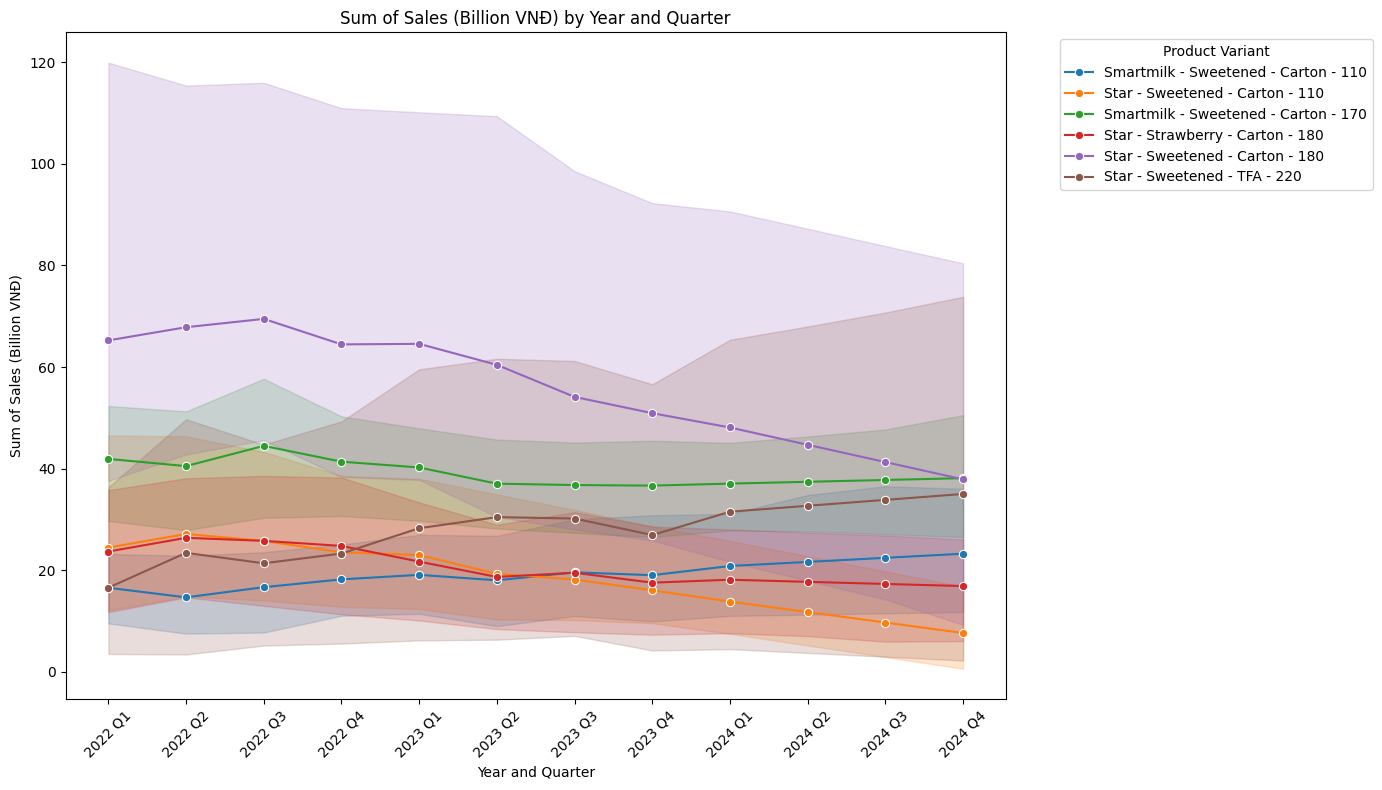

In [54]:
sales_ets['Year_Quarter'] = sales_ets['Year'].astype(str) + ' Q' + sales_ets['Quarter'].str[-1]

# Create a combined column for BRAND, FLAVOUR, PACKAGE, and BASESIZE to use as the legend
sales_ets['Combined'] = sales_ets['BRAND'] + ' - ' + sales_ets['FLAVOUR'] + ' - ' + sales_ets['PACKAGE'] + ' - ' + sales_ets['BASESIZE'].astype(str)

plt.figure(figsize=(14, 8))
sns.lineplot(data=sales_ets, x='Year_Quarter', y='Sales (Billion VNĐ)', hue='Combined', marker='o')

plt.title('Sum of Sales (Billion VNĐ) by Year and Quarter')
plt.xlabel('Year and Quarter')
plt.ylabel('Sum of Sales (Billion VNĐ)')
plt.legend(title='Product Variant', bbox_to_anchor=(1.05, 1), loc='upper left')
plt.xticks(rotation=45)

plt.tight_layout()
plt.show()

----
- Hai mặt hàng được ưa chuộng nhất là star sweetened 180 và smartmilk sweetened 170 đều giảm mạnh từ Q4 2022 ở trên đã phân tích là do sự dịch chuyển demand sang những sản phẩm organic và healthy hơn. Tuy nhiên, liệu Joyi có đã forecast được điều này và plan inventory một cách hiệu quả hay chưa? 
---

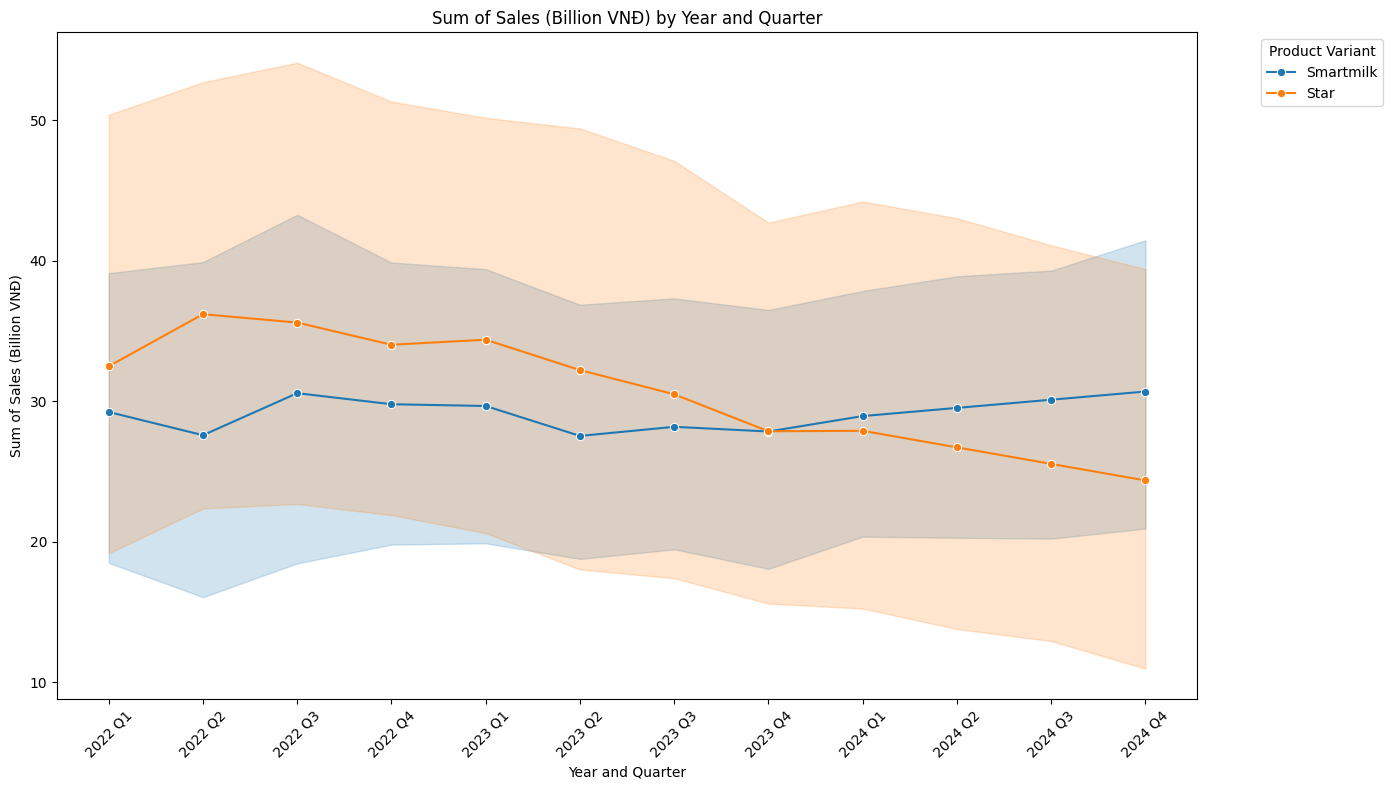

In [55]:
sales_ets['Year_Quarter'] = sales_ets['Year'].astype(str) + ' Q' + sales_ets['Quarter'].str[-1]

# Create a combined column for BRAND, FLAVOUR, PACKAGE, and BASESIZE to use as the legend

plt.figure(figsize=(14, 8))
sns.lineplot(data=sales_ets, x='Year_Quarter', y='Sales (Billion VNĐ)', hue='BRAND', marker='o')

plt.title('Sum of Sales (Billion VNĐ) by Year and Quarter')
plt.xlabel('Year and Quarter')
plt.ylabel('Sum of Sales (Billion VNĐ)')
plt.legend(title='Product Variant', bbox_to_anchor=(1.05, 1), loc='upper left')
plt.xticks(rotation=45)

plt.tight_layout()
plt.show()

Từ Q3’22 đã có sự sụt giảm về sales trong khi đó nhìn tổng total material purchased

In [121]:
pivot_table = sales_ets.pivot_table(values='Total Units Sold', index=["Product ID"], columns=['Year', 'Quarter'], aggfunc='sum')
pivot_table


Year        2022                    2023                    2024              \
Quarter       Q1    Q2    Q3    Q4    Q1    Q2    Q3    Q4    Q1    Q2    Q3   
Product ID                                                                     
SmSwC110   37.43 32.86 39.01 41.21 43.13 42.16 45.93 44.12 47.35 48.83 50.30   
SmSwC170   74.90 67.45 77.51 71.80 68.86 65.96 63.26 61.81 61.82 60.24 58.66   
StStrC180  29.47 30.88 29.71 28.07 26.59 21.69 22.93 21.15 20.84 20.19 19.55   
StSwC110   51.90 53.13 55.99 50.39 46.34 40.47 36.51 35.39 29.91 26.13 22.34   
StSwC180   93.22 89.38 92.05 86.84 83.42 85.22 74.84 71.12 67.60 63.02 58.44   
StSwTFA220 17.28 24.43 22.29 24.29 29.48 31.76 31.47 28.08 32.87 34.08 35.30   

Year              
Quarter       Q4  
Product ID        
SmSwC110   51.77  
SmSwC170   57.08  
StStrC180  18.91  
StSwC110   18.83  
StSwC180   55.31  
StSwTFA220 36.51

In [57]:
BOM = pd.read_excel("Milk case - Data Final (DM).xlsx",sheet_name="BOM")
BOM["name_joined"]=BOM["BRAND"]+BOM["FLAVOUR"]+BOM["PACKAGE"]+BOM["BASESIZE"].astype(str)

BOM["Product ID"]=BOM["name_joined"].map(joyi_mapping)
BOM.drop("name_joined",axis=1,inplace=True)

col_order(BOM,"Product ID","MATERIAL")

BOM

,BRAND,FLAVOUR,PACKAGE,BASESIZE,Product ID,MATERIAL,Standard No. Unit,Standard Price,Standard unit,Standard Cost Per Unit (Labor + Meterial + Overhead)
0,Smartmilk,Sweetened,Carton,110,SmSwC110,Additives,0.05,50000000,ton,1200000000
1,Smartmilk,Sweetened,Carton,110,SmSwC110,Whole milk,100000.00,6000,litre,1200000000
2,Smartmilk,Sweetened,Carton,110,SmSwC110,Skim milk,100000.00,3975,litre,1200000000
3,Smartmilk,Sweetened,Carton,170,SmSwC170,Additives,0.08,50000000,ton,1561800000
4,Smartmilk,Sweetened,Carton,170,SmSwC170,Whole milk,150000.00,6000,litre,1561800000
5,Smartmilk,Sweetened,Carton,170,SmSwC170,Skim milk,100000.00,3975,litre,1561800000
6,Star,Sweetened,Carton,110,StSwC110,Additives,0.03,50000000,ton,1295100000
7,Star,Sweetened,Carton,110,StSwC110,Whole milk,120000.00,6000,litre,1295100000
8,Star,Sweetened,Carton,110,StSwC110,Skim milk,90000.00,3975,litre,1295100000
9,Star,Strawberry,Carton,180,StStrC180,Additives,0.09,50000000,ton,2191500000


In [120]:
pivot_table = sales_ets.pivot_table(values='Total Units Sold', index='Product ID', columns=['Year', 'Quarter'], aggfunc='sum')

# Flatten the pivot table to have single level columns
pivot_table.columns = [f'{year} Q{quarter}' for year, quarter in pivot_table.columns]
pivot_table.reset_index(inplace=True)

# Merge the pivot table with BOM to get the Standard No. Unit
merged_data = BOM.merge(pivot_table, on='Product ID', how='left')

# Calculate material units total for each product ID
material_totals = {}
materials = BOM['MATERIAL'].unique()

for material in materials:
    material_data = merged_data[merged_data['MATERIAL'] == material].copy()
    for column in pivot_table.columns[1:]:  # Skip 'Product ID' column
        material_data[column] = material_data['Standard No. Unit'] * material_data[column]
    # Calculate the total row
    total_row = material_data[pivot_table.columns[1:]].sum(axis=0)
    total_row['Product ID'] = 'Total'
    total_row_df = pd.DataFrame(total_row).T
    material_data = pd.concat([material_data, total_row_df], ignore_index=True)
    material_totals[material] = material_data

# Displaying a sample of the data for each material
for material, data in material_totals.items():
    print(f"\nMaterial: {material}")
    print(tabulate(data, headers="keys", tablefmt="pretty"))



Material: Additives
+---+-----------+------------+---------+----------+------------+-----------+-------------------+-----------------+---------------+------------------------------------------------------+--------------------+--------------------+--------------------+--------------------+-----------------+--------------------+--------------------+--------------------+--------------------+--------------------+--------------------+--------------------+
|   |   BRAND   |  FLAVOUR   | PACKAGE | BASESIZE | Product ID | MATERIAL  | Standard No. Unit | Standard Price  | Standard unit | Standard Cost Per Unit (Labor + Meterial + Overhead) |      2022 QQ1      |      2022 QQ2      |      2022 QQ3      |      2022 QQ4      |    2023 QQ1     |      2023 QQ2      |      2023 QQ3      |      2023 QQ4      |      2024 QQ1      |      2024 QQ2      |      2024 QQ3      |      2024 QQ4      |
+---+-----------+------------+---------+----------+------------+-----------+-------------------+-------------

In [59]:
material_totals.get('Additives')

,BRAND,FLAVOUR,PACKAGE,BASESIZE,Product ID,MATERIAL,Standard No. Unit,Standard Price,Standard unit,Standard Cost Per Unit (Labor + Meterial + Overhead),...,2022 QQ3,2022 QQ4,2023 QQ1,2023 QQ2,2023 QQ3,2023 QQ4,2024 QQ1,2024 QQ2,2024 QQ3,2024 QQ4
0,Smartmilk,Sweetened,Carton,110,SmSwC110,Additives,0.05,50000000,ton,1200000000,...,1.950489,2.060440,2.156578,2.108034,2.296693,2.206152,2.367688,2.441265,2.514842,2.588419
3,Smartmilk,Sweetened,Carton,170,SmSwC170,Additives,0.08,50000000,ton,1561800000,...,6.200796,5.743976,5.508526,5.276664,5.061163,4.944900,4.945883,4.819394,4.692904,4.566415
6,Star,Sweetened,Carton,110,StSwC110,Additives,0.03,50000000,ton,1295100000,...,1.679764,1.511714,1.390051,1.214177,1.095238,1.061788,0.897371,0.783847,0.670323,0.564919
9,Star,Strawberry,Carton,180,StStrC180,Additives,0.09,50000000,ton,2191500000,...,2.673942,2.526588,2.392864,1.952337,2.063462,1.903194,1.875202,1.817461,1.759720,1.701979
13,Star,Sweetened,Carton,180,StSwC180,Additives,0.09,50000000,ton,1969200000,...,8.284648,7.815551,7.507588,7.669465,6.735166,6.400839,6.083729,5.671589,5.259449,4.977977
16,Star,Sweetened,TFA,220,StSwTFA220,Additives,0.13,50000000,ton,2558400000,...,2.897280,3.157605,3.832326,4.128347,4.090633,3.649906,4.272688,4.430594,4.588500,4.746407


In [60]:
summary_totals = {}

for material, data in material_totals.items():
    summary_data = data.sum(numeric_only=True).to_frame().T
    summary_data.insert(0, 'Material', material)
    grand_total = summary_data.sum(numeric_only=True).to_frame().T
    grand_total['Material'] = 'Grand Total'
    summary_data = pd.concat([summary_data, grand_total], ignore_index=True)
    summary_totals[material] = summary_data

# Displaying the summary data for each material
for material, data in summary_totals.items():
    print(f"\nMaterial: {material}")
    print(tabulate(data,headers="keys"))


Material: Additives
    Material       BASESIZE    Standard No. Unit    Standard Price     Standard Cost Per Unit (Labor + Meterial + Overhead)    2022 QQ1    2022 QQ2    2022 QQ3    2022 QQ4    2023 QQ1    2023 QQ2    2023 QQ3    2023 QQ4    2024 QQ1    2024 QQ2    2024 QQ3    2024 QQ4
--  -----------  ----------  -------------------  -----------------  ------------------------------------------------------  ----------  ----------  ----------  ----------  ----------  ----------  ----------  ----------  ----------  ----------  ----------  ----------
 0  Additives           970                 0.47              3e+08                                              1.0776e+10      22.709     22.6321     23.6869     22.8159     22.7879      22.349     21.3424     20.1668     20.4426     19.9642     19.4857     19.1461
 1  Grand Total         970                 0.47              3e+08                                              1.0776e+10      22.709     22.6321     23.6869     22.8159    

In [61]:
pivot_table = sales_ets.pivot_table(values='Sales (Billion VNĐ)', index='Product ID', columns=['Year', 'Quarter'], aggfunc='sum')

# Flatten the pivot table to have single level columns
pivot_table.columns = [f'{year} Q{quarter}' for year, quarter in pivot_table.columns]
pivot_table.reset_index(inplace=True)

# Merge the pivot table with BOM to get the Standard No. Unit
merged_data = BOM.merge(pivot_table, on='Product ID', how='left')

# Calculate material units total for each product ID
material_totals = {}
materials = BOM['MATERIAL'].unique()

for material in materials:
    material_data = merged_data[merged_data['MATERIAL'] == material].copy()
    for column in pivot_table.columns[1:]:  # Skip 'Product ID' column
        material_data[column] = material_data[column]  # No need to multiply by Standard No. Unit for sales
    material_totals[material] = material_data

# Create summary tables with only a line of sum values for each material and a grand total row
summary_totals = []

for material, data in material_totals.items():
    summary_data = data.sum(numeric_only=True).to_frame().T
    summary_data.insert(0, 'Material', material)
    grand_total = summary_data.sum(numeric_only=True).to_frame().T
    grand_total['Material'] = 'Grand Total'
    summary_data = pd.concat([summary_data, grand_total], ignore_index=True)
    summary_totals.append(summary_data)

# Displaying the summary data for each material
for summary_data in summary_totals:
    print(tabulate(summary_data,headers="keys",tablefmt="pretty"))

+---+-------------+----------+-------------------+-----------------+------------------------------------------------------+----------------+---------------+---------------+---------------+---------------+-------------------+---------------+-------------------+---------------+---------------+-------------------+---------------+
|   |  Material   | BASESIZE | Standard No. Unit | Standard Price  | Standard Cost Per Unit (Labor + Meterial + Overhead) |    2022 QQ1    |   2022 QQ2    |   2022 QQ3    |   2022 QQ4    |   2023 QQ1    |     2023 QQ2      |   2023 QQ3    |     2023 QQ4      |   2024 QQ1    |   2024 QQ2    |     2024 QQ3      |   2024 QQ4    |
+---+-------------+----------+-------------------+-----------------+------------------------------------------------------+----------------+---------------+---------------+---------------+---------------+-------------------+---------------+-------------------+---------------+---------------+-------------------+---------------+
| 0 |  Additi

In [62]:
sales_ets.pivot_table(columns=["Year","Quarter"],values="Sales (Billion VNĐ)",aggfunc="sum")

Year                       2022                                          2023  \
Quarter                      Q1          Q2          Q3          Q4        Q1   
Sales (Billion VNĐ)  753.974466  800.059684  814.469145  782.882532  787.6297   

Year                                                          2024  \
Quarter                      Q2          Q3         Q4          Q1   
Sales (Billion VNĐ)  735.988135  713.599072  668.80581  678.141803   

Year                                                    
Quarter                      Q2          Q3         Q4  
Sales (Billion VNĐ)  663.947225  649.752648  635.55807

---
- Trong khi sales đang giảm nhưng lại mua material vào lại nhiều => overstocking
- Sales giảm nhưng inventory increased và high material purchase => excess procurement and poor sales forecasting
---

Inventory turnover ratio= COGS/average inventory

In [63]:
pivot_table_cogs = sales_ets[sales_ets["Year"] < 2024].pivot_table(values='COGS', index=[], columns=['Year', 'Quarter'], aggfunc='sum')

# Calculate the average inventory for each quarter
average_inventory = pivot_table_cogs.copy()
for col in pivot_table_cogs.columns:
    if col == ('2022', 'Q1'):
        average_inventory[col] = 0  # No inventory for the first quarter of 2022
    else:
        previous_col = pivot_table_cogs.columns[pivot_table_cogs.columns.get_loc(col) - 1]
        average_inventory[col] = (pivot_table_cogs[previous_col] + pivot_table_cogs[col]) / 2

# Calculate the inventory turnover ratio
inventory_turnover_ratio = pivot_table_cogs / average_inventory
inventory_turnover_ratio = inventory_turnover_ratio.replace([float('inf'), float('-inf')], 0)

# Combine COGS, average inventory, and inventory turnover ratio into a single DataFrame
combined_result = pd.concat([
    pivot_table_cogs,
    average_inventory.rename(index={'COGS': 'Average Inventory'}),
    inventory_turnover_ratio.rename(index={'COGS': 'Inventory Turnover Ratio'})
])

combined_result

Year                            2022                                      \
Quarter                           Q1          Q2          Q3          Q4   
COGS                      521.471406  519.768666  543.779216  521.516399   
Average Inventory         487.508258  520.620036  531.773941  532.647807   
Inventory Turnover Ratio    1.069667    0.998365    1.022576    0.979102   

Year                            2023                                      
Quarter                           Q1          Q2          Q3          Q4  
COGS                      517.259026  502.615664  479.322971  453.545109  
Average Inventory         519.387712  509.937345  490.969318  466.434040  
Inventory Turnover Ratio    0.995902    0.985642    0.976279    0.972367

---
- Average inventory = **`(Begin inventory + end inventory)/2`**

- Tất cả các tỷ lệ được cung cấp đều dưới 1, điều này cho thấy rằng, trung bình hàng tồn kho được luân chuyển ít hơn một lần mỗi năm. Con số này thấp hơn đáng kể so với các tiêu chuẩn điển hình của ngành và cho thấy hàng tồn kho đang di chuyển rất chậm.
- Tỷ lệ doanh thu thấp có thể dẫn đến chi phí nắm giữ cao, khả năng lỗi thời và vốn bị ràng buộc có thể được sử dụng ở nơi khác.
- Tất cả các tỷ lệ được cung cấp đều dưới 1, điều này cho thấy rằng, trung bình hàng tồn kho được luân chuyển ít hơn một lần mỗi năm. Con số này thấp hơn đáng kể so với các tiêu chuẩn điển hình của ngành và cho thấy hàng tồn kho đang di chuyển rất chậm.
- Tỷ lệ doanh thu thấp có thể dẫn đến chi phí nắm giữ cao, khả năng lỗi thời và vốn bị ràng buộc có thể được sử dụng ở nơi khác.

---


## 9. Evaluate Suppliers

In [64]:
suppliers = pd.read_excel("Milk case - Data Final (DM).xlsx",sheet_name="suppliers")
suppliers

,Supplier,MATERIAL,Unit,Cost price 1,Minimum Qty 1,Cost price 2,Minimum Qty 2,Payment term,Leadtime (days)
0,ALPHAMILK,Additives,ton,50000000,No Require,49500000.00,50,COD - Cash on delivery,90
1,ALPHAMILK,Whole milk,litre,6000,No Require,5940.00,90000000,COD - Cash on delivery,90
2,ALPHAMILK,Skim milk,litre,3975,No Require,3935.25,70000000,COD - Cash on delivery,90
3,ALPHAMILK,Strawberry jam,ton,60000000,No Require,59400000.00,2,COD - Cash on delivery,90
4,QUANTAMILK,Additives,ton,50000000,Do not Supply,49500000.00,100,CWO - Cash with order,15
5,QUANTAMILK,Whole milk,litre,6000,Do not Supply,5940.00,100000000,CWO - Cash with order,15
6,QUANTAMILK,Skim milk,litre,3975,Do not Supply,3935.25,100000000,CWO - Cash with order,15
7,QUANTAMILK,Strawberry jam,ton,60000000,Do not Supply,59400000.00,5,CWO - Cash with order,15
8,SCRAFLMILK,Additives,ton,50000000,No Require,49500000.00,50,CWO - Cash with order,30
9,SCRAFLMILK,Whole milk,litre,6000,No Require,5940.00,90000000,CWO - Cash with order,30


In [66]:
inventory = pd.read_excel("Milk case - Data Final (DM).xlsx",sheet_name="inventory")

pd.set_option('display.float_format', '{:,.2f}'.format)

inventory

,MATERIAL,Unit,Cost Price per Unit,Q1'22,Q2'22,Q3'22,Q4'22,Q1'23,Q2'23,Q3'23,Q4'23
0,Additives,ton,50000000,45.81,47.95,46.28,48.15,50.88,46.99,40.09,49.02
1,Skim milk,litre,3975,"74,376,172.98","82,012,237.88","71,445,508.39","66,811,539.79","81,818,998.28","79,838,823.26","73,728,765.28","73,995,836.92"
2,Strawberry jam,ton,60000000,4.18,4.64,4.50,3.93,5.49,4.50,4.03,4.78
3,Whole milk,litre,6000,"96,198,745.85","102,389,383.93","107,633,568.72","97,845,140.18","89,845,787.09","94,957,444.70","105,492,079.40","104,109,149.81"


In [90]:
for i in sales_ets["Product ID"].unique():

    filtered_sales = sales_ets[(sales_ets["Product ID"]==i) & (sales_ets["Year"]==2024)].groupby("Quarter")["Sales (Billion VNĐ)"].sum()

    # Calculate additional metrics
    total_sales = filtered_sales.sum()
    avg_quarter_sales = filtered_sales.mean()
    avg_month_sales = total_sales / 12
    demand_std = filtered_sales.std()
    summary_df = pd.DataFrame(filtered_sales).reset_index()

    summary_rows = pd.DataFrame({
        'Quarter': ['Total', 'Avg Quarter', 'Avg Month', 'Demand Std'],
        'Sales (Billion VNĐ)': [total_sales, avg_quarter_sales, avg_month_sales, demand_std]
    })

    # Concatenate the results
    final_df = pd.concat([summary_df, summary_rows], ignore_index=True)

    print(f"Product line: {i}")
    print(tabulate(final_df,headers="keys",tablefmt="pretty") + "\n")

Product line: SmSwC110
+---+-------------+---------------------+
|   |   Quarter   | Sales (Billion VNĐ) |
+---+-------------+---------------------+
| 0 |     Q1      |  83.38275215799999  |
| 1 |     Q2      |  86.60905987999999  |
| 2 |     Q3      |  89.83536759200001  |
| 3 |     Q4      |    93.061675314     |
| 4 |    Total    |    352.888854944    |
| 5 | Avg Quarter |    88.222213736     |
| 6 |  Avg Month  | 29.407404578666668  |
| 7 | Demand Std  |  4.165145353851492  |
+---+-------------+---------------------+

Product line: StSwC110
+---+-------------+---------------------+
|   |   Quarter   | Sales (Billion VNĐ) |
+---+-------------+---------------------+
| 0 |     Q1      |    55.351749122     |
| 1 |     Q2      |    47.112474018     |
| 2 |     Q3      |    38.873198925     |
| 3 |     Q4      |    30.633923822     |
| 4 |    Total    | 171.97134588699998  |
| 5 | Avg Quarter | 42.992836471749996  |
| 6 |  Avg Month  | 14.330945490583332  |
| 7 | Demand Std  | 10.636858

### Safety Stock & Reorder Point Calculation

#### Method & Formula to base on:

Uncertainty on demand and Lead Time independent

$$
Z \times \sqrt{\text{Average LT} \times (\text{Demand Standard Deviation})^2 + (\text{Average Sale} \times \text{Lead Time Standard Deviation})^2}
$$


In [112]:
all_products_summary = pd.DataFrame()

for product_id in sales_ets["Product ID"].unique():
    filtered_sales = sales_ets[(sales_ets["Product ID"]==product_id) & (sales_ets["Year"]==2024)].groupby("Quarter")["Total Units Sold"].sum()

    # Calculate additional metrics
    total_sales = filtered_sales.sum()
    avg_quarter_sales = filtered_sales.mean()
    avg_month_sales = total_sales / 12
    demand_std = filtered_sales.std()
    summary_df = pd.DataFrame(filtered_sales).reset_index()

    summary_rows = pd.DataFrame({
        'Quarter': ['Total', 'Avg Quarter', 'Avg Month', 'Demand Std'],
        'Total Units Sold': [total_sales, avg_quarter_sales, avg_month_sales, demand_std]
    })

    # Concatenate the results
    final_df = pd.concat([summary_df, summary_rows], ignore_index=True)
    final_df.columns = ['Quarter', product_id]

    if all_products_summary.empty:
        all_products_summary = final_df
    else:
        all_products_summary = pd.merge(all_products_summary, final_df, on='Quarter', how='outer')

all_products_summary

,Quarter,SmSwC110,StSwC110,SmSwC170,StStrC180,StSwC180,StSwTFA220
0,Avg Month,16.52,8.10,19.82,6.62,20.36,11.56
1,Avg Quarter,49.56,24.30,59.45,19.87,61.09,34.69
2,Demand Std,1.90,4.78,2.04,0.83,5.37,1.57
3,Q1,47.35,29.91,61.82,20.84,67.60,32.87
4,Q2,48.83,26.13,60.24,20.19,63.02,34.08
5,Q3,50.30,22.34,58.66,19.55,58.44,35.30
6,Q4,51.77,18.83,57.08,18.91,55.31,36.51
7,Total,198.24,97.22,237.81,79.49,244.36,138.76


In [98]:
lead_time_supp = pd.DataFrame({"Delivery":[1,2,3],"Lead_time":[15,30,90]})
lead_time_supp["Lead_time_quarter"]=lead_time_supp["Lead_time"]/90
lead_time_supp

,Delivery,Lead_time,Lead_time_quarter
0,1,15,0.17
1,2,30,0.33
2,3,90,1.00


In [103]:
avg_lead_time = lead_time_supp["Lead_time"].mean()
max_lead_time = lead_time_supp["Lead_time"].max()
lt_stdv = lead_time_supp["Lead_time"].std()

# Append rows to the DataFrame
summary_rows = pd.DataFrame({
    "Delivery": ["Avg lead time", "Max lead time", "LT stdv"],
    "Lead_time": [avg_lead_time, max_lead_time, lt_stdv],
    "Lead_time_quarter": [avg_lead_time / 90, max_lead_time / 90, lt_stdv / 90]
})

final_lead_time_supp = pd.concat([lead_time_supp, summary_rows], ignore_index=True)

final_lead_time_supp

,Delivery,Lead_time,Lead_time_quarter
0,1,15.00,0.17
1,2,30.00,0.33
2,3,90.00,1.00
3,Avg lead time,45.00,0.50
4,Max lead time,90.00,1.00
5,LT stdv,39.69,0.44


In [108]:
sales_ets["Unit Price"] = sales_ets["Sales (Billion VNĐ)"]/sales_ets["Total Units Sold"]
product_unit_price=sales_ets.groupby("Product ID")["Unit Price"].mean()

product_unit_price

Product ID
SmSwC110     1.75
SmSwC170     2.39
StStrC180    3.46
StSwC110     1.87
StSwC180     3.05
StSwTFA220   3.84
Name: Unit Price, dtype: float64

---
- Tính safety stock và reorder point cho từng product line & materials cho mỗi Quý 2024
---

In [113]:
avg_lead_time = final_lead_time_supp.loc[3, 'Lead_time_quarter']
lead_time_stdv = final_lead_time_supp.loc[5, 'Lead_time_quarter']
avg_lead_time_quarter = final_lead_time_supp.loc[3, 'Lead_time_quarter']

# Calculate safety stock and reorder point for each product
Z = 1.64

results = []

for product in all_products_summary.columns[1:]:
    avg_quarter_sales = all_products_summary.loc[1, product]
    demand_std = all_products_summary.loc[2, product]
    
    safety_stock = Z * ((avg_lead_time * (demand_std ** 2)) + (avg_quarter_sales * (lead_time_stdv ** 2))) ** 0.5
    reorder_point = safety_stock + (avg_quarter_sales * avg_lead_time_quarter)
    
    results.append([product, safety_stock, reorder_point])

safety_stock_reorder_point = pd.DataFrame(results, columns=['Product', 'Safety Stock', 'Reorder Point'])

print(safety_stock_reorder_point)

      Product  Safety Stock  Reorder Point
0    SmSwC110          5.55          30.33
1    StSwC110          6.59          18.74
2    SmSwC170          6.06          35.78
3   StStrC180          3.36          13.30
4    StSwC180          8.41          38.95
5  StSwTFA220          4.63          21.98


In [126]:
safety_stock_materials = []

for product_id in safety_stock_reorder_point['Product']:
    # Find corresponding materials for the product
    product_bom = BOM[BOM['Product ID'] == product_id]
    safety_stock = safety_stock_reorder_point[safety_stock_reorder_point['Product'] == product_id]['Safety Stock'].values[0]
    
    for _, row in product_bom.iterrows():
        material_safety_stock = safety_stock * row['Standard No. Unit']
        safety_stock_materials.append({
            'Material': row['MATERIAL'],
            'Unit': row['Standard unit'],
            'Safety Stock': material_safety_stock
        })

safety_stock_materials_df = pd.DataFrame(safety_stock_materials)

# Aggregate the safety stock for each material
safety_stock_materials_agg = safety_stock_materials_df.groupby(['Material', 'Unit']).sum().reset_index()

safety_stock_materials_agg

,Material,Unit,Safety Stock
0,Additives,ton,2.62
1,Skim milk,litre,"4,336,570.29"
2,Strawberry jam,ton,0.34
3,Whole milk,litre,"5,495,581.98"


In [130]:
pivot_table = sales_ets.pivot_table(values='Total Units Sold', index='Product ID', columns=['Year', 'Quarter'], aggfunc='sum')

# Flatten the pivot table to have single level columns
pivot_table.columns = [f'{year} Q{quarter}' for year, quarter in pivot_table.columns]
pivot_table.reset_index(inplace=True)

# Merge the pivot table with BOM to get the Standard No. Unit
merged_data = BOM.merge(pivot_table, on='Product ID', how='left')

# Calculate material units total for each product ID
material_totals = {}
materials = BOM['MATERIAL'].unique()

for material in materials:
    material_data = merged_data[merged_data['MATERIAL'] == material].copy()
    for column in pivot_table.columns[1:]:  # Skip 'Product ID' column
        material_data[column] = material_data['Standard No. Unit'] * material_data[column]
    # Calculate the total row
    total_row = material_data[pivot_table.columns[1:]].sum(axis=0)
    total_row['Product ID'] = 'Total'
    total_row_df = pd.DataFrame(total_row).T
    material_data = pd.concat([material_data, total_row_df], ignore_index=True)
    material_totals[material] = material_data


# Calculate the final result for 2024 including safety stock
final_result = []
for material, data in material_totals.items():
    total_2024 = data[[col for col in data.columns if '2024 Q' in col]].sum(axis=0)/2
    safety_stock = safety_stock_material_result[safety_stock_material_result['Material'] == material]['Safety Stock'].values[0]
    total_2024_with_safety = total_2024 + safety_stock
    final_result.append({
        'Material': material,
        'Unit': safety_stock_material_result[safety_stock_material_result['Material'] == material]['Unit'].values[0],
        'Total 2024 with Safety Stock': total_2024_with_safety
    })

# Convert to DataFrame
final_result_df = pd.DataFrame(final_result)

# Display the final result DataFrame to the user
print(tabulate(final_result_df, headers="keys", tablefmt="pretty"))

+---+----------------+-------+------------------------------+
|   |    Material    | Unit  | Total 2024 with Safety Stock |
+---+----------------+-------+------------------------------+
| 0 |   Additives    |  ton  |       2024 QQ1   23.06       |
|   |                |       |       2024 QQ2   22.58       |
|   |                |       |       2024 QQ3   22.11       |
|   |                |       |       2024 QQ4   21.77       |
|   |                |       |        dtype: object         |
| 1 |   Whole milk   | litre |   2024 QQ1   46,943,896.82   |
|   |                |       |   2024 QQ2   45,739,055.38   |
|   |                |       |   2024 QQ3   44,534,213.93   |
|   |                |       |   2024 QQ4   43,623,187.93   |
|   |                |       |        dtype: object         |
| 2 |   Skim milk    | litre |   2024 QQ1   36,868,070.21   |
|   |                |       |   2024 QQ2   35,985,006.83   |
|   |                |       |   2024 QQ3   35,101,943.45   |
|   |   

---
- Có thể thấy số material còn lại từ Q4’23 còn rất nhiều so với lượng material cần thiết cho sản xuất ở Q1’24 điều này khiến holding cost lên tới  46,076,308,880.60  vnd. Tuy nhiên chúng tôi quyết định sẽ giữ toàn bộ số nguyên liệu này thay vì giữ một phần và mua mới. Vì: chúng tôi suggest Joyi: thay vì tiếp tục phát triển các dòng sản phẩm hiện có thì nên launch organic milk, do đó cần allocate nhiều capital hơn cho sp mới. 



<str> Giữ nguyên inventory </str> <br>
- Vì ở trên chúng tôi đã phân tích Joyi nên phát triển sxuat thêm mặt hàng Organic, favorably Less sugar. Thêm vào đó, các sp hiện tại của Joyi có xu hướng downtrend nên chúng tôi sẽ plan inventory dựa trên predicted sales + safety stock (chứ ko dự trữ quá nhiều material) của từng SKU để minimize cost (vẫn đảm bảo stock availability) và dành nhiều resources, capital hơn để phát triển sản phẩm mới
---

In [136]:
Q1_invent_cost = pd.read_excel("4 bảng.xlsx",sheet_name="Q1")

Q2_invent_cost = pd.read_excel("4 bảng.xlsx",sheet_name="Q2")


print("Q1 invent cost summary (safety stock included): \n" + tabulate(Q1_invent_cost,headers="keys",tablefmt="pretty") + "\n")

print("Q2 invent cost summary (safety stock included): \n" + tabulate(Q2_invent_cost,headers="keys",tablefmt="pretty"))

Q1 invent cost summary (safety stock included): 
+---+------------------------------------------------+-----------------+-----------------------------------+-----------------+----------------+
|   |                     Excess                     |    Additives    |            Whole milk             |   Skim milk     | Strawberry jam |
+---+------------------------------------------------+-----------------+-----------------------------------+-----------------+----------------+
| 0 |                       Q1                       |   33.90801955   |            72002459.69            |   42305858.39   |      2.36      |
| 1 |                      Cost                      |  1695400977.7   |          432014758137.13          | 168165787114.75 |  141441950.37  |
| 2 |                      Sum                       | 602017388179.95 |                nan                |       nan       |      nan       |
| 3 | Holding cost (20% each year = 5% each quarter) |  30100869409.0  |  Total cost: 1

---
- => Có thể thấy số hàng tồn của tất cả các material không đủ để sản xuất hết cho quý 3 do đó cần phải order. Để xác định được cần order bao nhiêu, chọn supplier nào trước hết cần xác định SKU nào cần tập trung
---

In [145]:
sum_sales_joyi = sales_ets[sales_ets["Year"]!=2022].pivot_table(index="Product ID",columns="Year",values="Sales (Billion VNĐ)",aggfunc="sum")

sum_sales_joyi["Relative Market Share"] = sum_sales_joyi[2024]/sum_sales_joyi[2024].max()

sum_sales_joyi["Growth Rate"] = sum_sales_joyi[2024]/sum_sales_joyi[2023]

sum_sales_joyi["Internal Market Share"] = sum_sales_joyi[2024]/sum_sales_joyi[2024].sum()


sum_sales_joyi

Year,2023,2024,Relative Market Share,Growth Rate,Internal Market Share
Product ID,,,,,
SmSwC110,303.11,352.89,0.51,1.16,0.13
SmSwC170,602.98,601.61,0.87,1.00,0.23
StStrC180,309.93,280.36,0.41,0.90,0.11
StSwC110,306.23,171.97,0.25,0.56,0.07
StSwC180,920.28,688.07,1.00,0.75,0.26
StSwTFA220,463.50,532.50,0.77,1.15,0.20


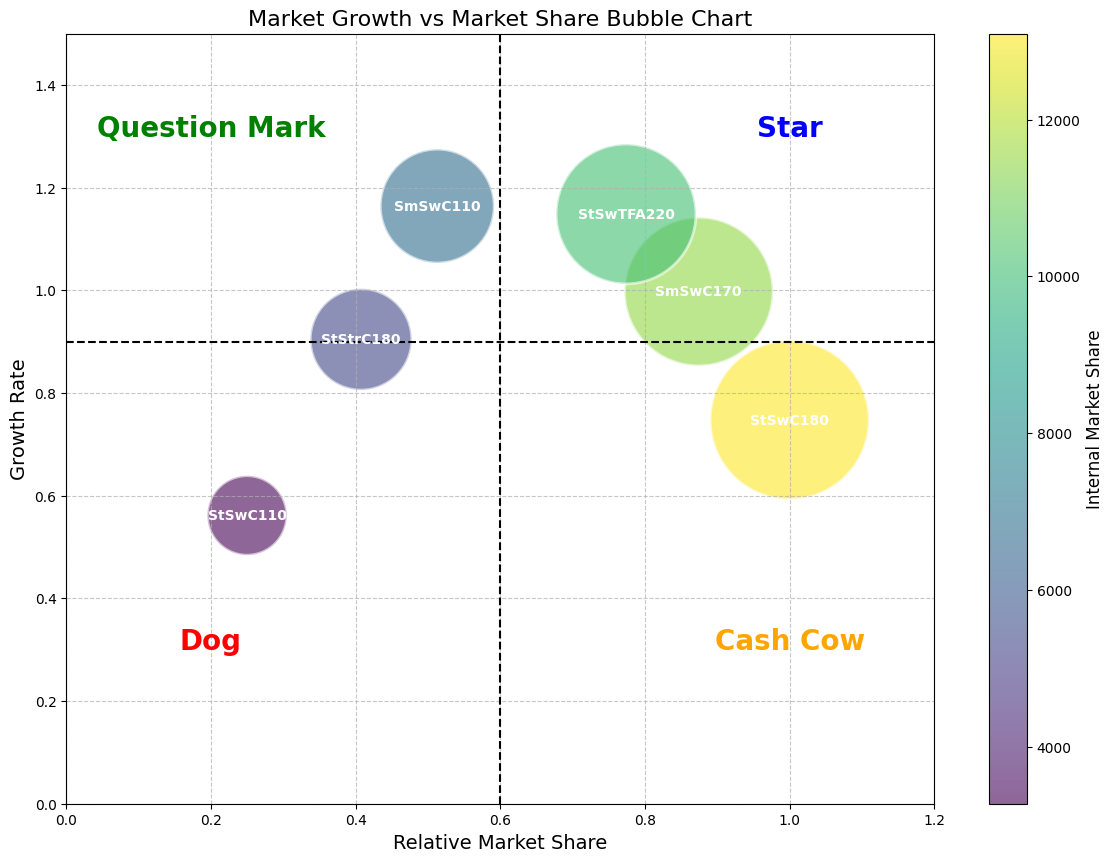

In [ ]:
import matplotlib.pyplot as plt

x = sum_sales_joyi["Relative Market Share"]
y = sum_sales_joyi["Growth Rate"]
size = sum_sales_joyi["Internal Market Share"] * 50000  # Adjusting size for better visualization
labels = sum_sales_joyi.index

plt.figure(figsize=(14, 10))
scatter = plt.scatter(x, y, s=size, alpha=0.6, c=size, cmap='viridis', edgecolors='w', linewidth=2)

for i, label in enumerate(labels):
    plt.text(x[i], y[i], label, fontsize=10, ha='center', va='center', color='white', weight='bold')

plt.title('Market Growth vs Market Share Bubble Chart', fontsize=16)
plt.xlabel('Relative Market Share', fontsize=14)
plt.ylabel('Growth Rate', fontsize=14)

plt.grid(True, linestyle='--', alpha=0.7)

cbar = plt.colorbar(scatter)
cbar.set_label('Internal Market Share', fontsize=12)

plt.xlim(0, 1.2) 
plt.ylim(0, 1.5) 

plt.text(0.2, 1.3, 'Question Mark', fontsize=20, ha='center', color='green',fontweight='bold')
plt.text(0.2, 0.3, 'Dog', fontsize=20, ha='center', color='red',fontweight='bold')
plt.text(1, 1.3, 'Star', fontsize=20, ha='center', color='blue',fontweight='bold')
plt.text(1, 0.3, 'Cash Cow', fontsize=20, ha='center', color='orange',fontweight='bold')

# Add T cross lines in the middle
plt.axhline(y=0.9, color='black', linestyle='--')
plt.axvline(x=0.6, color='black', linestyle='--')

plt.show()


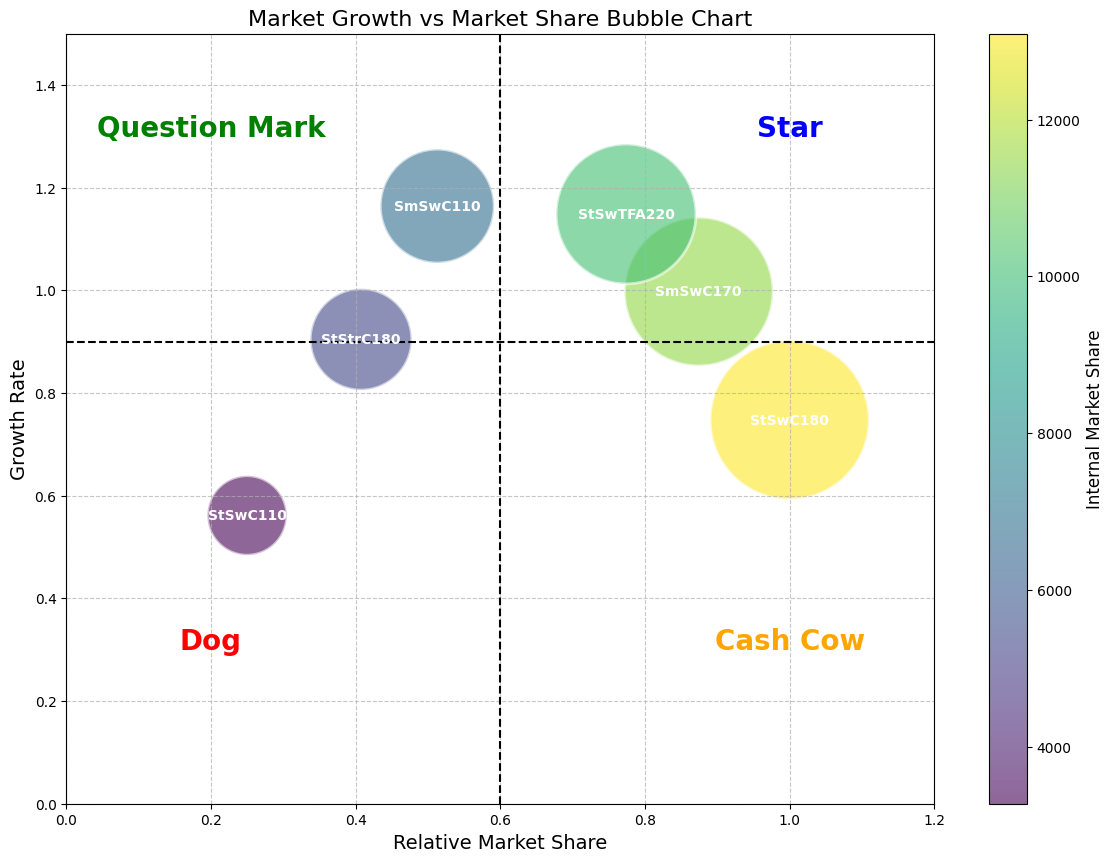

In [ ]:
import matplotlib.pyplot as plt

x = sum_sales_joyi["Relative Market Share"]
y = sum_sales_joyi["Growth Rate"]
size = sum_sales_joyi["Internal Market Share"] * 50000  # Adjusting size for better visualization
labels = sum_sales_joyi.index

plt.figure(figsize=(14, 10))
scatter = plt.scatter(x, y, s=size, alpha=0.6, c=size, cmap='viridis', edgecolors='w', linewidth=2)

for i, label in enumerate(labels):
    plt.text(x[i], y[i], label, fontsize=10, ha='center', va='center', color='white', weight='bold')

plt.title('Market Growth vs Market Share Bubble Chart', fontsize=16)
plt.xlabel('Relative Market Share', fontsize=14)
plt.ylabel('Growth Rate', fontsize=14)

plt.grid(True, linestyle='--', alpha=0.7)

cbar = plt.colorbar(scatter)
cbar.set_label('Internal Market Share', fontsize=12)

plt.xlim(0, 1.2) 
plt.ylim(0, 1.5) 

plt.text(0.2, 1.3, 'Question Mark', fontsize=20, ha='center', color='green',fontweight='bold')
plt.text(0.2, 0.3, 'Dog', fontsize=20, ha='center', color='red',fontweight='bold')
plt.text(1, 1.3, 'Star', fontsize=20, ha='center', color='blue',fontweight='bold')
plt.text(1, 0.3, 'Cash Cow', fontsize=20, ha='center', color='orange',fontweight='bold')

# Add T cross lines in the middle
plt.axhline(y=0.9, color='black', linestyle='--')
plt.axvline(x=0.6, color='black', linestyle='--')

plt.show()


/ **Note** /:
- `Star`: Nhu cầu cao đòi hỏi phải đặt hàng lại thường xuyên để đáp ứng nhu cầu, giảm chi phí lưu kho trên mỗi chu kỳ nhưng lại có chi phí đặt hàng thường xuyên.
- `Cash Cows`: Cân bằng tần suất đặt hàng lại để duy trì khả năng sinh lời và chi phí nắm giữ ổn định.
- `?`: Quản lý hàng tồn kho linh hoạt, với các điểm đặt hàng lại linh hoạt và lượng hàng tồn kho an toàn dựa trên hiệu suất.
- `Dog`: Giảm thiểu điểm đặt hàng lại và sắp xếp lại không thường xuyên để giữ chi phí ở mức thấp.


# 10. Planning + Impact

In [ ]:
file_path = 'C:/Users/Admin/Desktop/Milk case - Data Final (2).xlsx'
sales_data_updated = pd.read_excel(file_path, sheet_name='sales+ets predict')
bom_data_updated = pd.read_excel(file_path, sheet_name='BOM')

sales_data_2024_updated = sales_data_updated[sales_data_updated['Year'] == 2024]

merged_data_updated = pd.merge(sales_data_2024_updated, bom_data_updated, on=['BRAND', 'FLAVOUR', 'PACKAGE', 'BASESIZE'], how='left')

merged_data_updated['Total Units Needed'] = merged_data_updated['Total Units Sold'] * (merged_data_updated['Standard No. Unit'])

final_table_updated = merged_data_updated[['Product ID', 'Quarter', 'MATERIAL', 'Standard No. Unit', 'Total Units Needed']]
final_table_updated2 = merged_data_updated[['Product ID', 'Quarter', 'MATERIAL', 'Total Units Needed']]

final_table_updated = final_table_updated.groupby(['Product ID', 'Quarter', 'MATERIAL']).sum().reset_index()
final_table_updated2 = final_table_updated2.groupby(['Product ID', 'Quarter', 'MATERIAL']).sum().reset_index()

print("Total Units Needed Table:")
print(tabulate(final_table_updated2,headers="keys",tablefmt="pretty") + "\n")




Total Units Needed Table:
+----+------------+---------+----------------+--------------------+
|    | Product ID | Quarter |    MATERIAL    | Total Units Needed |
+----+------------+---------+----------------+--------------------+
| 0  |  SmSwC110  |   Q1    |   Additives    |   2.36768816145    |
| 1  |  SmSwC110  |   Q1    |   Skim milk    |    4735376.3229    |
| 2  |  SmSwC110  |   Q1    |   Whole milk   |    4735376.3229    |
| 3  |  SmSwC110  |   Q2    |   Additives    |   2.44126519695    |
| 4  |  SmSwC110  |   Q2    |   Skim milk    |    4882530.3939    |
| 5  |  SmSwC110  |   Q2    |   Whole milk   |    4882530.3939    |
| 6  |  SmSwC110  |   Q3    |   Additives    | 2.5148422319500003 |
| 7  |  SmSwC110  |   Q3    |   Skim milk    |    5029684.4639    |
| 8  |  SmSwC110  |   Q3    |   Whole milk   |    5029684.4639    |
| 9  |  SmSwC110  |   Q4    |   Additives    |   2.58841926735    |
| 10 |  SmSwC110  |   Q4    |   Skim milk    | 5176838.534700001  |
| 11 |  SmSwC110  |   

In [ ]:
merged_data = pd.merge(final_table_updated, safety_stock_reorder_point, on=['Product ID'], how='left')

merged_data['Total Units Needed Safety Stock'] = merged_data['Safety Stock'] * merged_data['Standard No. Unit']

final_table = merged_data[['Product ID', 'Quarter', 'MATERIAL', 'Total Units Needed Safety Stock']]

final_table = final_table.groupby(['Product ID', 'Quarter', 'MATERIAL']).sum().reset_index()

print("Total Units Needed Safety Stock Table:")
print(tabulate(final_table,headers="keys",tablefmt="pretty") + "\n")

Total Units Needed Safety Stock Table:
+----+------------+---------+----------------+---------------------------------+
|    | Product ID | Quarter |    MATERIAL    | Total Units Needed Safety Stock |
+----+------------+---------+----------------+---------------------------------+
| 0  |  SmSwC110  |   Q1    |   Additives    |       1.1094646551403669        |
| 1  |  SmSwC110  |   Q1    |   Skim milk    |       2218929.3102807337        |
| 2  |  SmSwC110  |   Q1    |   Whole milk   |       2218929.3102807337        |
| 3  |  SmSwC110  |   Q2    |   Additives    |       1.1094646551403669        |
| 4  |  SmSwC110  |   Q2    |   Skim milk    |       2218929.3102807337        |
| 5  |  SmSwC110  |   Q2    |   Whole milk   |       2218929.3102807337        |
| 6  |  SmSwC110  |   Q3    |   Additives    |       1.1094646551403669        |
| 7  |  SmSwC110  |   Q3    |   Skim milk    |       2218929.3102807337        |
| 8  |  SmSwC110  |   Q3    |   Whole milk   |       2218929.310280733

# Skim milk
Đối với StStr180, SmSw110 và StSw110:
- Dành số skim milk còn ở cuối Q2 cho sản xuất StStr180, SmSw110 và StSw110 ở Q3 tổng là: 11,833,220.38
- Tổng skim milk cần ở Q4: 11,856,349.95

Còn đối với SmSw170, StSw180, StSw220 đây là những mặt hàng có market share và growth rate lớn.

Tổng số skim milk cần ở Q3: 17,149,409.34

Tổng skim milk cần ở Q4: 16,800,017.60

Tất cả supplier đều bán giá rẻ với số lượng tối thiểu là 70,000,000 nên chúng ta có 2 sự lựa chọn:
1, Mua cho từng quý với giá đắt hơn 1 chút nhưng ko bị required min quantity.
2, Mua 1 lúc 70,000,000 với giá rẻ.
 
Cost option 2 lớn hơn rất nhiều (còn chưa tính holding cost) => chọn option 1 cụ thể:
1, Mua 17,500,000 lit skim milk từ đầu Q2 ở Alphamilk.
1, Mua 29,000,000 lit skim milk từ đầu Q3 ở Alphamilk.
/Note/ Chọn alphamilk vì nó COD có thể check chất lượng hàng rồi mới thanh toán. Trong quá trình sản xuất nếu nhu cầu của nhóm star và cow tăng đột ngột thì có thể chọn Scraftmilk vì không yêu cầu minimum quantity, tuy nhiên nếu cần gấp hơn 30 ngày thì chọn Quantamilk nhưng phải mua ít nhất 100,000 lit và chịu holding cost rất lớn.

# Strawberry jam
Đây là một mặt hàng nằm giữa Dog và Question mark do đó market share khá thấp và market growth trung bình nên chúng ta không cần đặt hàng liên tục và đặt quá nhiều để giảm thiểu holding cost và order cost.

Đến đầu quý 3 strawberry jam không còn đủ để sản xuất + safety stock nên để đảm bảo được stock volume thì cần order từ trước Q3. 

Như đã nêu ở trên mặt hàng này không quá quan trọng và chúng ta cần giảm thiểu chi phí nhất có thể nên supplier Alphamilk là hợp lý nhất vì:

- COD: đảm bảo đc chất lượng mới thanh toán

- Minimum required quantity thấp => có thể deal nếu đặt hàng lâu dài hoặc đặt hàng với số lượng lớn thì giảm price per unit

Số lượng Strawberry jam cần cho Q3 và Q4 (+safety stock) lần lượt là 2.3 và 2.23


In [ ]:
TH1 = pd.read_excel("C:/Users/Admin/Desktop/Milk case - Data Final (2).xlsx",sheet_name="Sheet1")
print("TH1: Đặt 1 lần 5 ton từ đầu Q2")
print(tabulate(TH1,headers="keys",tablefmt="pretty") + "\n")

TH1: Đặt 1 lần 5 ton từ đầu Q2
+---+-----+----------------+-------------+-------------------+--------------+-------------+
|   | SUM | Strawberry jam | Order cost  | Inventory cuối kì | Holding cost | Total cost  |
+---+-----+----------------+-------------+-------------------+--------------+-------------+
| 0 | Q3  |      2.29      | 297,000,000 |    2.711574852    | 8,134,724.56 | 306,579,449 |
| 1 | Q4  |      2.23      |     nan     |    0.481574852    | 1,444,724.56 |     nan     |
+---+-----+----------------+-------------+-------------------+--------------+-------------+



In [ ]:
TH2 = pd.read_excel("C:/Users/Admin/Desktop/Milk case - Data Final (2).xlsx",sheet_name="Sheet2")
print("TH2: Đặt 2 lần: đầu Q2 và đầu Q3 mỗi lần đặt 2.5 tấn")
print(tabulate(TH2,headers="keys",tablefmt="pretty") + "\n")
print("=> Chọn option 2")

TH2: Đặt 2 lần: đầu Q2 và đầu Q3 mỗi lần đặt 2.5 tấn
+---+-----+----------------+-----------------------+-------------------+--------------+----------------+
|   | SUM | Strawberry jam | Order cost (2.5 each) | Inventory cuối kì | Holding cost |   Total cost   |
+---+-----+----------------+-----------------------+-------------------+--------------+----------------+
| 0 | Q3  |      2.29      |      148,500,000      |    0.211574852    |  634,724.56  | 299,079,449.11 |
| 1 | Q4  |      2.23      |      148,500,000      |    0.481574852    | 1,444,724.56 |      nan       |
+---+-----+----------------+-----------------------+-------------------+--------------+----------------+

=> Chọn option 2


# Whole milk 

Số whole milk còn lại cuối Q3: 11,734,587.24 => holding cost Q3 (whole milk):  3,520,376,172 

Tuy nhiên Q4 cần: 29,034,585.05 => Cần order thêm: 17,299,997.81 => order 18,000,000 lit từ alphamilk ở đầu Q3 => order cost:  108,000,000,000 vnd

Note:

Nhóm dog, question mark ở Q4 cần: 12,234,567.46

=> Lấy số whole milk còn lại từ Q3 sản xuất cho nhóm sản phẩm này tuy nhiên còn thiếu 499,980.22 sẽ lấy từ order mới


# Additives

Số additives còn lại cuối Q3: 5.56267381 => holding cost Q3 (additives):  278,133,690.50 

Tuy nhiên Q4 cần: 13.66630314 => cần order thêm: 8.10362933 => order 8.5 tấn từ alphamilk đầu Q3 => order cost:  425,000,000 

/Note/:

Nhóm dog, question mark ở Q4 cần: 5.266294347

=> Lấy số additives còn lại từ Q3 sản xuất cho nhóm sp này còn order mới thì để dùng cho sản xuất nhóm star, cow


In [ ]:
evarcm = pd.read_excel("C:/Users/Admin/Downloads/Inventory-plan.xlsx",sheet_name="Sheet3")
print(tabulate(evarcm,headers="keys",tablefmt="pretty") + "\n")

+---+---------+------------+--------------------+--------------+-------------------+-------------------+--------------+-------------------+
|   | Quarter | Unnamed: 1 |    Holding cost    |  Order cost  |    Labour cost    |    Total cost     |    Sales     |      Profit       |
+---+---------+------------+--------------------+--------------+-------------------+-------------------+--------------+-------------------+
| 0 |   Q1    |    nan     | 24585046099.909206 |      0       | 75829948553.68199 | 100414994653.5912 | 678141802938 | 577726808284.4088 |
| 1 |   Q2    |    nan     | 3632133097.314407  |      0       |  73676549441.298  | 77308682538.61241 | 663947225366 | 586638542827.3876 |
| 2 |   Q3    |    nan     | 99938574.29043335  | 337646000000 |  63927891393.138  | 401673829967.4284 | 649752647815 | 248078817847.5716 |
| 3 |   Q4    |    nan     | 209360689.06747657 | 402386000000 | 69904676269.0915  | 472500036958.159  | 635558070253 | 163058033294.841  |
+---+---------+-----

# 11. Tổng kết recommendation + Priority


# Evaluate Recommendation

Q1: Dùng inventory từ Q4'23

Q2:
1. Mua 34,100,000 lit skim milk ở đầu Q2 cho sản xuất Q3 ở Alphamilk với giá gốc (trả tiền ở Q3)
2. Mua 2.5 tấn strawberry jam ở đầu Q2 cho sản xuất Q3 ở Alphamilk với giá discount (trả tiền ở Q3)
3. Mua 33,500,000 lit whole milk từ Alphamilk ở đầu Q2 cho sản xuất Q3 ở Alphamilk với giá gốc (trả tiền ở Q3)
4. Mua 19 tấn additives từ Alphamilk ở đầu Q2 cho sản xuất Q3 ở Alphamilk với giá gốc (trả tiền ở Q3)

Q3:
1. Mua 34,500,000 lit skim milk ở đầu Q3 cho sản xuất Q4 ở Alphamilk với giá gốc (trả tiền ở Q4)
2. Mua 2.5 tấn strawberry jam ở đầu Q3 cho sản xuất Q4 ở Alphamilk với giá discount (trả tiền ở Q4)
3. Mua 44,000,000 lit whole milk từ Alphamilk ở đầu Q3 cho sản xuất Q4 ở Alphamilk với giá gốc (trả tiền ở Q4)
4. Mua 22 tấn additives từ Alphamilk ở đầu Q3 cho sản xuất Q4 ở Alphamilk với giá gốc (trả tiền ở Q4)

Q4: Lập kế hoạch tồn kho cho Q1'25

# Pros and cons
Vì ở đây chúng tôi đặt tất cả material ở Alphamilk để tối ưu được chi phí và có thể check quality của hàng trước khi trả tiền nên sẽ có 1 số pros and cons như sau:
1, Pros
- Mua nhiều, lâu dài thì có thể sẽ đàm phán được giá discount nhiều hơn
- Quản lý supplier đơn giản hơn và có mối quan hệ hợp tác chặt chẽ hơn
- Logistic efficiency
2, Cons
- Tăng rủi ro: sự phụ thuộc vào một nhà cung cấp duy nhất làm tăng nguy cơ gián đoạn chuỗi cung ứng do các vấn đề cụ thể của nhà cung cấp như bất ổn tài chính, vấn đề sản xuất hoặc thiên tai.
- Bất kỳ sai sót vận chuyển nào từ phía nhà cung cấp đều có thể khiến hoạt động sản xuất bị đình trệ và ảnh hưởng đến toàn bộ hoạt động kinh doanh.

# Biện pháp
Để giảm thiểu rủi ro nêu trên, chúng tôi đưa ra một số biện pháp:

Đánh giá và giám sát nhà cung cấp:

- Thường xuyên đánh giá theo tháng tình hình tài chính và sự ổn định trong hoạt động của nhà cung cấp.

- Tiến hành kiểm tra và đánh giá định kỳ để đảm bảo khả năng liên tục đáp ứng yêu cầu của doanh nghiệp của nhà cung cấp.

- Đặc biệt kiểm tra tình hình kinh doanh của supplier trước ngày order 1 tháng

Chỉ số chất lượng: 

- Thiết lập các metrics đánh giá chất lượng và tiêu chuẩn hiệu suất rõ ràng, đồng thời đưa chúng vào hợp đồng kèm theo các hình phạt nếu không tuân thủ.

- Thương lượng để giảm thời gian lead time (trong trường hợp xảy ra vấn đề khi vận chuyển => ko kịp gửi hàng đúng hạn) bằng cách:

Chia sẻ dự báo: 
- Chia sẻ dự báo chi tiết về doanh số bán hàng và yêu cầu nguyên vật liệu của Joyi cho năm tới với ALPHAMILK. Việc cung cấp cho họ dữ liệu chính xác và toàn diện sẽ giúp họ lập kế hoạch sản xuất tốt hơn và có khả năng rút ngắn thời gian thực hiện.

Chọn nhà cung cấp thứ cấp: 
- Xác định và thiết lập mối quan hệ với các nhà cung cấp thứ cấp - Scarftmilk (vì ko require minimum và lead time trung bình 1 tháng), để họ có thể thay thế nếu Alphamilk gặp vấn đề về vận chuyển
